## <b> Business Problem </b>

Oceanside Property Management is a property management company located in San Diego California. Their main business is, of course, managing rental properties. However, given the rise of Airbnb, they want to branch out and add airbnb consulting as a service that they also provide. In their initial research they found that the top questions that potential clients have are:
- "What can I do to get more 5 star ratings?"
- "Can you help me reach Superhost status? (or maintain Superhost status)


Oceanside Property Management has decided that the main focus of their service will be helping clients get more 5 star reviews. Therefore they have tasked me with providing the following: 
- A model that will predict whether a specific unit will get a 5 Star Overall score based on other available information.
- An industry analysis of AirBnb in San Diego. Specifically looking for hidden gems that they can advise their clients to capitalize on.

They also want me to answer the following questions:
- Is there a significant advantage to being a Superhost? (is it worth all the effort to get this status and maintain it?)
- The benefits of being a 5 Star overall host, vs not being one. (again, is it worth all the work to have 5 Star overall rating)
- What factors are most important in determining a 5 Star Overall Rating? (what aspects should they most focus on)

## <b>Understanding AirBnb</b>

### Who uses AirBnb?

### AirBnb's Focus

### Importance of 5 Star Rating

### Importance of Superhost
- information from https://www.airbnb.com/d/superhost. Accessed 6/16/22

<b>Advantages: </b>|
- Superhost badge to stand out among other hosts.
- Customers can filter search results to show only superhosts.

<b>Requirements:</b>
- Minimum 4.8 overall rating.
- 10 stays over the last year.
- < 1% Cancellation Rate.
- At least 90% Response Rate.
- Reassessed every 3 months.

### Problems with Airbnb Data and/or Ratings System

The review data is incredibly skewed because Airbnb requires such a high rating. Even though there is a 5 point scale, 4.7 or lower is seen as a sign of doing a bad job. 

## Evaluation Metrics

<b><u>What I will be looking for in my models:</b></u>
- 1. <b>High Precision Score:</b> I want to make sure that I am identifying as many airbnb units that meet my target criteria as possible. I will keep this in balance by checking F1 Score.
- 2. <b>Good F1 Score:</b> While I am ultimately not concerned with Recall , a good F1 score means that the model is performing well on both Recall and Precision. Since Recall and Precision are inverses of each other, a good F1 score ensures that the model isn't skewed too far toward one or the other. (ie, a model that predicts EVERY customer is within my target would have perfect Recall, but would be useless).
- 3. <b>High Cross Validation Score:</b> This ensures that the model isn't overly trained on the test data and that it does a good job of predicted unseen and unknown data. (ie, the test set).
- 4. <b>Area Under the Curve (AUC):</b> The ROC AUC Score measures the Area under the ROC curve, which means that it classifies the true positive rate against the false positive rate. The higher the score, the better performing the model is. 

<b><u>That said, here is the scale that I will use to evaluate my models:</b></u>

- <b>.69 or less:</b> Model performs only slightly better than guessing and is worthless for my analysis.
- <b>.70 - .79:</b> Model still isn't performing very well, but is at minimum acceptable levels.
- <b>.80 - .89:</b> Model is performing fairly well. My goal is to be in this range or better.
- <b>.90 - .99:</b> Model is performing very well. I would be very happy to have a final model in this range.

## Loading Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.pylab import rcParams
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier
import numpy as np


In [2]:
pd.set_option('display.max_rows', 1000)
plt.style.use('fivethirtyeight')

## Listing_DF: Baseline DF with many columns

In [3]:
listing_df = pd.read_csv('listings.csv.gz')

In [4]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10935 non-null  int64  
 1   listing_url                                   10935 non-null  object 
 2   scrape_id                                     10935 non-null  int64  
 3   last_scraped                                  10935 non-null  object 
 4   name                                          10935 non-null  object 
 5   description                                   10809 non-null  object 
 6   neighborhood_overview                         7440 non-null   object 
 7   picture_url                                   10935 non-null  object 
 8   host_id                                       10935 non-null  int64  
 9   host_url                                      10935 non-null 

### Fixing Price
- Price is currently a string. I need to strip out the extra characters and convert the datatype to Float so that I can better utilize the data.

In [5]:
listing_df['price'].head(2)

0     $60.00
1    $282.00
Name: price, dtype: object

In [6]:
listing_df['price'] = listing_df['price'].map(lambda x: x.replace('$',' '))
listing_df['price'] = listing_df['price'].map(lambda x: x.replace(',',''))
listing_df['price'] = listing_df['price'].astype(float)

In [7]:
listing_df['price'].head(2)

0     60.0
1    282.0
Name: price, dtype: float64

## Base DF
- I am slicing out the columns that will be useful for analyzing and modeling the data, to make the dataframe more manageable.

In [8]:
base_df = listing_df[['price', 'review_scores_rating', 'review_scores_accuracy',
                      'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                      'review_scores_location', 'review_scores_value','accommodates', 'bedrooms', 'beds',
                      'instant_bookable', 'property_type', 'room_type', 'amenities', 'availability_365', 
                      'availability_30','availability_90','host_id', 'calculated_host_listings_count', 
                      'host_response_time', 'host_response_rate','host_is_superhost']]

In [9]:
df = base_df

### Host Info

In [10]:
df['host_response_time'].value_counts()

within an hour        7911
within a few hours    1327
within a day           590
a few days or more     285
Name: host_response_time, dtype: int64

The majority of hosts reply within an hour, so I will turn this into a binary classification

In [11]:
df['host_response_rate'].value_counts().head()

100%    7229
97%      354
98%      349
91%      279
99%      261
Name: host_response_rate, dtype: int64

In [12]:
df['instant_bookable'].value_counts()

f    5912
t    5023
Name: instant_bookable, dtype: int64

In [13]:
df['host_id'].value_counts()

88168913     219
429429981    163
3017970      119
226804666     85
147276739     76
            ... 
113819301      1
205127323      1
14767766       1
5039760        1
20667939       1
Name: host_id, Length: 5034, dtype: int64

### New Feature: Host Listings 5+
- Creating a new feature that tells whether a host has many listings.

In [14]:
df['calculated_host_listings_count'].value_counts().head()

1    3568
2    1468
3     816
4     540
5     410
Name: calculated_host_listings_count, dtype: int64

In [15]:
#df['host_listings_5+'] =df['calculated_host_listings_count'] >= 5

In [16]:
df['host_listings_1'] =df['calculated_host_listings_count'] == 1
df['host_listings_2-4'] = df['calculated_host_listings_count'].between(2, 4, inclusive=True)
df['host_listings_5-10'] = df['calculated_host_listings_count'].between(5, 10, inclusive=True)
df['host_listings_11-49'] = df['calculated_host_listings_count'].between(11, 49, inclusive=True)
df['host_listings_50+'] =df['calculated_host_listings_count'] >= 50

In [17]:
df['host_listings_50+'].value_counts()

False    9780
True     1155
Name: host_listings_50+, dtype: int64

In [18]:
#df['host_listings_5+'].value_counts()

6392 records (out of 10935) are for hosts with 4 or less listings. (58%) This feature will help analyze whether having a large number of listings has any effect on having a 5 Star rating.

### New Feature: Capacity Ranges

In [19]:
df['accommodates'].value_counts()

2     2716
4     2306
6     1638
8      841
3      757
5      647
1      604
10     411
7      291
12     224
16     172
9      123
14      99
11      53
15      30
13      20
0        3
Name: accommodates, dtype: int64

In [20]:
df['capacity_couple'] = df['accommodates'] <= 2
df['capacity_family'] = df['accommodates'] == range(3 , 4)
df['capacity_large'] = df['accommodates'] <= 5

In [21]:
print((df['capacity_couple'] == True).sum())

3323


In [22]:
print((df['capacity_family'] == True).sum())

757


In [23]:
print((df['capacity_large'] == True).sum())

7033


### New Feature: Bedroom Ranges

In [24]:
df['bedrooms'].value_counts()

1.0     4621
2.0     2684
3.0     1538
4.0      665
5.0      254
6.0       87
7.0       25
8.0       16
10.0       6
9.0        5
11.0       2
12.0       2
Name: bedrooms, dtype: int64

46% of the units that I have bedroom data for are 1 bedroom. I will create a feature that groups units as either 1 bedroom or 2 or more.

In [25]:
df['bedrooms_1'] = df['bedrooms'] <= 1
df['bedrooms_2'] = df['bedrooms'] == 2
df['bedrooms_3+'] = df['bedrooms'] >= 3

In [26]:
df['bedrooms_3+'].value_counts()

False    8335
True     2600
Name: bedrooms_3+, dtype: int64

### New Feature: Bookings Above Average
- Booked: For the next 30 days, are more than average days booked? (less than 7 days left available)

In [27]:
df['availability_30'].value_counts()

0     2939
5      450
1      447
2      434
4      432
3      400
30     394
6      383
8      333
9      308
7      297
29     275
11     259
10     258
23     244
13     240
12     239
21     238
14     218
16     208
15     206
20     202
26     193
19     192
17     191
18     187
27     180
22     163
25     158
28     141
24     126
Name: availability_30, dtype: int64

In [28]:
df['availability_30'].describe()

count    10935.000000
mean         9.719707
std          9.791058
min          0.000000
25%          0.000000
50%          6.000000
75%         17.000000
max         30.000000
Name: availability_30, dtype: float64

In [29]:
df['availability_90'].value_counts()

0     1479
90     323
89     225
83     201
20     190
86     162
81     161
51     160
87     141
85     133
1      133
82     126
80     123
53     123
50     121
30     121
21     120
65     119
69     116
52     115
36     113
79     113
63     112
47     108
77     107
45     107
60     106
70     105
57     104
56     104
78     103
59     103
32     101
66     101
18     101
76     100
64     100
88      99
22      98
33      98
71      97
58      97
25      97
73      97
72      97
23      96
35      96
44      95
49      95
26      95
2       94
48      94
24      94
75      94
43      94
37      94
28      93
54      93
9       92
38      92
17      91
46      91
61      90
74      90
42      88
27      88
84      88
41      87
29      87
31      87
5       85
3       85
34      85
11      85
67      85
68      84
12      83
19      83
7       83
14      81
16      81
39      81
4       80
40      80
10      78
13      77
55      77
62      74
8       73
15      73
6       64

### CHANGE - BOOKED
- The median for availability 30 days out is 7 unbooked days. 
- I have made this a binary choice to indicate whether a unit is booked more often than the median, or less often than the median.

In [30]:
df['bookings_above_avg'] = df['availability_30'] <= 7
#df['bookings_above_avg'] = df['availability_90'] <= 45


In [31]:
df['bookings_above_avg'].value_counts()

True     5782
False    5153
Name: bookings_above_avg, dtype: int64

In [32]:
#df.drop(['availability_30', 'availability_90', 'availability_365'], axis=1, inplace=True)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           10935 non-null  float64
 1   review_scores_rating            9408 non-null   float64
 2   review_scores_accuracy          9385 non-null   float64
 3   review_scores_cleanliness       9385 non-null   float64
 4   review_scores_checkin           9383 non-null   float64
 5   review_scores_communication     9385 non-null   float64
 6   review_scores_location          9383 non-null   float64
 7   review_scores_value             9383 non-null   float64
 8   accommodates                    10935 non-null  int64  
 9   bedrooms                        9905 non-null   float64
 10  beds                            10813 non-null  float64
 11  instant_bookable                10935 non-null  object 
 12  property_type                   

### New Feature: Host Response Rate 100
- Feature that determines whether a host has a perfect response rate.

In [34]:
df['host_response_rate'] = df['host_response_rate'].str.replace('%', ' ')
df['host_response_rate']  = df['host_response_rate'].astype('float')
df['host_response_100'] = df['host_response_rate'] == 100.0
df['host_response_90'] = df['host_response_rate'].between(90, 99, inclusive=True)
df['host_response_low'] = df['host_response_rate'] < 90

In [35]:
df['host_response_low'].value_counts()

False    9942
True      993
Name: host_response_low, dtype: int64

### Fixing Host is Superhost

Feature is currently a string instead of a bool. Correcting that so I can classify whether a host is a superhost or not.

In [36]:
df['host_is_superhost'] = df['host_is_superhost'].str.replace('f', 'False')
df['host_is_superhost'] = df['host_is_superhost'].str.replace('t', 'True')
df['superhost'] = df['host_is_superhost'] == 'True'
df['superhost'].value_counts()

False    6095
True     4840
Name: superhost, dtype: int64

### Fixing Instant Bookable
- Feature is currently a string instead of a bool. Correcting that so I can classify whether the unit can be instantly booked or not.

In [37]:
df['instant_bookable'] = df['instant_bookable'].str.replace('f', 'False')
df['instant_bookable'] = df['instant_bookable'].str.replace('t', 'True')
df['instant_bookable'] = df['instant_bookable'] == 'True'
df['instant_bookable'].value_counts()

False    5912
True     5023
Name: instant_bookable, dtype: int64

### New Feature: 5-Star Units
- this is my target feature. It classifies whether a unit has a 5.0 overall rating or not.

In [38]:
(df['review_scores_rating'] == 5.00).sum()

2054

In [39]:
df['review_scores_rating'].isna().sum()

1527

There are 1527 Null records that need to be dealt with. If I drop them, I will lose 14% of my data.

In [40]:
nulls = df[df['review_scores_rating'].isna()]

In [41]:
nulls.head(3)

price  review_scores_rating  review_scores_accuracy  \
12  1200.0                   NaN                     NaN   
23   217.0                   NaN                     NaN   
70   129.0                   NaN                     NaN   

    review_scores_cleanliness  review_scores_checkin  \
12                        NaN                    NaN   
23                        NaN                    NaN   
70                        NaN                    NaN   

    review_scores_communication  review_scores_location  review_scores_value  \
12                          NaN                     NaN                  NaN   
23                          NaN                     NaN                  NaN   
70                          NaN                     NaN                  NaN   

    accommodates  bedrooms  ...  capacity_family  capacity_large bedrooms_1  \
12             8       4.0  ...            False           False      False   
23             4       1.0  ...            False            True       True   
70             2       1.0  ...            False            True       True   

   bedrooms_2 bedrooms_3+  bookings_above_avg  host_response_100  \
12      False        True               False              False   
23      False       False               False              False   
70      False       False               False               True   

    host_response_90  host_response_low  superhost  
12             False              False      False  
23             False               True      False  
70             False              False      False  

[3 rows x 39 columns]

nulls appear to have no ratings. Let's drop them for now.

In [42]:
df = df.dropna()

<b> 8385 Records are left after dropping null values </b>

In [43]:
df.head(2)

price  review_scores_rating  review_scores_accuracy  \
0   60.0                  5.00                    5.00   
1  282.0                  4.87                    4.91   

   review_scores_cleanliness  review_scores_checkin  \
0                       5.00                   5.00   
1                       4.64                   4.99   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         5.00                    4.00                 5.00   
1                         4.98                    4.87                 4.86   

   accommodates  bedrooms  ...  capacity_family  capacity_large bedrooms_1  \
0             2       1.0  ...            False            True       True   
1             6       3.0  ...            False           False      False   

  bedrooms_2 bedrooms_3+  bookings_above_avg  host_response_100  \
0      False       False                True               True   
1      False        True               False               True   

   host_response_90  host_response_low  superhost  
0             False              False      False  
1             False              False       True  

[2 rows x 39 columns]

In [44]:
df['5_star'] = df['review_scores_rating'] >= 4.8

### Analysis:
- I have decided to classify "5 Star" units as ones that have a 4.8 or higher overall rating. I am doing this to allow a little leeway in the units, and also because 4.8 is the threshold that airbnb uses to determine whether a unit can become or remain a SuperHost.

In [45]:
df['5_star'].value_counts()

True     4918
False    2892
Name: 5_star, dtype: int64

### 5 Star Analysis:


### Room Type

In [46]:
df['room_type'].value_counts()

Entire home/apt    6487
Private room       1261
Shared room          57
Hotel room            5
Name: room_type, dtype: int64

#### Host Response Time

In [47]:
df['host_response_time'].value_counts()

within an hour        6229
within a few hours     993
within a day           446
a few days or more     142
Name: host_response_time, dtype: int64

### Creating Classifier Column

In [48]:
df['accuracy_5'] = df['review_scores_accuracy'] == 5.00
df['cleanliness_5'] = df['review_scores_cleanliness'] == 5.00
df['checkin_5'] = df['review_scores_checkin'] == 5.00
df['location_5'] = df['review_scores_location'] == 5.00
df['value_5'] = df['review_scores_value'] == 5.00
df['communication_5'] = df['review_scores_communication'] == 5.00

### Future Work: Analyze how much more likely a 5.0 rated rental is to be successful than a non-5.0 rated rental

### Creating Binned Price Categories

<b> It is difficult to analyze price because it is relative. A low priced home that sleeps 10 people still costs more than a high priced home that sleeps 2 </b>

In [49]:
#df['price'].describe()

In [50]:
#df['price_high'] = df['price'] >= 350
#df['price_low'] = df['price'] <= 120

In [51]:
#df['price_high'] = df['price'] >= 200
#df['price_low'] = df['price'] < 200

In [52]:
#df

### Stripped Rating: For Visualizations

In [53]:
#df['stripped_rating'] = df['review_scores_rating'].astype(str).str[:1]

In [54]:
#df['stripped_rating']

In [55]:
#df = df.sort_values('stripped_rating', ascending=False)

In [56]:
#df.info()

In [57]:
plot_df = df.sort_values('review_scores_rating', ascending=False)

## Attempting visualization

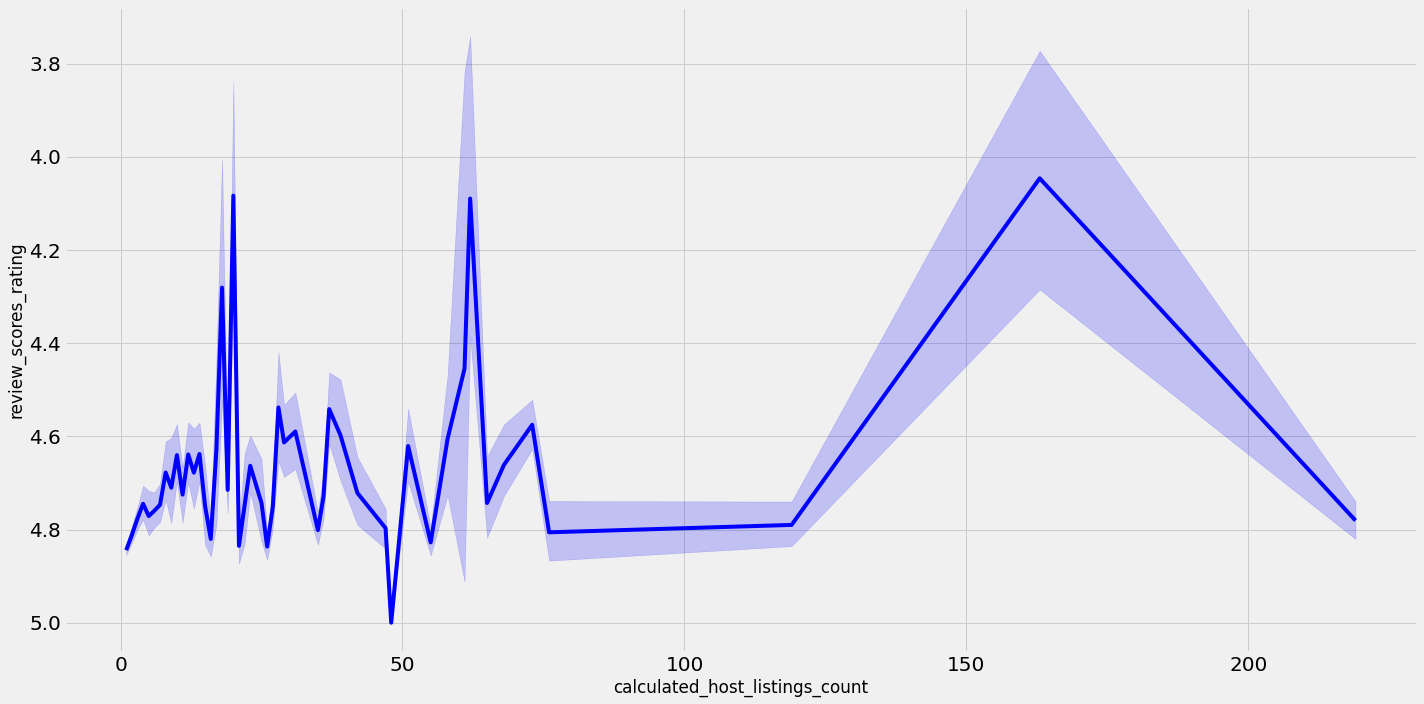

In [58]:
fig, ax = plt.subplots(figsize=(20, 10))

#p = sns.lineplot(data=df, x='stripped_rating', y='price', color='blue');
#p = sns.lineplot(data=plot_df, x='review_scores_rating',y='calculated_host_listings_count', color='blue');
p = sns.lineplot(data=plot_df, x='calculated_host_listings_count', y='review_scores_rating', color='blue');

p.invert_yaxis()
#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

#y1 = p.axvline('2008-01', color='red') #housing market crash begins
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#fmt = '${x:,.0f}'
#tick = mtick.StrMethodFormatter(fmt)
#ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

plt.tight_layout()

plt.show();

### Analysis: 
This is a very basic plot, but seems to show that there is a "sweet spot" for pricing that is around $300.

In [59]:
#scatter_df = df[df['review_scores_rating'] >= 4.0]

In [60]:
#scatter_mean = scatter_df['price'].mean()
#scatter_mean

In [61]:
#fig, ax = plt.subplots(figsize=(20, 10))

#p = sns.lineplot(data=scatter_df, x='review_scores_rating', y='price', color='blue');


#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

#y1 = p.axhline(scatter_mean, color='red') 
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)

#fmt = '${x:,.0f}'
#tick = mtick.StrMethodFormatter(fmt)
#ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
#plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

#plt.tight_layout()

#plt.show();

### Creating Analysis_df

In [62]:
analysis_df = df.copy()

## EDA

In [63]:
analysis_df['5_star'].value_counts()

True     4918
False    2892
Name: 5_star, dtype: int64

<b>Analysis: Out of the 7810 Records in this dataset, 22.1% have a 5 Star Overall Rating </b>

In [64]:
df['room_type'].value_counts()

Entire home/apt    6487
Private room       1261
Shared room          57
Hotel room            5
Name: room_type, dtype: int64

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7810 entries, 0 to 10933
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           7810 non-null   float64
 1   review_scores_rating            7810 non-null   float64
 2   review_scores_accuracy          7810 non-null   float64
 3   review_scores_cleanliness       7810 non-null   float64
 4   review_scores_checkin           7810 non-null   float64
 5   review_scores_communication     7810 non-null   float64
 6   review_scores_location          7810 non-null   float64
 7   review_scores_value             7810 non-null   float64
 8   accommodates                    7810 non-null   int64  
 9   bedrooms                        7810 non-null   float64
 10  beds                            7810 non-null   float64
 11  instant_bookable                7810 non-null   bool   
 12  property_type                   7

## Modelling

### One Hot Encoding

In [66]:
need_to_encode = df[['5_star', 'accuracy_5', 'cleanliness_5', 'checkin_5', 'location_5', 'value_5',
                     'communication_5', 'room_type',  'bedrooms_1', 'bedrooms_2', 'bedrooms_3+',
                     'bookings_above_avg', 'instant_bookable', 'capacity_couple', 'capacity_family',
                     'capacity_large', 'host_listings_1', 'host_listings_2-4', 'host_listings_5-10',
                     'host_listings_11-49', 'host_listings_50+', 'superhost', 'host_response_100',
                     'host_response_90', 'host_response_low', 'host_response_time']]

                    
ohe = OneHotEncoder()
ohe.fit(need_to_encode)

ohe_1 = ohe.transform(need_to_encode).toarray()

ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names(need_to_encode.columns))
ohe_df.head(2)

5_star_False  5_star_True  accuracy_5_False  accuracy_5_True  \
0           0.0          1.0               0.0              1.0   
1           0.0          1.0               1.0              0.0   

   cleanliness_5_False  cleanliness_5_True  checkin_5_False  checkin_5_True  \
0                  0.0                 1.0              0.0             1.0   
1                  1.0                 0.0              1.0             0.0   

   location_5_False  location_5_True  ...  host_response_100_False  \
0               1.0              0.0  ...                      0.0   
1               1.0              0.0  ...                      0.0   

   host_response_100_True  host_response_90_False  host_response_90_True  \
0                     1.0                     1.0                    0.0   
1                     1.0                     1.0                    0.0   

   host_response_low_False  host_response_low_True  \
0                      1.0                     0.0   
1                      1.0                     0.0   

   host_response_time_a few days or more  host_response_time_within a day  \
0                                    0.0                              0.0   
1                                    0.0                              0.0   

   host_response_time_within a few hours  host_response_time_within an hour  
0                                    0.0                                1.0  
1                                    0.0                                1.0  

[2 rows x 56 columns]

#### Fixing Room Type

In [67]:
ohe_df['room_type_room'] = ohe_df.apply(lambda x: x['room_type_Hotel room'] + x['room_type_Private room'] + x['room_type_Shared room'], axis=1)

In [68]:
ohe_df['room_type_room'].value_counts()

0.0    6487
1.0    1323
Name: room_type_room, dtype: int64

In [69]:
ohe_df.drop(['room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room'], axis=1, inplace=True)

#### Fixing Host Response Time

In [70]:
ohe_df['host_response_24hrs+'] = ohe_df.apply(lambda x: x['host_response_time_a few days or more'] + x['host_response_time_within a day'], axis=1)

In [71]:
ohe_df.drop(['host_response_time_a few days or more', 'host_response_time_within a day'], axis=1, inplace=True)

In [72]:
#old one

#need_to_encode = df[['5_star', 'accuracy_5', 'cleanliness_5', 'checkin_5', 'location_5', 'value_5',
 #                    'communication_5', 'room_type',  'bedrooms_1', 'bedrooms_2+', 'booked', 
  #                   'instant_bookable', 'capacity_couple', 'capacity_family', 'capacity_large',
   #                  'host_listings_5+', 'superhost', 'host_response_100', 'host_response_time']]
                     
                     # 'price_high', 'price_low',
                    #'capacity_1-4', 'capacity_5+',
                    # 'capacity_-2','capacity_-4', 'capacity_-6', 'capacity_-10', 'capacity_11+',
                    #'bedrooms_1', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4+', 'instant_bookable']]
                    
#ohe = OneHotEncoder()
#ohe.fit(need_to_encode)

#ohe_1 = ohe.transform(need_to_encode).toarray()

#ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names(need_to_encode.columns))
#ohe_df.head(2)

In [73]:
# Combining everything together
#cleaned_df = pd.concat([pd.DataFrame(feature_df), ohe_df], axis=1)
#cleaned_df.head(2)

In [74]:
cleaned_df = ohe_df

In [75]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7810 entries, 0 to 7809
Data columns (total 53 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   5_star_False                           7810 non-null   float64
 1   5_star_True                            7810 non-null   float64
 2   accuracy_5_False                       7810 non-null   float64
 3   accuracy_5_True                        7810 non-null   float64
 4   cleanliness_5_False                    7810 non-null   float64
 5   cleanliness_5_True                     7810 non-null   float64
 6   checkin_5_False                        7810 non-null   float64
 7   checkin_5_True                         7810 non-null   float64
 8   location_5_False                       7810 non-null   float64
 9   location_5_True                        7810 non-null   float64
 10  value_5_False                          7810 non-null   float64
 11  valu

#### Dropping One Value for Categoricals

In [76]:
cleaned_df.drop(['5_star_False', 'accuracy_5_False', 'cleanliness_5_False', 'checkin_5_False', 'location_5_False',
                 'value_5_False', 'communication_5_False', 'bedrooms_1_False', 'bedrooms_2_False', 'bedrooms_3+_False',
                 'bookings_above_avg_False', 'instant_bookable_False', 'capacity_couple_False', 'capacity_family_False',
                 'capacity_large_False', 'host_listings_1_False', 'host_listings_2-4_False', 'host_listings_5-10_False',
                 'host_listings_11-49_False', 'host_listings_50+_False', 'superhost_False', 'host_response_100_False',
                     'host_response_90_False', 'host_response_low_False'], axis=1, inplace=True)

In [77]:
#old one

#cleaned_df.drop(['5_star_False', 'accuracy_5_False', 'cleanliness_5_False', 'checkin_5_False',
 #                             'location_5_False','value_5_False', 'bedrooms_1_False', 'bedrooms_2+_False',
    #                          'capacity_couple_False', 'capacity_family_False', 'capacity_large_False',
      #                        'instant_bookable_False', 'booked_False', 'room_type_Hotel room',
       #                       'host_response_100_False', 'communication_5_False', 'superhost_False',
        #                      'host_listings_5+_False'], axis=1, inplace=True)
                              
                              
                              #'price_high_False', 'price_low_False',
                           # 'bedrooms_1_False', 'bedrooms_2_False', 'bedrooms_3_False', 'bedrooms_4+_False',
                             
                            #'capacity_1-4_False', 'capacity_5+_False',
                             # 'capacity_-2_False','capacity_-4_False', 'capacity_-6_False',
                             # 'capacity_-10_False', 'capacity_11+_False',
                            

#### Dealing with Class Imbalance

- <b> Solution </b>
    - Always use class weight parameter in Decision Tree Classifier
    - Always stratify Train Test Split.
    - Add SMOTE to Training Sets.

In [78]:
cleaned_df.isna().sum()

5_star_True                              0
accuracy_5_True                          0
cleanliness_5_True                       0
checkin_5_True                           0
location_5_True                          0
value_5_True                             0
communication_5_True                     0
room_type_Entire home/apt                0
bedrooms_1_True                          0
bedrooms_2_True                          0
bedrooms_3+_True                         0
bookings_above_avg_True                  0
instant_bookable_True                    0
capacity_couple_True                     0
capacity_family_True                     0
capacity_large_True                      0
host_listings_1_True                     0
host_listings_2-4_True                   0
host_listings_5-10_True                  0
host_listings_11-49_True                 0
host_listings_50+_True                   0
superhost_True                           0
host_response_100_True                   0
host_respon

In [79]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7810 entries, 0 to 7809
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   5_star_True                            7810 non-null   float64
 1   accuracy_5_True                        7810 non-null   float64
 2   cleanliness_5_True                     7810 non-null   float64
 3   checkin_5_True                         7810 non-null   float64
 4   location_5_True                        7810 non-null   float64
 5   value_5_True                           7810 non-null   float64
 6   communication_5_True                   7810 non-null   float64
 7   room_type_Entire home/apt              7810 non-null   float64
 8   bedrooms_1_True                        7810 non-null   float64
 9   bedrooms_2_True                        7810 non-null   float64
 10  bedrooms_3+_True                       7810 non-null   float64
 11  book

In [80]:
review_df = cleaned_df[['5_star_True', 'accuracy_5_True', 'cleanliness_5_True', 'checkin_5_True',
                       'location_5_True', 'value_5_True', 'communication_5_True']]
review_df

5_star_True  accuracy_5_True  cleanliness_5_True  checkin_5_True  \
0             1.0              1.0                 1.0             1.0   
1             1.0              0.0                 0.0             0.0   
2             1.0              1.0                 0.0             1.0   
3             1.0              0.0                 0.0             1.0   
4             1.0              1.0                 0.0             0.0   
...           ...              ...                 ...             ...   
7805          1.0              0.0                 1.0             1.0   
7806          0.0              0.0                 0.0             0.0   
7807          1.0              0.0                 0.0             0.0   
7808          1.0              0.0                 1.0             1.0   
7809          0.0              0.0                 0.0             0.0   

      location_5_True  value_5_True  communication_5_True  
0                 0.0           1.0                   1.0  
1                 0.0           0.0                   0.0  
2                 0.0           0.0                   1.0  
3                 0.0           0.0                   1.0  
4                 1.0           0.0                   0.0  
...               ...           ...                   ...  
7805              1.0           0.0                   0.0  
7806              0.0           0.0                   0.0  
7807              0.0           0.0                   0.0  
7808              1.0           1.0                   1.0  
7809              0.0           0.0                   0.0  

[7810 rows x 7 columns]

### <b>Train Test Split</b>

In [81]:
balanced_df = cleaned_df.copy()


X = balanced_df.drop(['5_star_True'], axis=1)
y = balanced_df['5_star_True']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=23)

smote = SMOTE(random_state=23)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

### Metrics Function

In [82]:
def get_metrics(clf, y_pred):
    
    
    #clf_acc = accuracy_score(y_test, y_pred) * 100
    #print('Accuracy is :{0}'.format(clf_acc))
    clf_prec = precision_score(y_test, y_pred) * 100
    print('Precision is :{0}'.format(clf_prec))
    #clf_rcl = recall_score(y_test, y_pred) * 100
    #print('Recall is :{0}'.format(clf_rcl))
    clf_f1 = f1_score(y_test, y_pred) * 100
    print('F1 Score is :{0}'.format(clf_f1))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    clf_roc_auc = auc(false_positive_rate, true_positive_rate)
    print('ROC AUC is :{0}'.format(round(clf_roc_auc, 2)))
    clf_cv_score = np.mean(cross_val_score(clf, X_train_resampled, y_train_resampled, cv=10))
    print('Cross Validation Score is :{0}'.format(round(clf_cv_score, 3)))

### Choosing Evaluation Metrics
- My goal is to predict whether a person will get a perfect 5.0 Airbnb rating.
- Which is worse?
    - Model predicts that someone has a perfect rating, but they actually don't? (more false Positives)
    - Model predicts that someone does not have a perfect rating, but they actually do? (more false negatives)

<b> Decision </b>
- I want false Positives to be as low as possible.
- If my model says that a property will have a 5.0 score, I want it to be a near guarantee.
- If it misses some that will still get a 5.0 score that is fine.
- <b>Therefore, I am most concerned with Precision, balanced out by F1 score.</b>

In [83]:
X.describe()

accuracy_5_True  cleanliness_5_True  checkin_5_True  location_5_True  \
count      7810.000000         7810.000000     7810.000000      7810.000000   
mean          0.256594            0.234187        0.349040         0.304225   
std           0.436781            0.423517        0.476697         0.460108   
min           0.000000            0.000000        0.000000         0.000000   
25%           0.000000            0.000000        0.000000         0.000000   
50%           0.000000            0.000000        0.000000         0.000000   
75%           1.000000            0.000000        1.000000         1.000000   
max           1.000000            1.000000        1.000000         1.000000   

       value_5_True  communication_5_True  room_type_Entire home/apt  \
count   7810.000000           7810.000000                7810.000000   
mean       0.157618              0.355314                   0.830602   
std        0.364406              0.478639                   0.375127   
min        0.000000              0.000000                   0.000000   
25%        0.000000              0.000000                   1.000000   
50%        0.000000              0.000000                   1.000000   
75%        0.000000              1.000000                   1.000000   
max        1.000000              1.000000                   1.000000   

       bedrooms_1_True  bedrooms_2_True  bedrooms_3+_True  ...  \
count      7810.000000      7810.000000       7810.000000  ...   
mean          0.458259         0.278105          0.263636  ...   
std           0.498287         0.448094          0.440633  ...   
min           0.000000         0.000000          0.000000  ...   
25%           0.000000         0.000000          0.000000  ...   
50%           0.000000         0.000000          0.000000  ...   
75%           1.000000         1.000000          1.000000  ...   
max           1.000000         1.000000          1.000000  ...   

       host_listings_11-49_True  host_listings_50+_True  superhost_True  \
count               7810.000000             7810.000000     7810.000000   
mean                   0.177081                0.098848        0.512036   
std                    0.381761                0.298476        0.499887   
min                    0.000000                0.000000        0.000000   
25%                    0.000000                0.000000        0.000000   
50%                    0.000000                0.000000        1.000000   
75%                    0.000000                0.000000        1.000000   
max                    1.000000                1.000000        1.000000   

       host_response_100_True  host_response_90_True  host_response_low_True  \
count             7810.000000            7810.000000             7810.000000   
mean                 0.732522               0.190397                0.077081   
std                  0.442672               0.392639                0.266736   
min                  0.000000               0.000000                0.000000   
25%                  0.000000               0.000000                0.000000   
50%                  1.000000               0.000000                0.000000   
75%                  1.000000               0.000000                0.000000   
max                  1.000000               1.000000                1.000000   

       host_response_time_within a few hours  \
count                            7810.000000   
mean                                0.127145   
std                                 0.333156   
min                                 0.000000   
25%                                 0.000000   
50%                                 0.000000   
75%                                 0.000000   
max                                 1.000000   

       host_response_time_within an hour  room_type_room  host_response_24hrs+  
count                        7810.000000     7810.000000           7810.000000  
mean                            0.797567        0.169398   

## Baseline Decision Tree

In [84]:
#w/out SMOTE
dt0 = DecisionTreeClassifier(random_state=23, class_weight="balanced")
dt0.fit(X_train, y_train)
dt0_y_pred = dt0.predict(X_test)
get_metrics(dt0, dt0_y_pred)

Precision is :81.96308724832215
F1 Score is :80.67712634186623
ROC AUC is :0.75
Cross Validation Score is :0.788


In [85]:
dt1 = DecisionTreeClassifier(random_state=23, class_weight="balanced")
dt1.fit(X_train_resampled, y_train_resampled)
dt1_y_pred = dt1.predict(X_test)
get_metrics(dt1, dt1_y_pred)

Precision is :81.17839607201309
F1 Score is :80.91353996737357
ROC AUC is :0.74
Cross Validation Score is :0.788


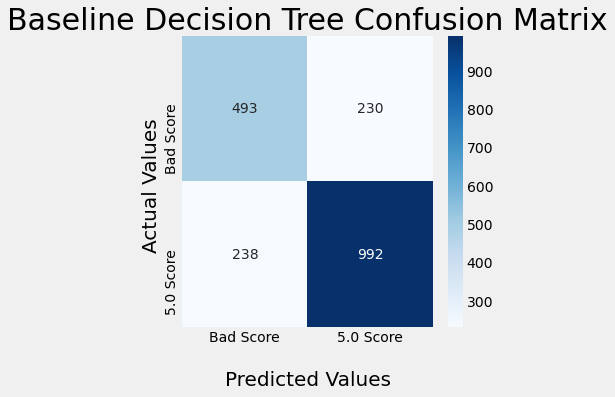

In [86]:
dt1_matrix = confusion_matrix(y_test, dt1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Baseline Decision Tree Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Refining Decision Tree through GridSearchCV

In [87]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [88]:
# Instantiate GridSearchCV
dt2 = DecisionTreeClassifier(random_state=23)

dt_grid_search = GridSearchCV(dt2, dt_param_grid, cv=3, scoring = 'precision')

# Fit to the data
dt_grid_search.fit(X_train_resampled, y_train_resampled)
dt_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

## Decision Tree 2

In [89]:
dt2 = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2,
                             min_samples_leaf=2, class_weight='balanced', random_state=23)
dt2.fit(X_train_resampled, y_train_resampled)
dt2_y_pred = dt2.predict(X_test)
get_metrics(dt2, dt2_y_pred)

Precision is :82.49158249158249
F1 Score is :81.05872622001654
ROC AUC is :0.75
Cross Validation Score is :0.786


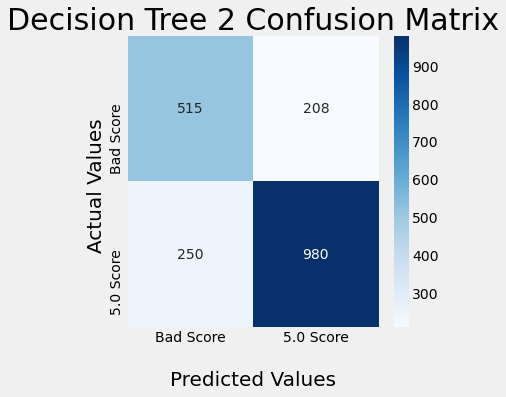

In [90]:
dt2_matrix = confusion_matrix(y_test, dt2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Decision Tree 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Random Forests

In [91]:
rf1_clf = RandomForestClassifier(random_state=23, class_weight="balanced")
rf1_clf.fit(X_train_resampled, y_train_resampled)
rf1_y_pred = rf1_clf.predict(X_test)
get_metrics(rf1_clf, rf1_y_pred)

Precision is :81.97358197358197
F1 Score is :83.82995629717918
ROC AUC is :0.77
Cross Validation Score is :0.811


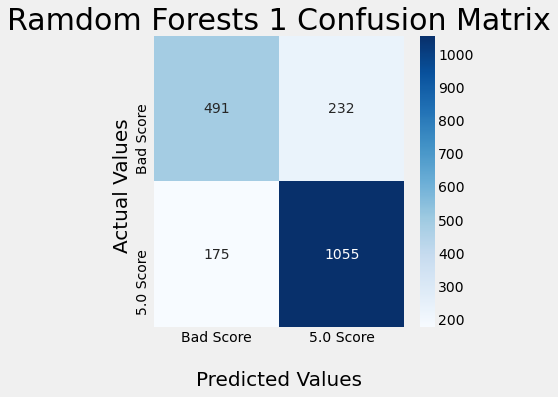

In [92]:
rf1_matrix = confusion_matrix(y_test, rf1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(rf1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Ramdom Forests 1 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### GridSearch CV

In [93]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [94]:
rf2_clf = RandomForestClassifier(random_state=23)


rf1_grid_search= GridSearchCV(rf2_clf, rf_param_grid, scoring = 'precision', cv=3)
rf1_grid_search.fit(X_train_resampled, y_train_resampled)

print("")
print(f"Random Forest  Optimal Parameters: {rf1_grid_search.best_params_}")


Random Forest  Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


## Random Forests 2

In [95]:
rf2_clf = RandomForestClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 3,
                                min_samples_split= 10, n_estimators= 100, random_state=23,
                                class_weight='balanced')
rf2_clf.fit(X_train_resampled, y_train_resampled)
rf2_y_pred = rf2_clf.predict(X_test)
get_metrics(rf2_clf, rf2_y_pred)

Precision is :83.39798293250583
F1 Score is :85.35132989281462
ROC AUC is :0.79
Cross Validation Score is :0.814


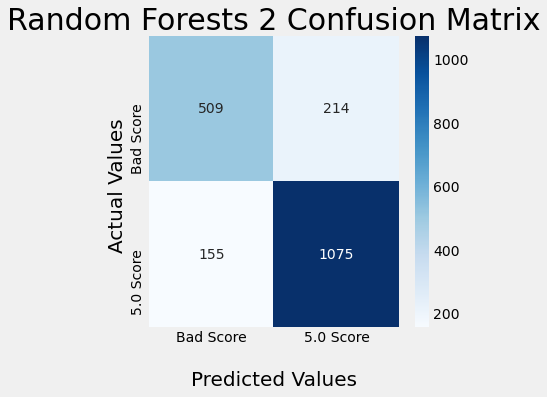

In [96]:
rf2_matrix = confusion_matrix(y_test, rf2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(rf2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Random Forests 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## XGBoost Model

In [97]:
# Instantiate XGBClassifier
clf = XGBClassifier(random_state=23)

# Fit XGBClassifier
xg1 = clf.fit(X_train_resampled, y_train_resampled)

# Predict on training and test sets
training_preds = clf.predict(X_train_resampled)
xg1_y_pred = clf.predict(X_test)
get_metrics(xg1, xg1_y_pred)

Precision is :82.51533742331289
F1 Score is :84.92501973164956
ROC AUC is :0.78
Cross Validation Score is :0.811


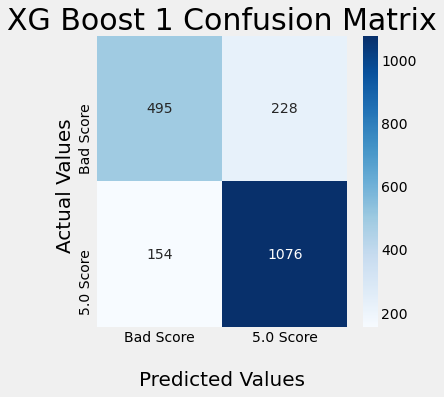

In [98]:
xg1_matrix = confusion_matrix(y_test, xg1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(xg1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('XG Boost 1 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### GridSearch

In [99]:
boost_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

## XGBoost 2

In [100]:
xg2 = XGBClassifier(random_state=23)

grid_clf = GridSearchCV(xg2, boost_param_grid, scoring='precision', cv=3, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.7


In [101]:
xg2 = XGBClassifier(learning_rate= 0.2, max_depth=6, min_child_weight=1,
                                n_estimators=100, subsample=0.7, random_state=23)
xg2.fit(X_train_resampled, y_train_resampled)
xg2_y_pred = xg2.predict(X_test)
get_metrics(xg2, xg2_y_pred)

Precision is :82.68199233716476
F1 Score is :85.12820512820512
ROC AUC is :0.78
Cross Validation Score is :0.815


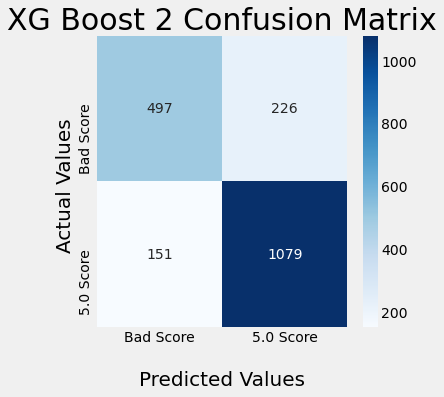

In [102]:
xg2_matrix = confusion_matrix(y_test, xg2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(xg2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('XG Boost 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## <b>FINAL MODEL = Random Forests 2<b>

In [103]:
#get_metrics(xg2, xg2_y_pred)
get_metrics(rf2_clf, rf2_y_pred)

Precision is :83.39798293250583
F1 Score is :85.35132989281462
ROC AUC is :0.79
Cross Validation Score is :0.814


### Model Evaluation: (needs to be revised)
- <b> Precision: </b> This Model correctly picks whether a rental will receive a perfect 5 star overall AirBnb rating 83.4% of the time.
    - This is over 30% better than random guessing.
    - The Final Model is also a slight improvement over the baseline model. (about 7% better)
- <b> Recall and F1 Score: </b> The Final Model's F1 Score is also high. The F1 Score indicates that Precision is reasonably balanced with Recall, so this model should be fairly effective in terms of precision vs. recall balance.
- <b> ROC AUC Score: </b> Shows the True Positive Rate vs. the False Postive Rate. While my goal was to have a AUC score of at least .80, this is nearly there, and was definitely my best performing model.
- <b> Cross Validation Score: </b> This model does reasonably well on data that it was not trained on. 

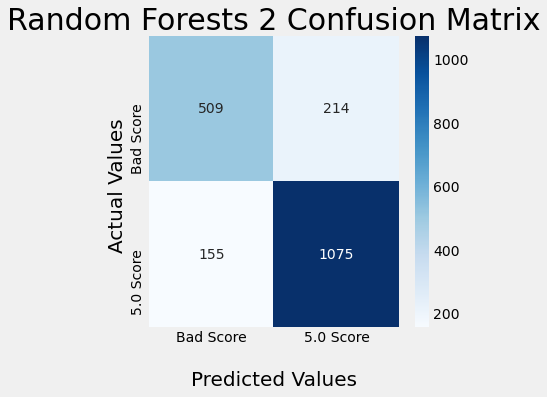

In [104]:
rf2_matrix = confusion_matrix(y_test, rf2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(rf2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Random Forests 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### How to use This Model going forward

## <b><u>Feature Importance</b></u>

In [105]:
feature_names = list(X)
rf2_importance = rf2_clf.feature_importances_

In [106]:
#feature_importance_df = pd.DataFrame(dt2_importance, feature_names)
feature_importance_df = pd.DataFrame(rf2_importance, feature_names)
#feature_importance_df = pd.DataFrame(xg2_importance, feature_names)
feature_importance_df= feature_importance_df.reset_index()
feature_importance_df.rename(columns={'index': 'Feature', 0: 'Importance'}, inplace=True)
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

Feature  Importance
20                         superhost_True    0.305344
5                    communication_5_True    0.109563
0                         accuracy_5_True    0.098414
1                      cleanliness_5_True    0.069712
2                          checkin_5_True    0.051318
4                            value_5_True    0.042530
3                         location_5_True    0.037405
15                   host_listings_1_True    0.030998
10                bookings_above_avg_True    0.028333
11                  instant_bookable_True    0.027325
21                 host_response_100_True    0.024088
18               host_listings_11-49_True    0.018746
22                  host_response_90_True    0.015254
12                   capacity_couple_True    0.013694
8                         bedrooms_2_True    0.012788
16                 host_listings_2-4_True    0.012357
14                    capacity_large_True    0.011555
19                 host_listings_50+_True    0.011480
9                        bedrooms_3+_True    0.009847
17                host_listings_5-10_True    0.009499
7                         bedrooms_1_True    0.009372
25      host_response_time_within an hour    0.009356
24  host_response_time_within a few hours    0.008138
13                   capacity_family_True    0.007462
6               room_type_Entire home/apt    0.007246
26                         room_type_room    0.007151
27                   host_response_24hrs+    0.005946
23                 host_response_low_True    0.005080

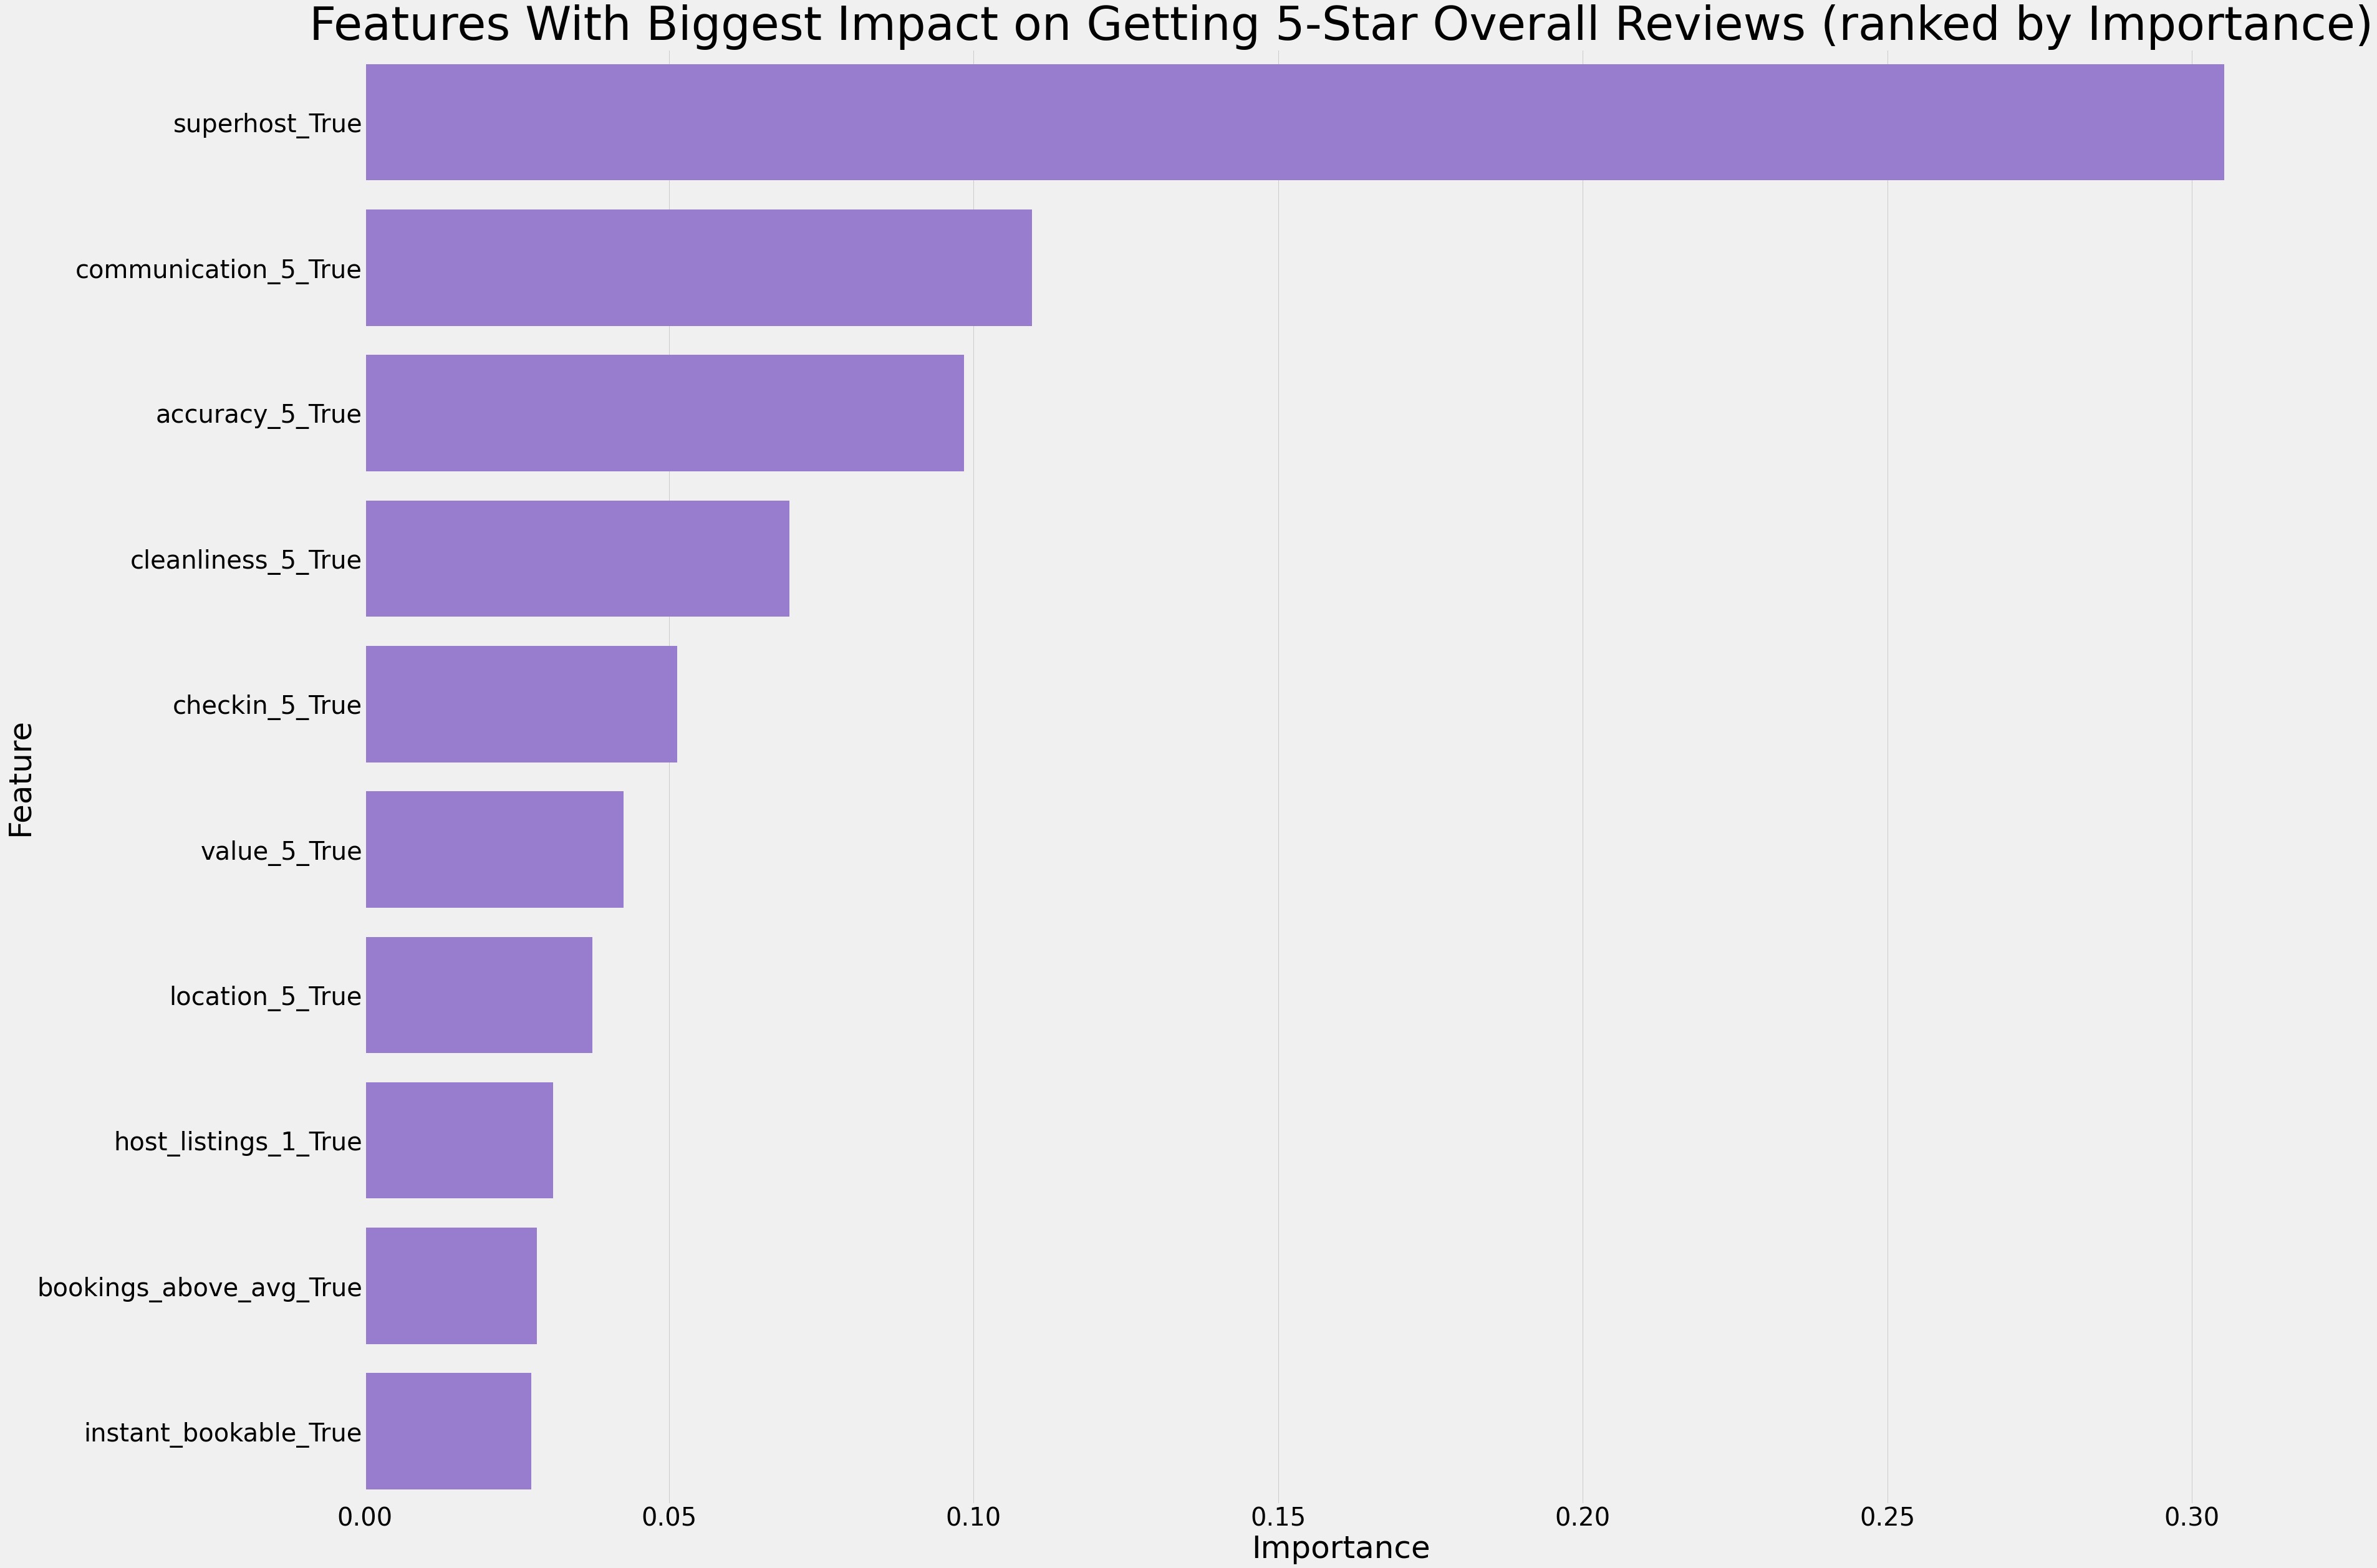

In [107]:
# plot feature importance
fig, ax = plt.subplots(figsize=(50,40))
p = sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature', color ='mediumpurple' );
p.set_xlabel("Importance", fontsize = 50)

p.set_ylabel("Feature", fontsize = 50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

p.set_title("Features With Biggest Impact on Getting 5-Star Overall Reviews (ranked by Importance)", fontsize = 75)
plt.figsize=(30,20) 

plt.show();

## <b>Review Metric DF (or Feature Analysis DF)</b>

In [108]:
review_metrics = balanced_df.copy()

In [109]:
review_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7810 entries, 0 to 7809
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   5_star_True                            7810 non-null   float64
 1   accuracy_5_True                        7810 non-null   float64
 2   cleanliness_5_True                     7810 non-null   float64
 3   checkin_5_True                         7810 non-null   float64
 4   location_5_True                        7810 non-null   float64
 5   value_5_True                           7810 non-null   float64
 6   communication_5_True                   7810 non-null   float64
 7   room_type_Entire home/apt              7810 non-null   float64
 8   bedrooms_1_True                        7810 non-null   float64
 9   bedrooms_2_True                        7810 non-null   float64
 10  bedrooms_3+_True                       7810 non-null   float64
 11  book

In [110]:
#review_metrics = df[['5_star', 'accuracy_5', 'communication_5','cleanliness_5', 'checkin_5', 'location_5',
#                     'value_5', 'superhost', 'host_listings_1', 'host_listings_2-4', 'host_listings_5-10',
#                     'host_listings_11-49', 'host_listings_50+','instant_bookable', 'bookings_above_avg', 
#                     'capacity_couple', 'capacity_family', 'capacity_large', 'host_response_100', 
#                     'host_response_90', 'host_response_low', 'room_type', 'host_response_time',
#                     'bedrooms_1', 'bedrooms_2', 'bedrooms_3+']]

In [111]:
#need_to_encode_2 = review_metrics[['host_response_time', 'room_type']]

#ohe.fit(need_to_encode_2)

#ohe_2 = ohe.transform(need_to_encode_2).toarray()

#ohe_df_2 = pd.DataFrame(ohe_2, columns=ohe.get_feature_names(need_to_encode_2.columns))
#ohe_df_2.head(2)

In [112]:
#review_metrics = pd.concat([pd.DataFrame(review_metrics), ohe_df_2], axis=1)
#review_metrics

In [113]:
#review_metrics.drop(['room_type_Shared room', 'room_type_Hotel room'], axis=1, inplace=True)

In [114]:
#review_metrics.drop(['host_response_time_a few days or more', 'host_response_time_within a day'], axis=1, inplace=True)

In [115]:
#old one

#review_metrics = df[['5_star', 'accuracy_5', 'communication_5','cleanliness_5', 'checkin_5', 'location_5',
#                     'value_5', 'superhost', 'host_listings_5+', 'instant_bookable', 'booked', 
#                     'capacity_couple', 'capacity_family', 'capacity_large', 'host_response_100',
#                     'room_type', 'host_response_time','bedrooms_1']]

In [116]:
#review_metrics.head(2)

In [117]:
#review_metrics['instant_bookable'] = review_metrics['instant_bookable'].astype('bool')
#review_metrics['host_is_superhost'] = review_metrics['host_is_superhost'].astype('bool')

In [118]:
#review_metrics['instant_bookable'].value_counts()

## Function get_stats( )

In [119]:
def get_stats(df):
    
    df_transposed = df.transpose()
    df_transposed = df_transposed.reset_index()
    df_transposed.rename(columns={'index': 'Metric'}, inplace=True)
    stats_df = df_transposed
    #total = 1.00
   #stats_df['total'] = total
    #difference = stats_df.apply(lambda x: x[True] - x[False], axis=1)
    #stats_df['diff'] = difference
    #percent_difference = stats_df.apply(lambda x: x['diff'] / x['total'], axis=1)
    #stats_df['diff_percent'] = percent_difference
    #true = stats_df.apply(lambda x: x[True] / x[total], axis=1)
    #stats_df['%_True'] = true*100
    #false = stats_df.apply(lambda x: x[False] / x[total], axis=1)
    #stats_df['%_False'] = false*100
    #delta = stats_df.apply(lambda x: x['%_True'] - x['%_False'], axis=1)
    delta = stats_df.apply(lambda x: x[1.0] - x[0.0], axis=1)
    stats_df['delta'] = delta
         
    return stats_df. sort_values('delta', ascending=False)

In [120]:
def plot_stats(df):
    
    fig, ax = plt.subplots(figsize=(100,20))
    p = sns.barplot(data=df.head, x='Metric', y='delta', color ='seagreen' );
    #p.set_ylabel("Percentage of 5 Star Rentals", fontsize = 50)

    p.set_xlabel("Feature", fontsize = 50)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=40)

    #ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

    p.set_title("Difference Between Features ", fontsize = 50)
    plt.figsize=(30,20) 

    return plt.show();

In [121]:
#pd.set_option("display.precision", 4)

In [122]:
review_metrics.describe()

5_star_True  accuracy_5_True  cleanliness_5_True  checkin_5_True  \
count  7810.000000      7810.000000         7810.000000     7810.000000   
mean      0.629706         0.256594            0.234187        0.349040   
std       0.482914         0.436781            0.423517        0.476697   
min       0.000000         0.000000            0.000000        0.000000   
25%       0.000000         0.000000            0.000000        0.000000   
50%       1.000000         0.000000            0.000000        0.000000   
75%       1.000000         1.000000            0.000000        1.000000   
max       1.000000         1.000000            1.000000        1.000000   

       location_5_True  value_5_True  communication_5_True  \
count      7810.000000   7810.000000           7810.000000   
mean          0.304225      0.157618              0.355314   
std           0.460108      0.364406              0.478639   
min           0.000000      0.000000              0.000000   
25%           0.000000      0.000000              0.000000   
50%           0.000000      0.000000              0.000000   
75%           1.000000      0.000000              1.000000   
max           1.000000      1.000000              1.000000   

       room_type_Entire home/apt  bedrooms_1_True  bedrooms_2_True  ...  \
count                7810.000000      7810.000000      7810.000000  ...   
mean                    0.830602         0.458259         0.278105  ...   
std                     0.375127         0.498287         0.448094  ...   
min                     0.000000         0.000000         0.000000  ...   
25%                     1.000000         0.000000         0.000000  ...   
50%                     1.000000         0.000000         0.000000  ...   
75%                     1.000000         1.000000         1.000000  ...   
max                     1.000000         1.000000         1.000000  ...   

       host_listings_11-49_True  host_listings_50+_True  superhost_True  \
count               7810.000000             7810.000000     7810.000000   
mean                   0.177081                0.098848        0.512036   
std                    0.381761                0.298476        0.499887   
min                    0.000000                0.000000        0.000000   
25%                    0.000000                0.000000        0.000000   
50%                    0.000000                0.000000        1.000000   
75%                    0.000000                0.000000        1.000000   
max                    1.000000                1.000000        1.000000   

       host_response_100_True  host_response_90_True  host_response_low_True  \
count             7810.000000            7810.000000             7810.000000   
mean                 0.732522               0.190397                0.077081   
std                  0.442672               0.392639                0.266736   
min                  0.000000               0.000000                0.000000   
25%                  0.000000               0.000000                0.000000   
50%                  1.000000               0.000000                0.000000   
75%                  1.000000               0.000000                0.000000   
max                  1.000000               1.000000                1.000000   

       host_response_time_within a few hours  \
count                            7810.000000   
mean                                0.127145   
std                                 0.333156   
min                                 0.000000   
25%                                 0.000000   
50%                                 0.000000   
75%                                 0.000000   
max                                 1.000000   

       host_response_time_within an hour  room_type_room  host_response_24hrs+  
count                        7810.000000     7810.000000           7810.000000  
mean                            0.797567        0.169398              0.075288  
std                    

### <b>Top Feature #1: SuperHost</b>

In [123]:
review_metrics['superhost_True'].value_counts()

1.0    3999
0.0    3811
Name: superhost_True, dtype: int64

In [124]:
superhost_metrics = review_metrics.groupby('superhost_True').mean()
superhost_metrics

5_star_True  accuracy_5_True  cleanliness_5_True  \
superhost_True                                                     
0.0                0.438468         0.297035            0.271845   
1.0                0.811953         0.218055            0.198300   

                checkin_5_True  location_5_True  value_5_True  \
superhost_True                                                  
0.0                   0.375754         0.371556      0.213592   
1.0                   0.323581         0.240060      0.104276   

                communication_5_True  room_type_Entire home/apt  \
superhost_True                                                    
0.0                         0.365783                   0.821569   
1.0                         0.345336                   0.839210   

                bedrooms_1_True  bedrooms_2_True  ...  \
superhost_True                                    ...   
0.0                    0.436106         0.288638  ...   
1.0                    0.479370         0.268067  ...   

                host_listings_5-10_True  host_listings_11-49_True  \
superhost_True                                                      
0.0                            0.125951                  0.229599   
1.0                            0.142286                  0.127032   

                host_listings_50+_True  host_response_100_True  \
superhost_True                                                   
0.0                           0.124114                0.645762   
1.0                           0.074769                0.815204   

                host_response_90_True  host_response_low_True  \
superhost_True                                                  
0.0                          0.212805                0.141433   
1.0                          0.169042                0.015754   

                host_response_time_within a few hours  \
superhost_True                                          
0.0                                          0.153765   
1.0                                          0.101775   

                host_response_time_within an hour  room_type_room  \
superhost_True                                                      
0.0                                      0.730255        0.178431   
1.0                                      0.861715        0.160790   

                host_response_24hrs+  
superhost_True                        
0.0                         0.115980  
1.0                         0.036509  

[2 rows x 28 columns]

In [125]:
superhost_stats = get_stats(superhost_metrics)
superhost_stats

superhost_True                                 Metric       0.0       1.0  \
0                                         5_star_True  0.438468  0.811953   
21                             host_response_100_True  0.645762  0.815204   
25                  host_response_time_within an hour  0.730255  0.861715   
17                             host_listings_2-4_True  0.223826  0.328082   
11                            bookings_above_avg_True  0.473367  0.568642   
8                                     bedrooms_1_True  0.436106  0.479370   
15                                capacity_large_True  0.577276  0.613403   
16                               host_listings_1_True  0.296510  0.327832   
13                               capacity_couple_True  0.241406  0.272068   
7                           room_type_Entire home/apt  0.821569  0.839210   
18                            host_listings_5-10_True  0.125951  0.142286   
14                               capacity_family_True  0.055628  0.058265   
26                                     room_type_room  0.178431  0.160790   
6                                communication_5_True  0.365783  0.345336   
9                                     bedrooms_2_True  0.288638  0.268067   
10                                   bedrooms_3+_True  0.275256  0.252563   
22                              host_response_90_True  0.212805  0.169042   
20                             host_listings_50+_True  0.124114  0.074769   
24              host_response_time_within a few hours  0.153765  0.101775   
3                                      checkin_5_True  0.375754  0.323581   
12                              instant_bookable_True  0.501706  0.446112   
2                                  cleanliness_5_True  0.271845  0.198300   
1                                     accuracy_5_True  0.297035  0.218055   
27                               host_response_24hrs+  0.115980  0.036509   
19                           host_listings_11-49_True  0.229599  0.127032   
5                                        value_5_True  0.213592  0.104276   
23                             host_response_low_True  0.141433  0.015754   
4                                     location_5_True  0.371556  0.240060   

superhost_True     delta  
0               0.373485  
21              0.169442  
25              0.131461  
17              0.104256  
11              0.095276  
8               0.043264  
15              0.036127  
16              0.031322  
13              0.030662  
7               0.017641  
18              0.016334  
14              0.002636  
26             -0.017641  
6              -0.020447  
9              -0.020571  
10             -0.022693  
22             -0.043763  
20             -0.049346  
24             -0.051990  
3              -0.052173  
12             -0.055594  
2              -0.073545  
1              -0.078980  
27             -0.079471  
19             -0.102567  
5              -0.109316  
23             -0.125679  
4              -0.131496

#### Analysis: 
- Superhosts have a more success in getting their units booked than non-superhosts. But it is just a 9.5% increase.
- They also have a much higher response rate than non-superhosts. Since this is a requirement of the superhost program, this isn't a surprise.
- There isn't much of a difference in the communication level of superhosts and non-superhosts.
- For most review metrics, Superhosts have a <b> lower </b> average rate than those of non-superhosts. Esecially in Value.

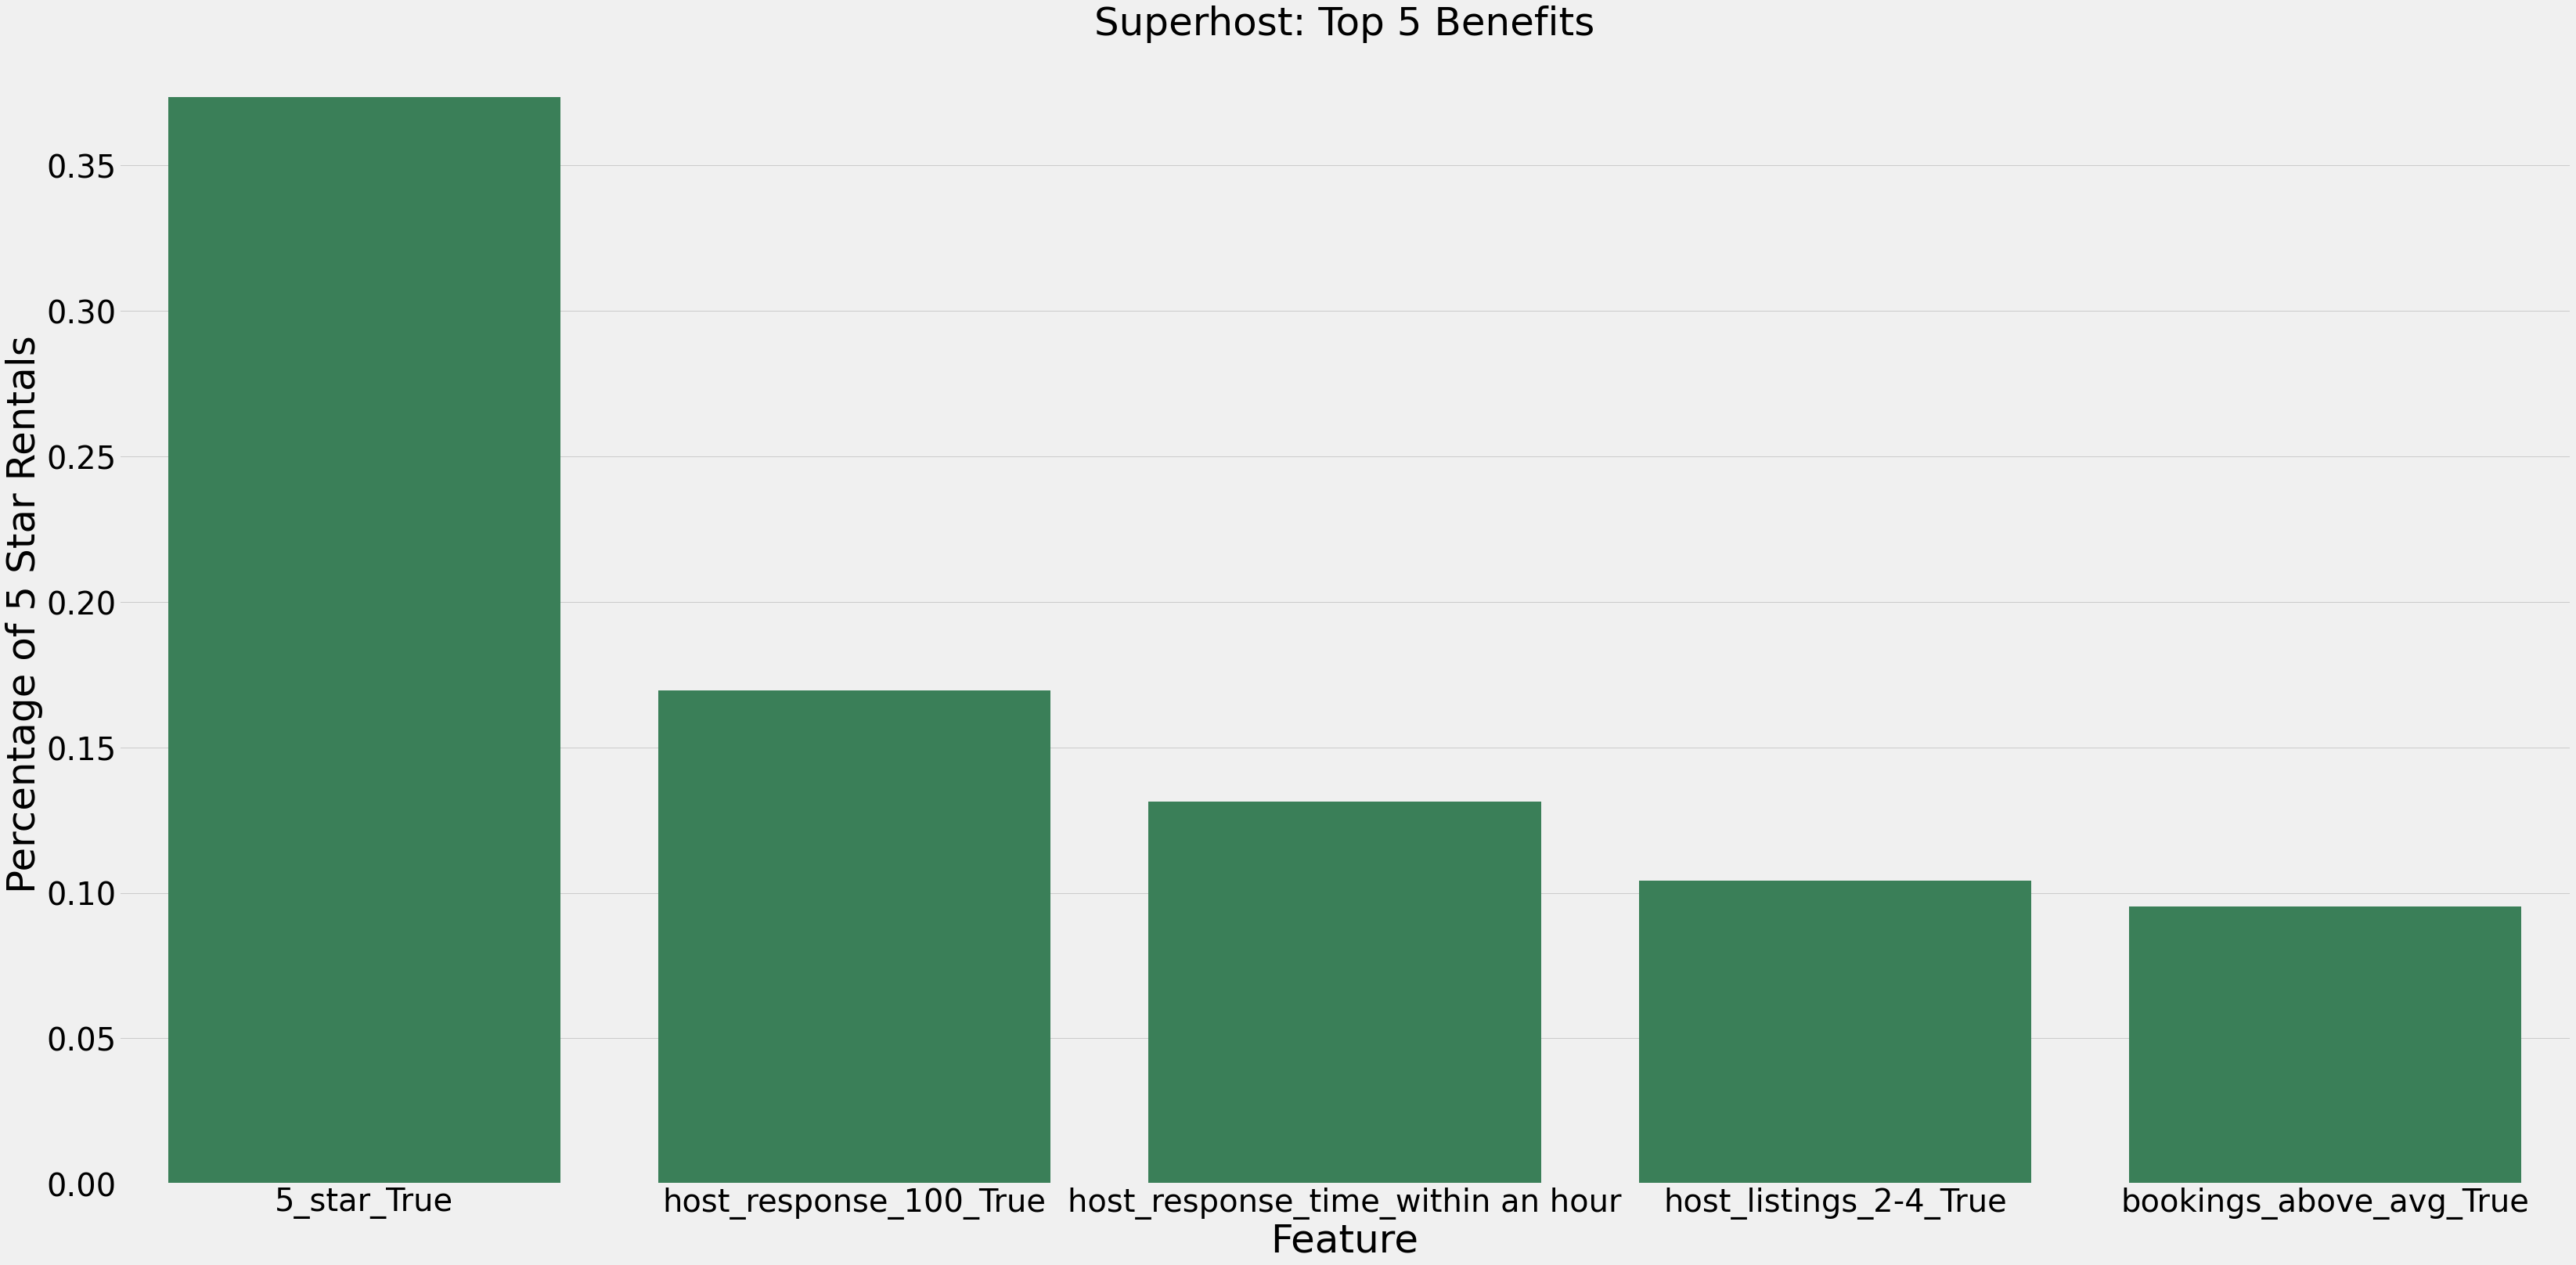

In [126]:
fig, ax = plt.subplots(figsize=(50,25))
p = sns.barplot(data=superhost_stats.head(5), x='Metric', y='delta', color ='seagreen' );
p.set_ylabel("Percentage of 5 Star Rentals", fontsize = 50)

p.set_xlabel("Feature", fontsize = 50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

p.set_title("Superhost: Top 5 Benefits", fontsize = 50)
plt.figsize=(30,20) 

plt.show();

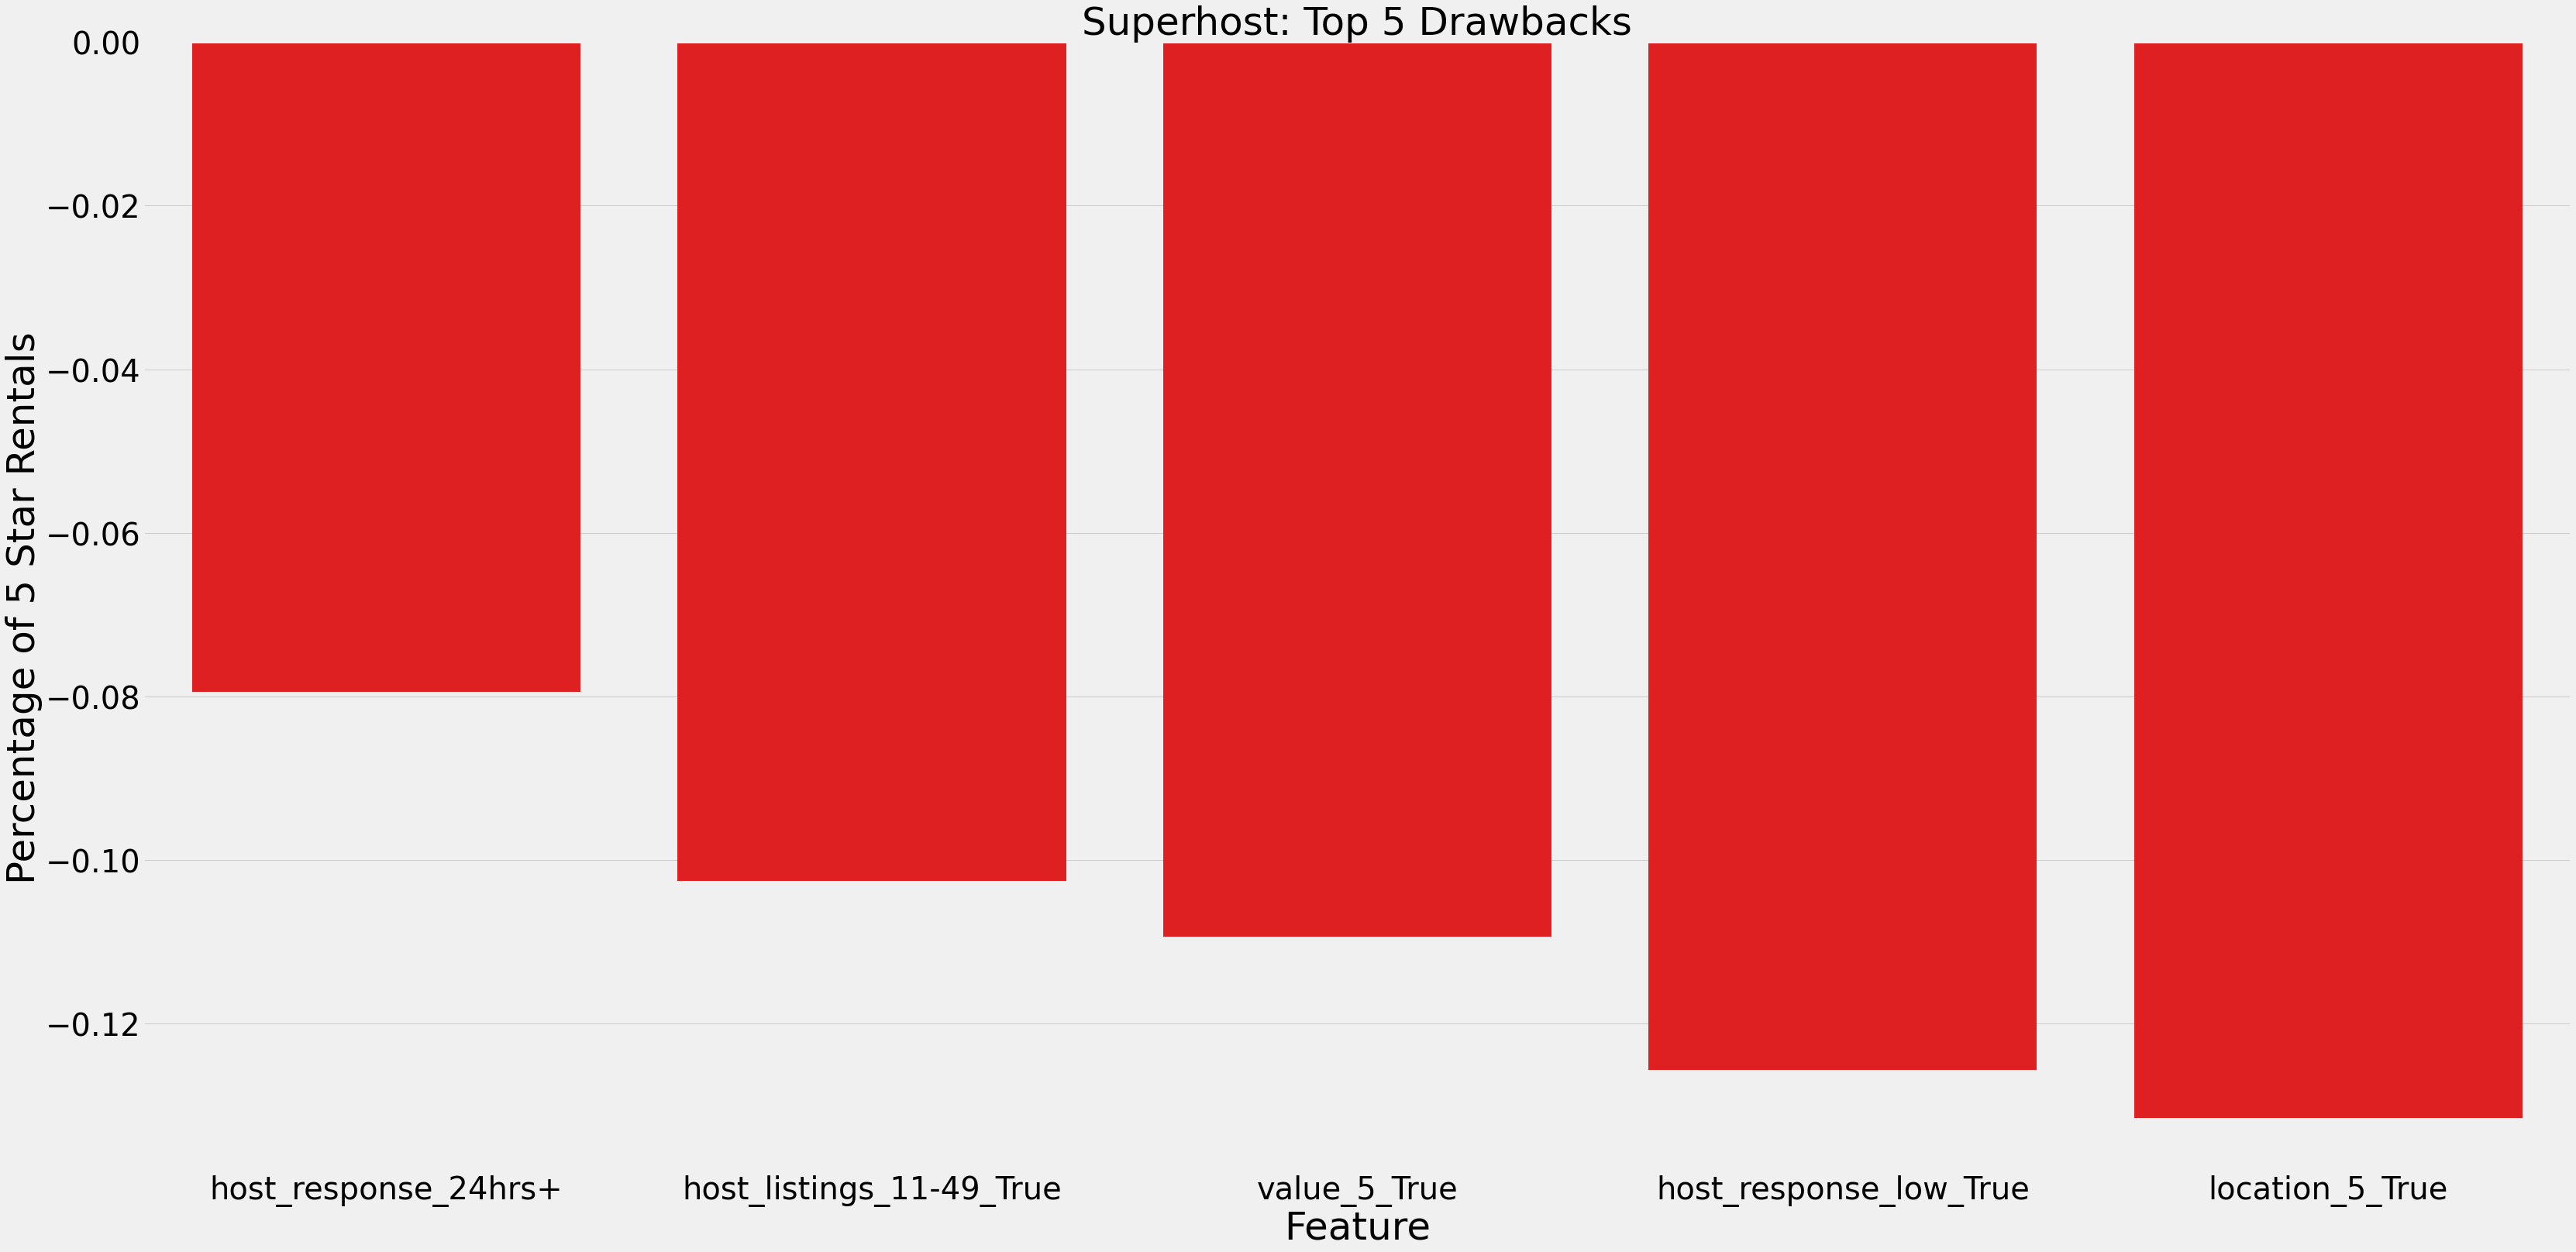

In [127]:
fig, ax = plt.subplots(figsize=(50,25))
p = sns.barplot(data=superhost_stats.tail(5), x='Metric', y='delta', color ='red' );
p.set_ylabel("Percentage of 5 Star Rentals", fontsize = 50)

p.set_xlabel("Feature", fontsize = 50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

p.set_title("Superhost: Top 5 Drawbacks", fontsize = 50)
plt.figsize=(30,20) 

plt.show();

#### Trying something new

In [185]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7810 entries, 0 to 10933
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           7810 non-null   float64
 1   review_scores_rating            7810 non-null   float64
 2   review_scores_accuracy          7810 non-null   float64
 3   review_scores_cleanliness       7810 non-null   float64
 4   review_scores_checkin           7810 non-null   float64
 5   review_scores_communication     7810 non-null   float64
 6   review_scores_location          7810 non-null   float64
 7   review_scores_value             7810 non-null   float64
 8   accommodates                    7810 non-null   int64  
 9   bedrooms                        7810 non-null   float64
 10  beds                            7810 non-null   float64
 11  instant_bookable                7810 non-null   bool   
 12  property_type                   7

In [188]:
new_df = analysis_df[['superhost', 'review_scores_rating', 'review_scores_communication', 'review_scores_accuracy',
                     'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_value', 
                     'bookings_above_avg', 'instant_bookable']]

In [192]:
cols = new_df.columns

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
p = sns.lineplot(data=genre_data, x='genres_list', y='production_budget' );

p.set_xlabel("Genres", fontsize = 15)
p.set_ylabel("Average Budget (in Millions)", fontsize = 15)
p.yaxis.set_major_formatter(display_millions)
p.set_title("Average Budget Among Genres", fontsize = 20)
plt.figsize=(30,20) 
plt.savefig('images/project_1_bar_1')

plt.show();

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
p = sns.barplot(data=new_df, x= cols, y='review_scores_cleanliness' );

p.set_xlabel("", fontsize = 15)
p.set_ylabel("Average Budget (in Millions)", fontsize = 15)
p.yaxis.set_major_formatter(display_millions)
p.set_title("Average Budget Among Genres", fontsize = 20)
plt.figsize=(30,20) 
plt.savefig('images/project_1_bar_1')

plt.show();

In [189]:
superhost_df = new_df['superhost'] == True
not_superhost_df = new_df['superhost'] == False

ValueError: Could not interpret input 'review_scores_rating'

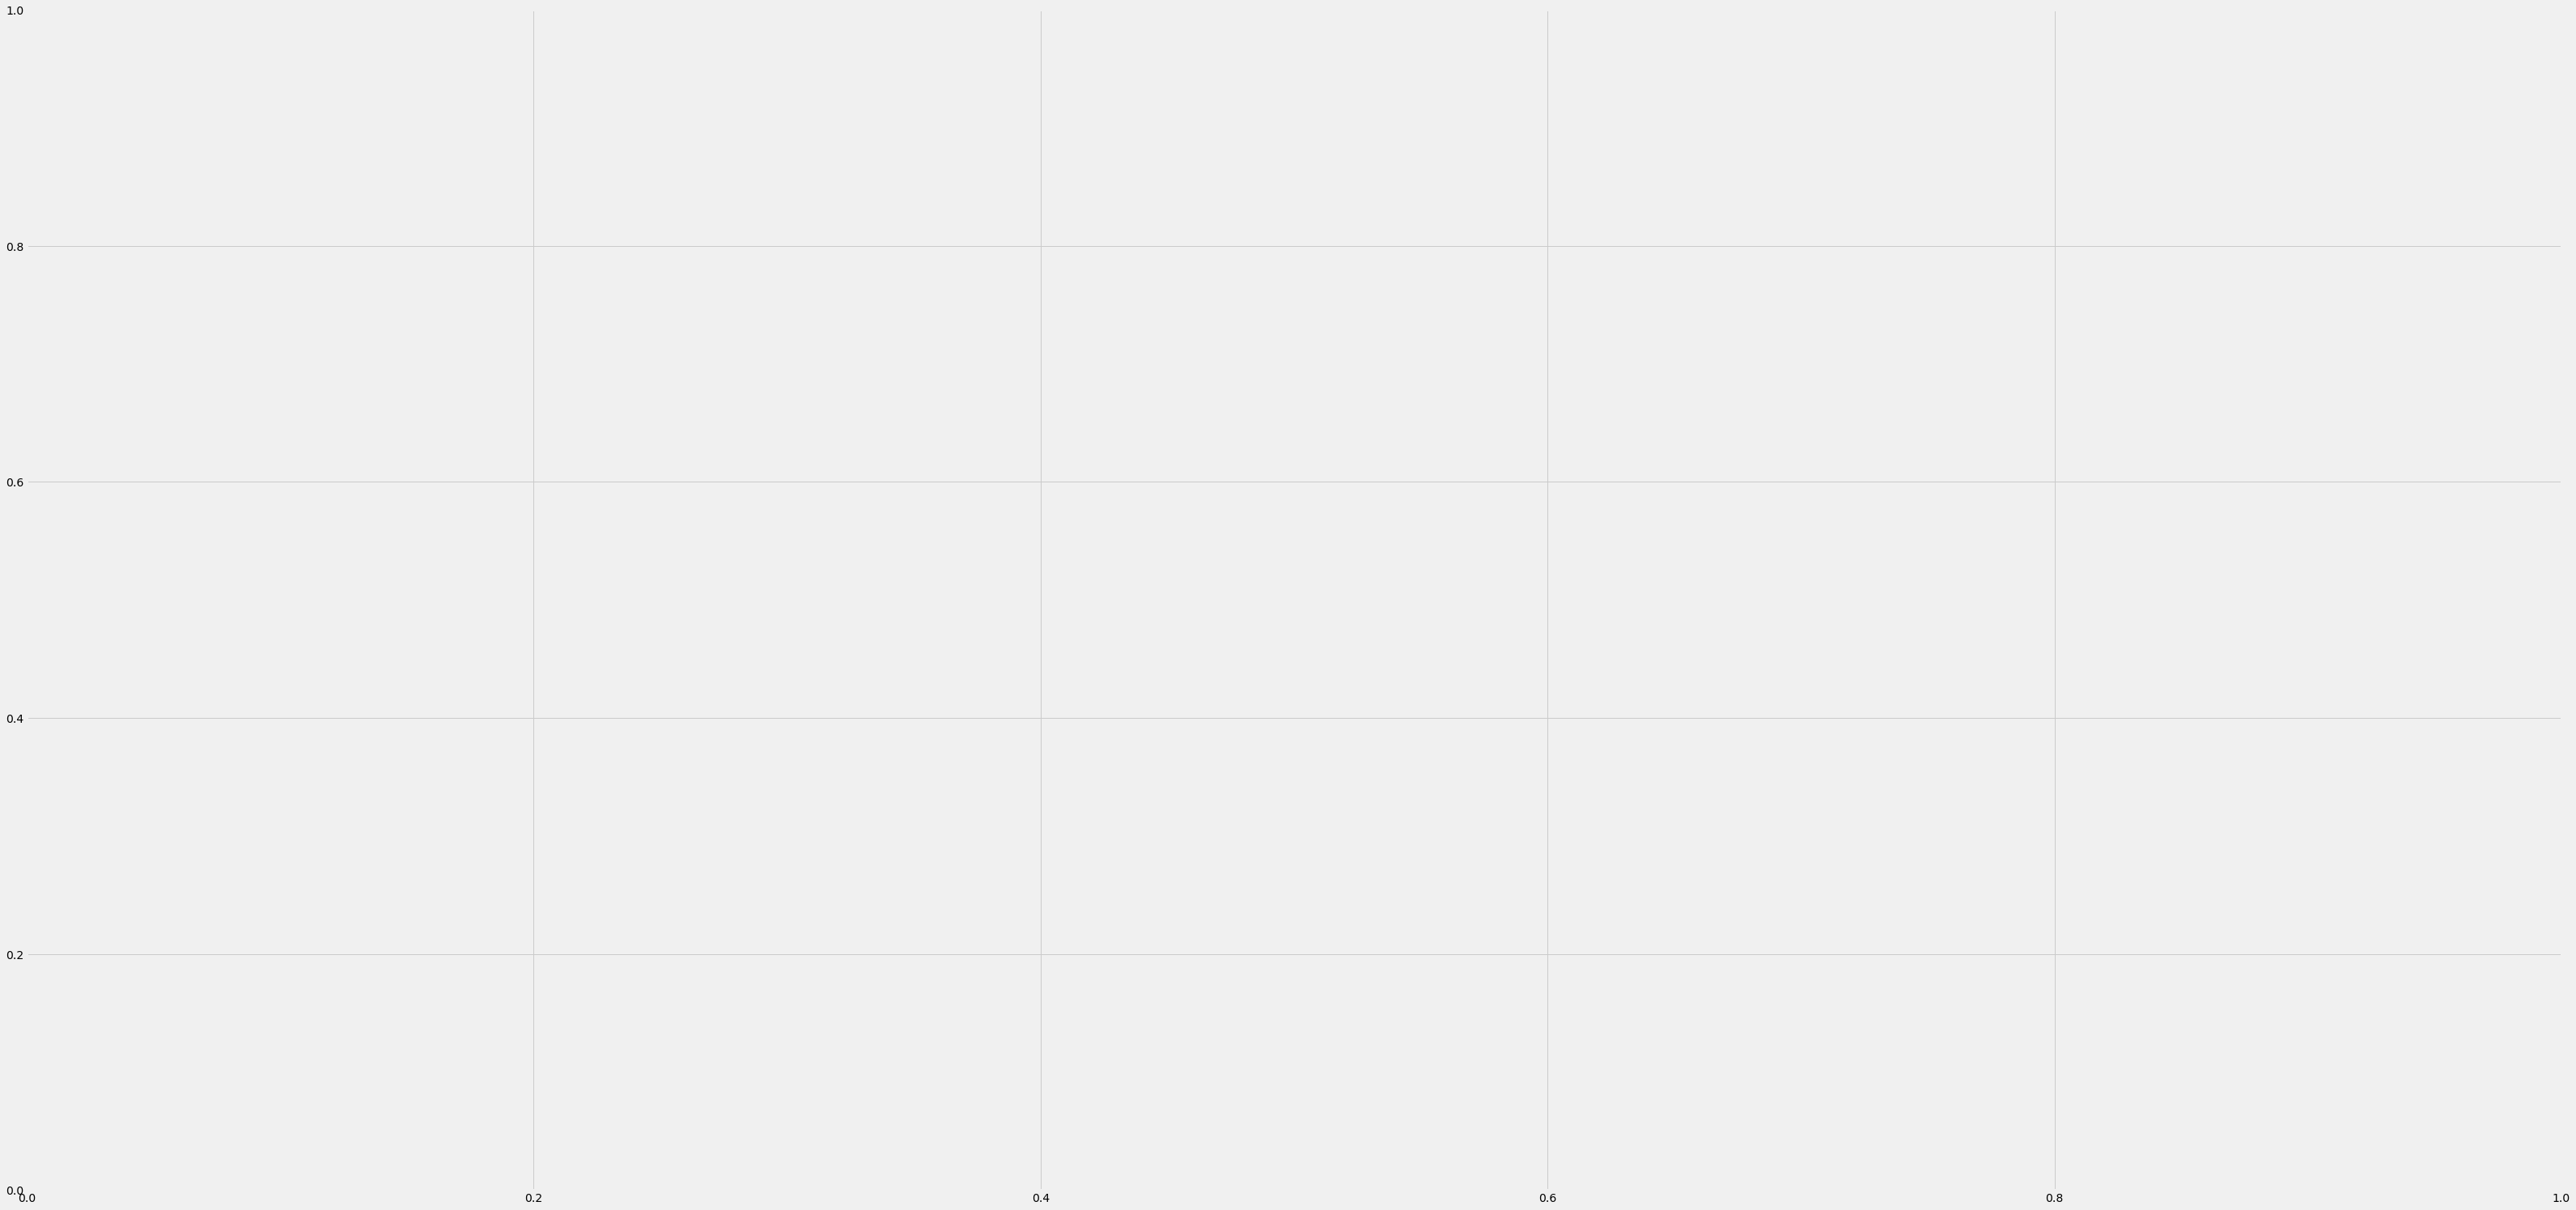

In [193]:
fig, ax = plt.subplots(figsize=(50,25))

p = sns.barplot(data=superhost_df, x = cols, y ='review_scores_rating', color ='brown' );



p.set_ylabel("Score", fontsize = 50)

p.set_xlabel("# of units owned", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

#p.set_title("Frequency of Features in 5 Star Rentals ", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

### <b> Top Feature #2: Communication</b>

In [131]:
communication_metrics = review_metrics.groupby('communication_5_True').mean()
communication_metrics

5_star_True  accuracy_5_True  cleanliness_5_True  \
communication_5_True                                                     
0.0                      0.513803         0.065740            0.071301   
1.0                      0.840000         0.602883            0.529730   

                      checkin_5_True  location_5_True  value_5_True  \
communication_5_True                                                  
0.0                         0.122145         0.135055      0.022642   
1.0                         0.760721         0.611171      0.402523   

                      room_type_Entire home/apt  bedrooms_1_True  \
communication_5_True                                               
0.0                                    0.834359         0.469513   
1.0                                    0.823784         0.437838   

                      bedrooms_2_True  bedrooms_3+_True  ...  \
communication_5_True                                     ...   
0.0                          0.285601          0.244886  ...   
1.0                          0.264505          0.297658  ...   

                      host_listings_11-49_True  host_listings_50+_True  \
communication_5_True                                                     
0.0                                   0.205958                0.093744   
1.0                                   0.124685                0.108108   

                      superhost_True  host_response_100_True  \
communication_5_True                                           
0.0                         0.519960                0.723535   
1.0                         0.497658                0.748829   

                      host_response_90_True  host_response_low_True  \
communication_5_True                                                  
0.0                                0.207746                0.068719   
1.0                                0.158919                0.092252   

                      host_response_time_within a few hours  \
communication_5_True                                          
0.0                                                0.116584   
1.0                                                0.146306   

                      host_response_time_within an hour  room_type_room  \
communication_5_True                                                      
0.0                                            0.823436        0.165641   
1.0                                            0.750631        0.176216   

                      host_response_24hrs+  
communication_5_True                        
0.0                               0.059980  
1.0                               0.103063  

[2 rows x 28 columns]

In [132]:
communication_stats = get_stats(communication_metrics)
communication_stats

communication_5_True                                 Metric       0.0  \
3                                            checkin_5_True  0.122145   
1                                           accuracy_5_True  0.065740   
4                                           location_5_True  0.135055   
2                                        cleanliness_5_True  0.071301   
5                                              value_5_True  0.022642   
0                                               5_star_True  0.513803   
15                                     host_listings_1_True  0.267726   
9                                          bedrooms_3+_True  0.244886   
27                                     host_response_24hrs+  0.059980   
12                                     capacity_couple_True  0.243297   
24                    host_response_time_within a few hours  0.116584   
10                                  bookings_above_avg_True  0.512810   
21                                   host_response_100_True  0.723535   
23                                   host_response_low_True  0.068719   
19                                   host_listings_50+_True  0.093744   
26                                           room_type_room  0.165641   
13                                     capacity_family_True  0.055809   
14                                      capacity_large_True  0.596226   
6                                 room_type_Entire home/apt  0.834359   
16                                   host_listings_2-4_True  0.284211   
8                                           bedrooms_2_True  0.285601   
20                                           superhost_True  0.519960   
7                                           bedrooms_1_True  0.469513   
17                                  host_listings_5-10_True  0.148361   
22                                    host_response_90_True  0.207746   
25                        host_response_time_within an hour  0.823436   
18                                 host_listings_11-49_True  0.205958   
11                                    instant_bookable_True  0.511023   

communication_5_True       1.0     delta  
3                     0.760721  0.638576  
1                     0.602883  0.537143  
4                     0.611171  0.476117  
2                     0.529730  0.458429  
5                     0.402523  0.379881  
0                     0.840000  0.326197  
15                    0.393874  0.126148  
9                     0.297658  0.052772  
27                    0.103063  0.043083  
12                    0.282162  0.038865  
24                    0.146306  0.029722  
10                    0.539099  0.026289  
21                    0.748829  0.025294  
23                    0.092252  0.023533  
19                    0.108108  0.014364  
26                    0.176216  0.010576  
13                    0.059099  0.003290  
14                    0.594955 -0.001271  
6                     0.823784 -0.010576  
16                    0.264505 -0.019706  
8                     0.264505 -0.021096  
20                    0.497658 -0.022303  
7                     0.437838 -0.031676  
17                    0.108829 -0.039533  
22                    0.158919 -0.048827  
25                    0.750631 -0.072805  
18                    0.124685 -0.081274  
11                    0.404685 -0.106338

In [134]:
#communication_plot = plot_stats(communication_stats)
#communication_plot

####  Analysis: 
- Clients that communicate well have significantly better value and accuracy scores than those who don't. 
- It's also noticeable that clients who scored high in communication had under 5 listings, and were less likely to use instant book for their property.
-- My assumption is that they prefer a more "hands on" approach and want to make sure that they are communicating directly to the person booking the property than having the process automated and unpersonalized.

### <b> Top Feature #3: Accuracy </b>

In [128]:
accuracy_metrics = review_metrics.groupby('accuracy_5_True').mean()
accuracy_metrics

5_star_True  cleanliness_5_True  checkin_5_True  \
accuracy_5_True                                                    
0.0                 0.536514            0.084395        0.191182   
1.0                 0.899701            0.668164        0.806387   

                 location_5_True  value_5_True  communication_5_True  \
accuracy_5_True                                                        
0.0                     0.162418      0.028763              0.189804   
1.0                     0.715070      0.530938              0.834830   

                 room_type_Entire home/apt  bedrooms_1_True  bedrooms_2_True  \
accuracy_5_True                                                                
0.0                               0.836893         0.464519         0.287461   
1.0                               0.812375         0.440120         0.250998   

                 bedrooms_3+_True  ...  host_listings_11-49_True  \
accuracy_5_True                    ...                             
0.0                      0.248019  ...                  0.194971   
1.0                      0.308882  ...                  0.125250   

                 host_listings_50+_True  superhost_True  \
accuracy_5_True                                           
0.0                            0.092663        0.538581   
1.0                            0.116766        0.435130   

                 host_response_100_True  host_response_90_True  \
accuracy_5_True                                                  
0.0                            0.737513               0.197210   
1.0                            0.718064               0.170659   

                 host_response_low_True  \
accuracy_5_True                           
0.0                            0.065277   
1.0                            0.111277   

                 host_response_time_within a few hours  \
accuracy_5_True                                          
0.0                                           0.115742   
1.0                                           0.160180   

                 host_response_time_within an hour  room_type_room  \
accuracy_5_True                                                      
0.0                                       0.819497        0.163107   
1.0                                       0.734032        0.187625   

                 host_response_24hrs+  
accuracy_5_True                        
0.0                          0.064761  
1.0                          0.105788  

[2 rows x 28 columns]

In [129]:
accuracy_stats = get_stats(accuracy_metrics)
accuracy_stats

accuracy_5_True                                 Metric       0.0       1.0  \
5                                 communication_5_True  0.189804  0.834830   
2                                       checkin_5_True  0.191182  0.806387   
1                                   cleanliness_5_True  0.084395  0.668164   
3                                      location_5_True  0.162418  0.715070   
4                                         value_5_True  0.028763  0.530938   
0                                          5_star_True  0.536514  0.899701   
15                                host_listings_1_True  0.284189  0.394711   
9                                     bedrooms_3+_True  0.248019  0.308882   
12                                capacity_couple_True  0.244230  0.294411   
23                              host_response_low_True  0.065277  0.111277   
24               host_response_time_within a few hours  0.115742  0.160180   
27                                host_response_24hrs+  0.064761  0.105788   
26                                      room_type_room  0.163107  0.187625   
19                              host_listings_50+_True  0.092663  0.116766   
14                                 capacity_large_True  0.592318  0.605788   
13                                capacity_family_True  0.057182  0.056387   
10                             bookings_above_avg_True  0.523769  0.517465   
21                              host_response_100_True  0.737513  0.718064   
16                              host_listings_2-4_True  0.283155  0.259980   
7                                      bedrooms_1_True  0.464519  0.440120   
6                            room_type_Entire home/apt  0.836893  0.812375   
22                               host_response_90_True  0.197210  0.170659   
8                                      bedrooms_2_True  0.287461  0.250998   
17                             host_listings_5-10_True  0.145022  0.103293   
18                            host_listings_11-49_True  0.194971  0.125250   
25                   host_response_time_within an hour  0.819497  0.734032   
11                               instant_bookable_True  0.496900  0.404691   
20                                      superhost_True  0.538581  0.435130   

accuracy_5_True     delta  
5                0.645027  
2                0.615206  
1                0.583768  
3                0.552652  
4                0.502175  
0                0.363187  
15               0.110522  
9                0.060863  
12               0.050181  
23               0.046000  
24               0.044437  
27               0.041028  
26               0.024518  
19               0.024104  
14               0.013470  
13              -0.000795  
10              -0.006303  
21              -0.019449  
16              -0.023175  
7               -0.024400  
6               -0.024518  
22              -0.026551  
8               -0.036463  
17              -0.041729  
18              -0.069721  
25              -0.085465  
11              -0.092209  
20              -0.103451

#### Analysis: 
- The biggest difference between clients with a perfect accuracy score is that most also had a high <b> value</b> score. (72.8%)
- The next biggest difference was cleanliness. 
- The next step down was communication, checking ,and location.
- Notably, clients with high accuracy scores are significantly less likely to be a superhost, have 5 or more listings, or utilize the instant book feature.
- bookings are below average (-49%)

AttributeError: 'function' object has no attribute 'get'

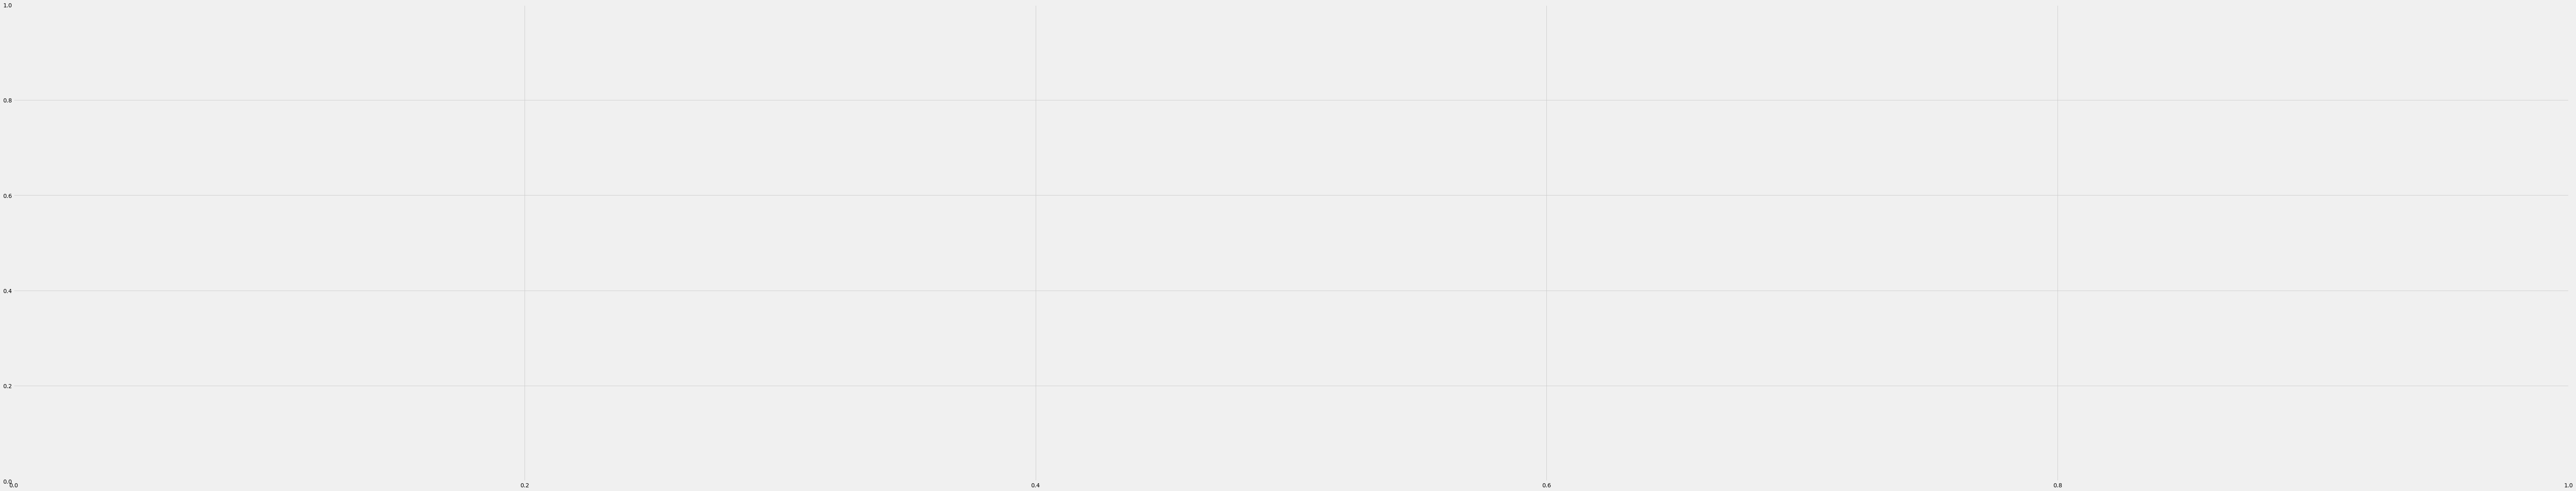

In [130]:
accuracy_plot = plot_stats(accuracy_stats)
accuracy_plot

### <b>Top Feature #4: Cleanliness</b>

In [135]:
cleanliness_metrics = review_metrics.groupby('cleanliness_5_True').mean()
cleanliness_metrics

5_star_True  accuracy_5_True  checkin_5_True  \
cleanliness_5_True                                                 
0.0                    0.553419         0.111185        0.212339   
1.0                    0.879169         0.732094        0.796063   

                    location_5_True  value_5_True  communication_5_True  \
cleanliness_5_True                                                        
0.0                        0.185420      0.042802              0.218191   
1.0                        0.692728      0.533078              0.803718   

                    room_type_Entire home/apt  bedrooms_1_True  \
cleanliness_5_True                                               
0.0                                  0.835145         0.461628   
1.0                                  0.815746         0.447239   

                    bedrooms_2_True  bedrooms_3+_True  ...  \
cleanliness_5_True                                     ...   
0.0                        0.285571          0.252801  ...   
1.0                        0.253691          0.299071  ...   

                    host_listings_11-49_True  host_listings_50+_True  \
cleanliness_5_True                                                     
0.0                                 0.189099                0.092292   
1.0                                 0.137780                0.120284   

                    superhost_True  host_response_100_True  \
cleanliness_5_True                                           
0.0                       0.536031                0.738840   
1.0                       0.433570                0.711864   

                    host_response_90_True  host_response_low_True  \
cleanliness_5_True                                                  
0.0                              0.197291                0.063869   
1.0                              0.167851                0.120284   

                    host_response_time_within a few hours  \
cleanliness_5_True                                          
0.0                                              0.121886   
1.0                                              0.144341   

                    host_response_time_within an hour  room_type_room  \
cleanliness_5_True                                                      
0.0                                          0.813576        0.164855   
1.0                                          0.745216        0.184254   

                    host_response_24hrs+  
cleanliness_5_True                        
0.0                             0.064538  
1.0                             0.110443  

[2 rows x 28 columns]

In [136]:
cleanliness_stats = get_stats(cleanliness_metrics)
cleanliness_stats

cleanliness_5_True                                 Metric       0.0       1.0  \
1                                         accuracy_5_True  0.111185  0.732094   
5                                    communication_5_True  0.218191  0.803718   
2                                          checkin_5_True  0.212339  0.796063   
3                                         location_5_True  0.185420  0.692728   
4                                            value_5_True  0.042802  0.533078   
0                                             5_star_True  0.553419  0.879169   
15                                   host_listings_1_True  0.291256  0.382176   
12                                   capacity_couple_True  0.243103  0.302898   
23                                 host_response_low_True  0.063869  0.120284   
9                                        bedrooms_3+_True  0.252801  0.299071   
27                                   host_response_24hrs+  0.064538  0.110443   
19                                 host_listings_50+_True  0.092292  0.120284   
24                  host_response_time_within a few hours  0.121886  0.144341   
26                                         room_type_room  0.164855  0.184254   
14                                    capacity_large_True  0.593881  0.601968   
13                                   capacity_family_True  0.058184  0.053034   
7                                         bedrooms_1_True  0.461628  0.447239   
6                               room_type_Entire home/apt  0.835145  0.815746   
17                                host_listings_5-10_True  0.140612  0.113723   
21                                 host_response_100_True  0.738840  0.711864   
10                                bookings_above_avg_True  0.528674  0.500820   
22                                  host_response_90_True  0.197291  0.167851   
8                                         bedrooms_2_True  0.285571  0.253691   
16                                 host_listings_2-4_True  0.286741  0.246036   
18                               host_listings_11-49_True  0.189099  0.137780   
25                      host_response_time_within an hour  0.813576  0.745216   
11                                  instant_bookable_True  0.492225  0.411154   
20                                         superhost_True  0.536031  0.433570   

cleanliness_5_True     delta  
1                   0.620909  
5                   0.585527  
2                   0.583724  
3                   0.507308  
4                   0.490276  
0                   0.325750  
15                  0.090920  
12                  0.059795  
23                  0.056415  
9                   0.046270  
27                  0.045905  
19                  0.027992  
24                  0.022455  
26                  0.019398  
14                  0.008088  
13                 -0.005150  
7                  -0.014390  
6                  -0.019398  
17                 -0.026889  
21                 -0.026975  
10                 -0.027854  
22                 -0.029440  
8                  -0.031880  
16                 -0.040705  
18                 -0.051319  
25                 -0.068360  
11                 -0.081072  
20                 -0.102461

### <b>Top Feature #5:  Check-in</b>

In [ ]:
checkin_metrics = review_metrics.groupby('checkin_5_True').sum()
checkin_stats = get_stats(checkin_metrics)
checkin_stats

### <b> Top Feature #6: Value</b>

In [ ]:
value_metrics = review_metrics.groupby('value_5_True').sum()
value_stats = get_stats(value_metrics)
value_stats

### Analysis
- Clients that have a perfect cleanliness score score high in all the other review metrics, most notably Value, and Accuracy.
- However, the bigger factors are that they aren't likely to manage 5 or more listings, be instant bookable, or a superhost.
-- My assumption is that they can keep their rental(s) clean because they don't have more than they can handle, and they 

In [ ]:
cleanliness_plot = plot_stats(cleanliness_stats)
cleanliness_plot

### <b> 5 Star Unit Stats </b>

In [ ]:
five_star_metrics = review_metrics.groupby('5_star_True').sum()
five_star_metrics

In [ ]:
five_star_stats = get_stats(five_star_metrics)
five_star_stats

### Analysis: 
- 5 Star Overall units score much higher in review metrics. This makes sense because they should have to score high in all of them to get a high overall score (even though it is a seperate metric in terms of AirBnb).
- Noteably, they are significantly less likely to use instant book, have more than 5 listings, or be a superhost.

In [ ]:
five_star_plot = plot_stats(five_star_stats)
five_star_plot

### Instant Bookable Stats

In [ ]:
instant_book_metrics = review_metrics.groupby('instant_bookable_True').sum()
instant_book_metrics

In [ ]:
instant_book_stats = get_stats(instant_book_metrics)
instant_book_stats

In [ ]:
instant_book_plot = plot_stats(instant_book_stats)
instant_book_plot

### Bookings Above Average Stats

In [ ]:
booked_metrics = review_metrics.groupby('bookings_above_avg_True').sum()
booked_metrics

In [ ]:
booked_stats = get_stats(booked_metrics)
booked_stats

#### Analysis:
- 5_star units and superhosts have about the same increase in bookings above average.
- Also, having low listings (4 or less).
-- 5-49 listings is lower, HOWEVER nowhere near a bad as 50+

In [ ]:
booked_plot = plot_stats(booked_stats)
booked_plot

In [146]:
analysis_df.head()

price  review_scores_rating  review_scores_accuracy  \
0   60.0                  5.00                    5.00   
1  282.0                  4.87                    4.91   
2  348.0                  4.92                    5.00   
3  368.0                  4.88                    4.96   
4  264.0                  5.00                    5.00   

   review_scores_cleanliness  review_scores_checkin  \
0                       5.00                   5.00   
1                       4.64                   4.99   
2                       4.92                   5.00   
3                       4.96                   5.00   
4                       4.75                   4.75   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         5.00                    4.00                 5.00   
1                         4.98                    4.87                 4.86   
2                         5.00                    4.92                 4.92   
3                         5.00                    4.75                 4.71   
4                         4.75                    5.00                 4.75   

   accommodates  bedrooms  ...  host_response_90  host_response_low superhost  \
0             2       1.0  ...             False              False     False   
1             6       3.0  ...             False              False      True   
2             2       1.0  ...             False              False      True   
3             6       3.0  ...             False              False      True   
4             4       1.0  ...             False              False      True   

  5_star accuracy_5  cleanliness_5  checkin_5  location_5  value_5  \
0   True       True           True       True       False     True   
1   True      False          False      False       False    False   
2   True       True          False       True       False    False   
3   True      False          False       True       False    False   
4   True       True          False      False        True    False   

   communication_5  
0             True  
1            False  
2             True  
3             True  
4            False  

[5 rows x 46 columns]

In [160]:
analysis_df['calculated_host_listings_count'].value_counts()

1      2441
2      1109
3       627
4       429
5       315
7       211
219     193
8       168
6       162
19      120
13      108
10      100
14       98
9        93
163      93
119      88
15       77
39       77
27       76
73       69
12       69
37       68
31       66
25       63
11       61
23       61
68       60
65       58
21       52
58       49
55       48
51       47
22       45
42       40
16       38
47       38
29       35
36       35
62       31
35       30
17       28
26       26
76       25
28       25
18       25
20       17
61       11
48        5
Name: calculated_host_listings_count, dtype: int64

In [161]:
host_listings = analysis_df[analysis_df['calculated_host_listings_count'] <= 50]

In [174]:
host_listings = host_listings.sort_values('calculated_host_listings_count', ascending=True)

In [176]:
host_listings['calculated_host_listings_count'].value_counts()

1     2441
2     1109
3      627
4      429
5      315
7      211
8      168
6      162
19     120
13     108
10     100
14      98
9       93
39      77
15      77
27      76
12      69
37      68
31      66
25      63
11      61
23      61
21      52
22      45
42      40
16      38
47      38
36      35
29      35
35      30
17      28
26      26
28      25
18      25
20      17
48       5
Name: calculated_host_listings_count, dtype: int64

## <b> LinePlot: Review Scores vs. number of units hosted </b>

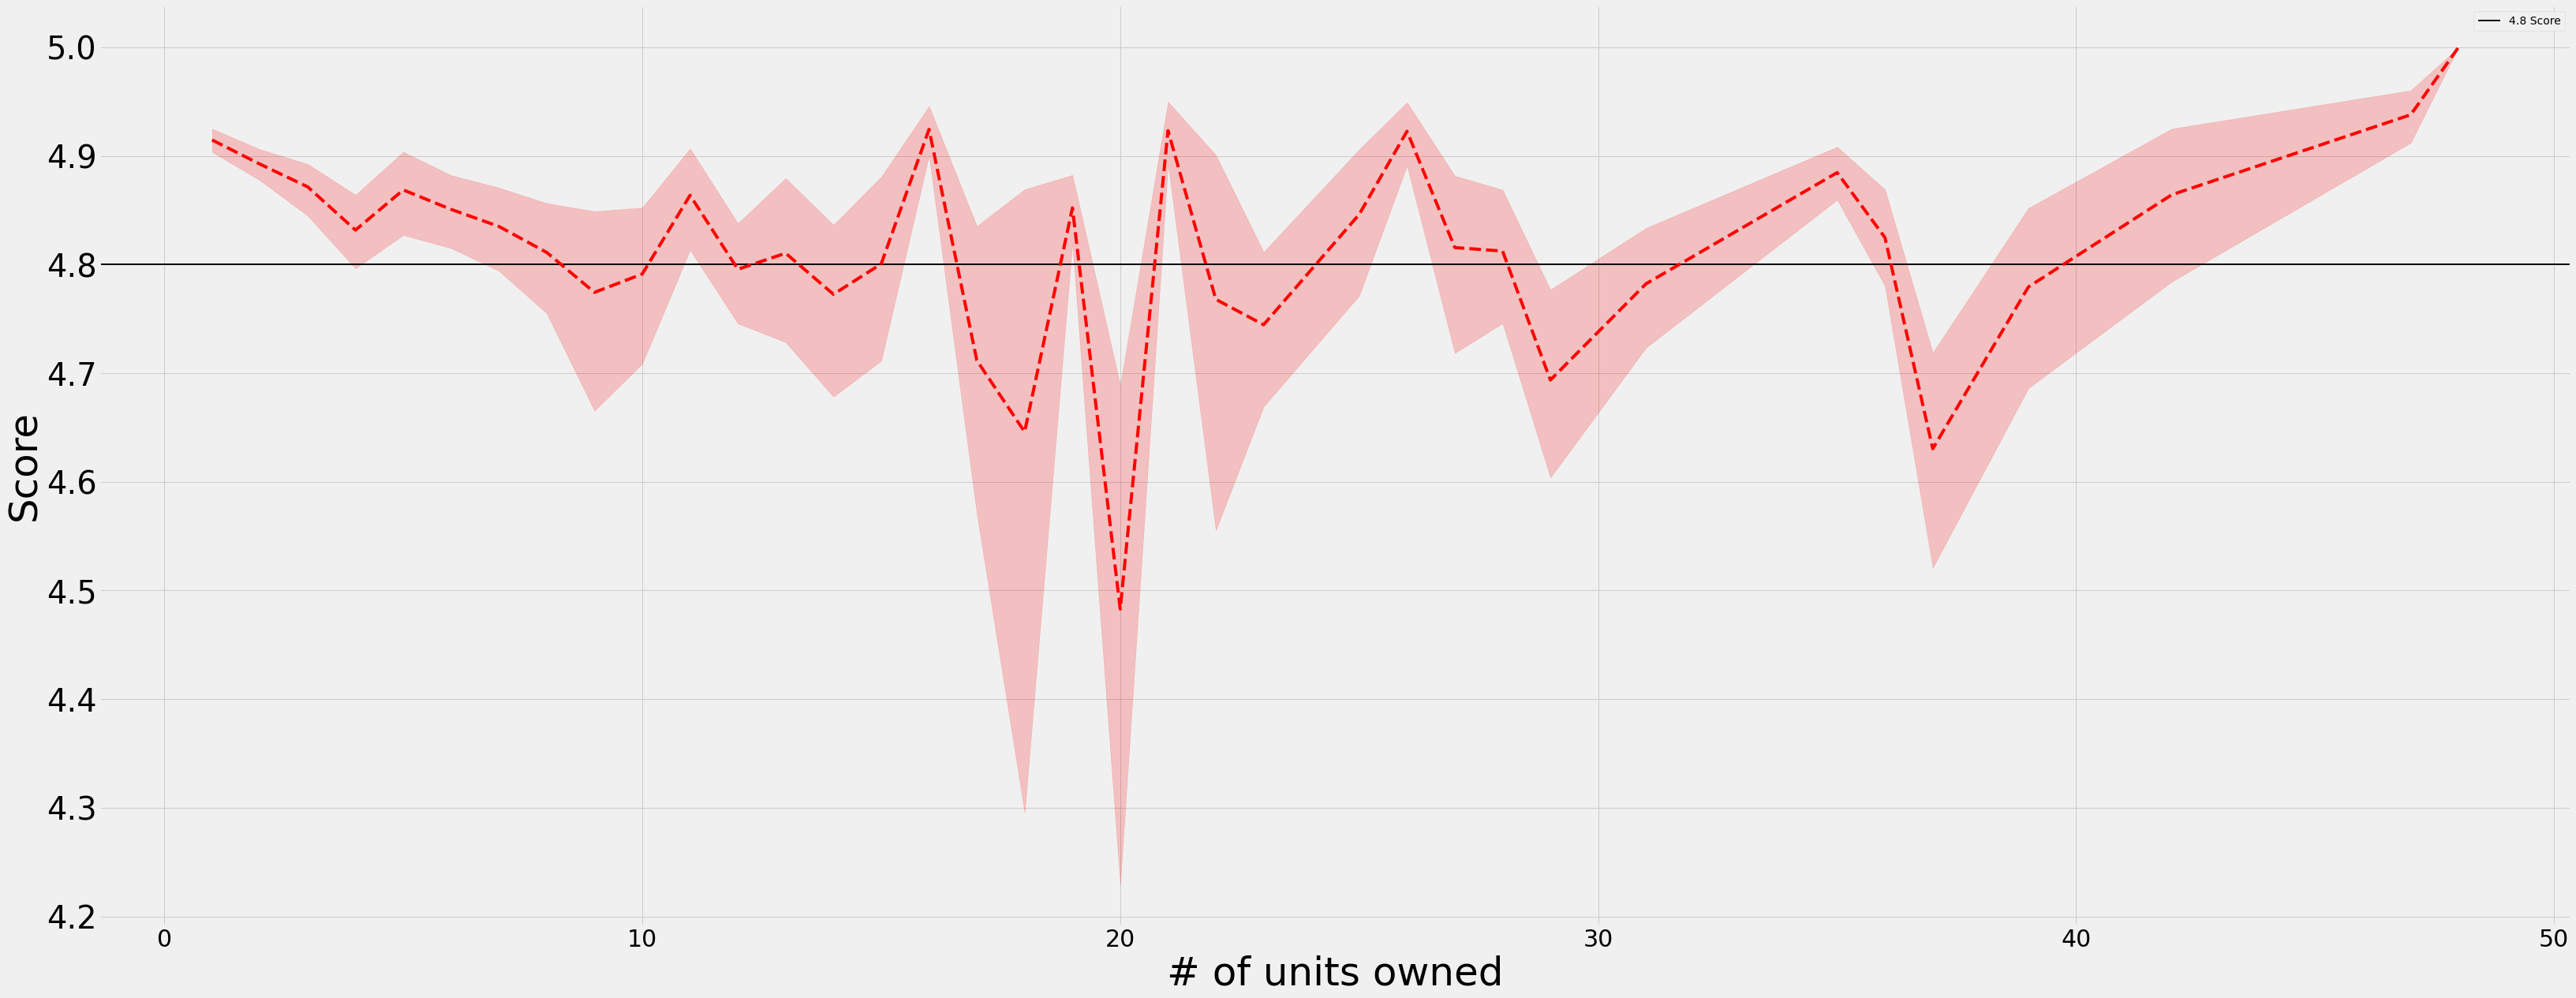

In [236]:
fig, ax = plt.subplots(figsize=(50,20))

ax.axhline(4.8, color='black', linewidth=(2), label='4.8 Score')
#p = sns.lineplot(data=host_listings, x='calculated_host_listings_count', y='review_scores_cleanliness',
#                 ls = '--', color ='blue' );
p = sns.lineplot(data=host_listings, x='calculated_host_listings_count', y='review_scores_communication',
                 ls = '--', color ='red' );
#p = sns.lineplot(data=host_listings, x='calculated_host_listings_count', y='review_scores_accuracy',
#                 ls = '--', color ='green' );
#p = sns.lineplot(data=host_listings, x='calculated_host_listings_count', y='review_scores_value',
#                 ls = '--', color ='purple' );
#p = sns.lineplot(data=host_listings, x='calculated_host_listings_count', y='review_scores_checkin',
#                 ls = '--', color ='brown' );



p.set_ylabel("Score", fontsize = 50)

p.set_xlabel("# of units owned", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

#p.set_title("Frequency of Features in 5 Star Rentals ", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

In [ ]:
fig, ax = plt.subplots(figsize=(50,20))


p = sns.lineplot(data=five_star_stats, x='Metric', y='delta', color ='red' );
p = sns.lineplot(data=communication_stats, x='Metric', y='delta', color ='green' );
p = sns.lineplot(data=accuracy_stats, x='Metric', y='delta', color ='blue' );
p = sns.lineplot(data=cleanliness_stats, x='Metric', y='delta', color ='black' );
p = sns.lineplot(data=superhost_stats, x='Metric', y='delta', color ='purple' );
p = sns.lineplot(data=instant_book_stats, x='Metric', y='delta', color ='brown' );




p.set_ylabel("Percentage of 5 Star Rentals", fontsize = 50)

p.set_xlabel("Feature", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

p.set_title("Frequency of Features in 5 Star Rentals ", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

## Questions Answered

- Is there a significant advantage to being a Superhost? (is it worth all the effort to get this status and maintain it?)
- <b> YES!.</b>
- The benefits of being a 5 Star overall host, vs not being one. (again, is it worth all the work to have 5 Star overall rating)
- <b> SIMILAR TO SUPERHOST</B>
- What factors are most important in determining a 5 Star Overall Rating? (what aspects should they most focus on)

## Recommendations

- AIRBNB IS A CUSTOMER SERVICE INDUSTRY!
- <b>Don't have more properties than you can manage to the highest level of quality</b>.
-- sweet spot seems to be 2-4 properties.
-- hire help.

- Interface directly with your clients, and don't use instant booking.
- Be incredibly accurate in listing and communication with guests.
- Communicate well.
-- including communication about airbnbs system.
- Strive to be a superhost, but make sure that you are striving for the highest degree of quality as well.


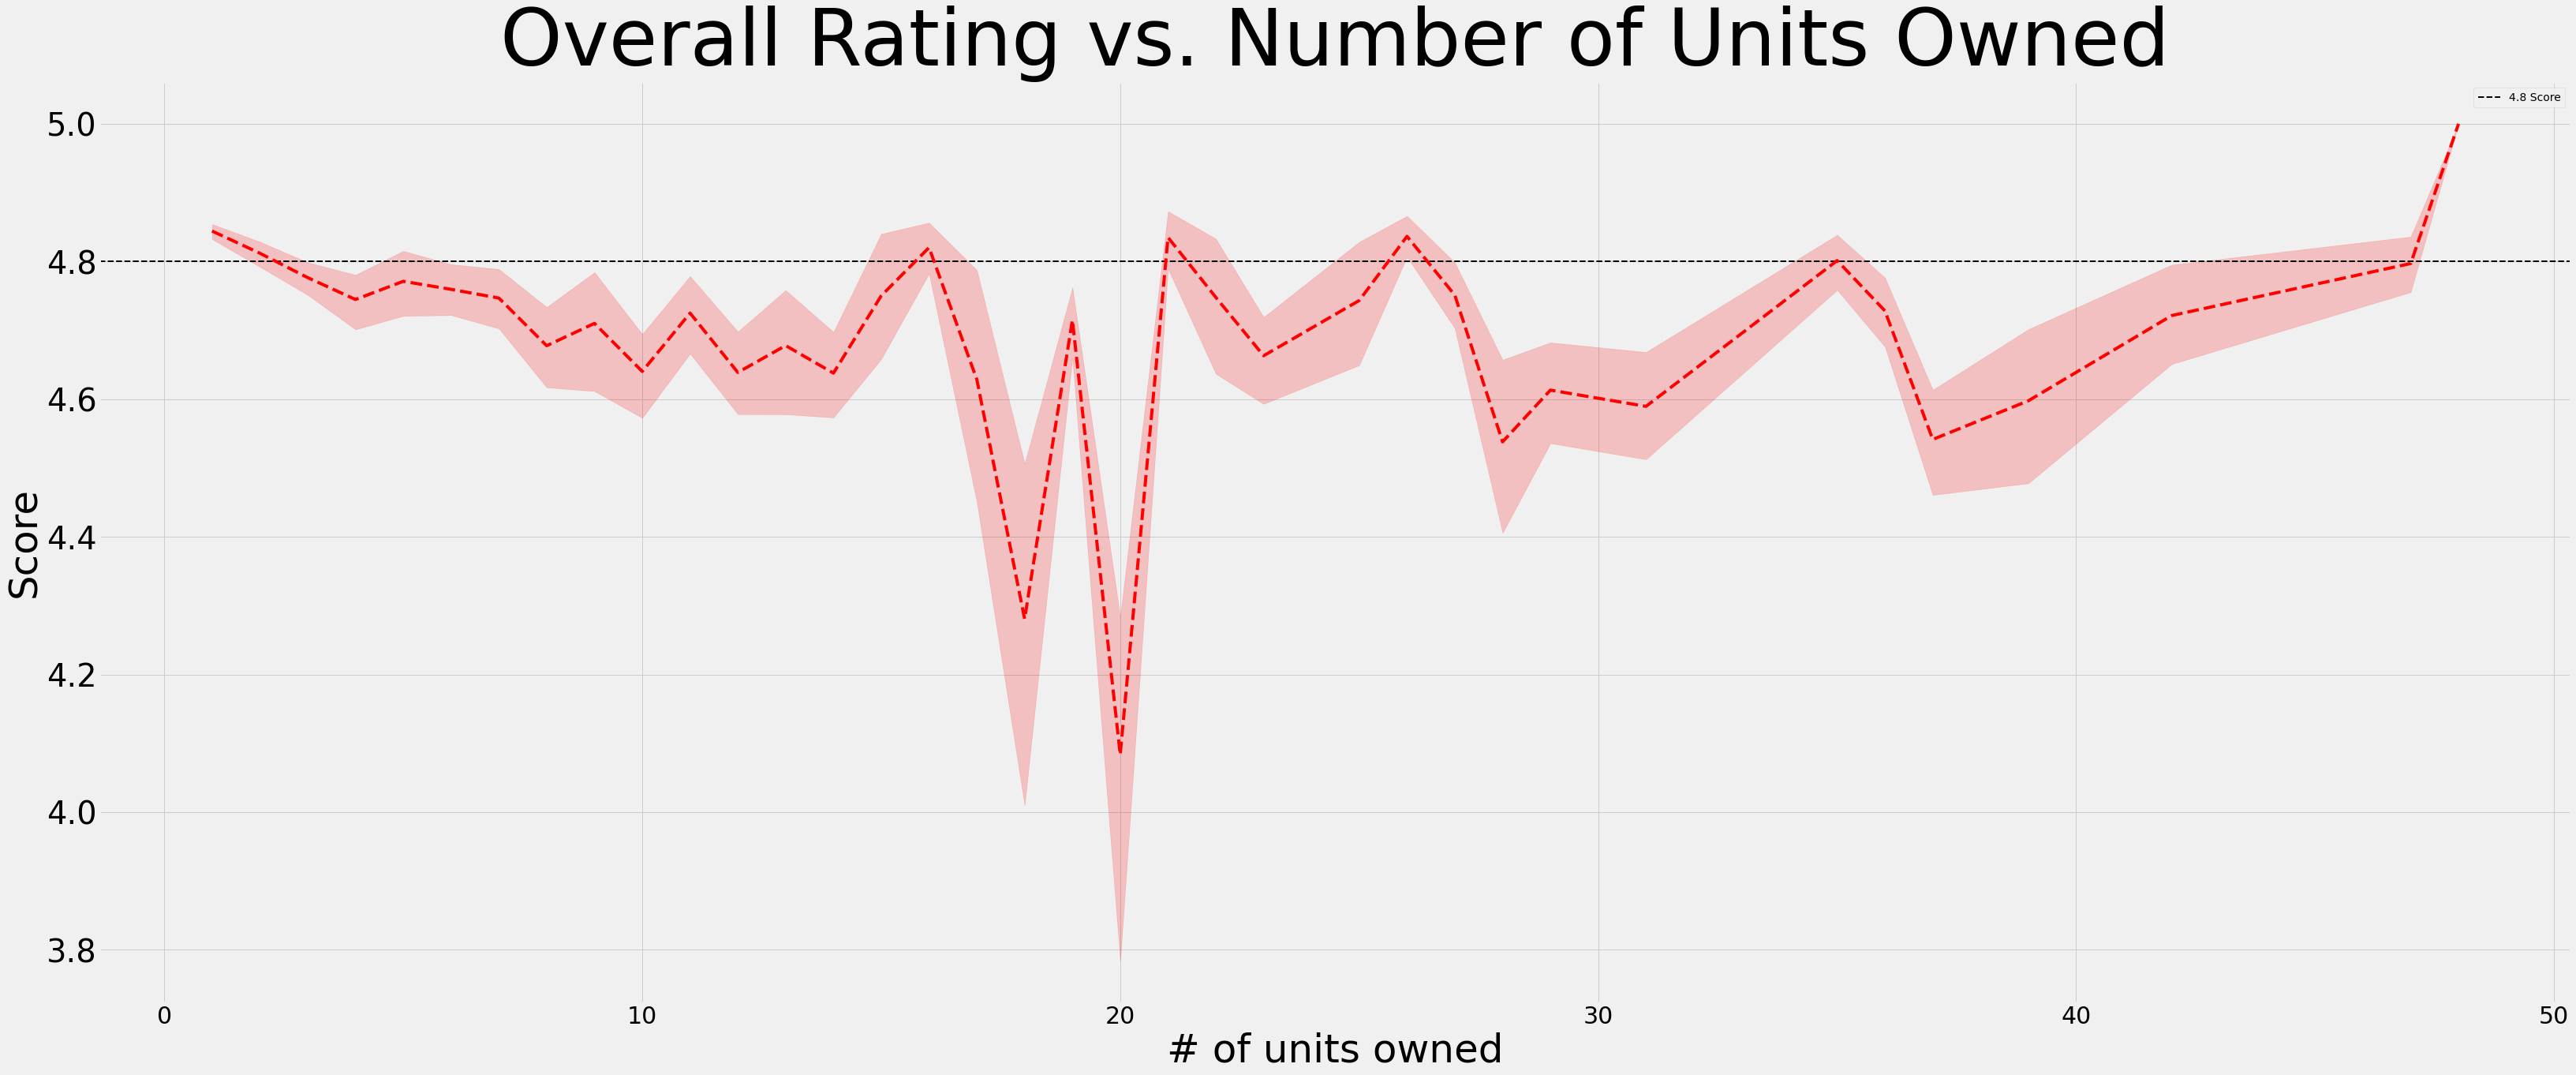

In [204]:
fig, ax = plt.subplots(figsize=(50,20))

ax.axhline(4.8, ls='--', color='black', linewidth=(2), label='4.8 Score')


#p = sns.lineplot(data=host_listings, x='calculated_host_listings_count', y='review_scores_cleanliness',
#                 ls = '--', color ='blue' );
#p = sns.lineplot(data=host_listings, x='calculated_host_listings_count', y='review_scores_communication',
#                 ls = '--', color ='black' );
#p = sns.lineplot(data=host_listings, x='calculated_host_listings_count', y='review_scores_accuracy',
#                 ls = '--', color ='green' );
#p = sns.lineplot(data=host_listings, x='calculated_host_listings_count', y='review_scores_value',
#                 ls = '--', color ='purple' );
#p = sns.lineplot(data=host_listings, x='calculated_host_listings_count', y='review_scores_checkin',
#                 ls = '--', color ='brown' );
p = sns.lineplot(data=host_listings, x='calculated_host_listings_count', y='review_scores_rating',
                 ls = '--', color ='red' );



p.set_ylabel("Score", fontsize = 50)

p.set_xlabel("# of units owned", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

p.set_title( "Overall Rating vs. Number of Units Owned", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

### <b> #1: Don't host more properties than you can manage to the highest level of quality. </b>
- There is a general downward trend in overall rating as the number of units owned increases. 
- The bottom drops out between 12? and 20 before picking up again.
- I interpret these spikes to show when there are enough units owned to justify bringing in more help in managing them.
- As OPM will mainly be advising owners who are doing everything on their own, I would caution against having more than they can handle to the highest level of excellance.
-- or they should get help in managing their units.

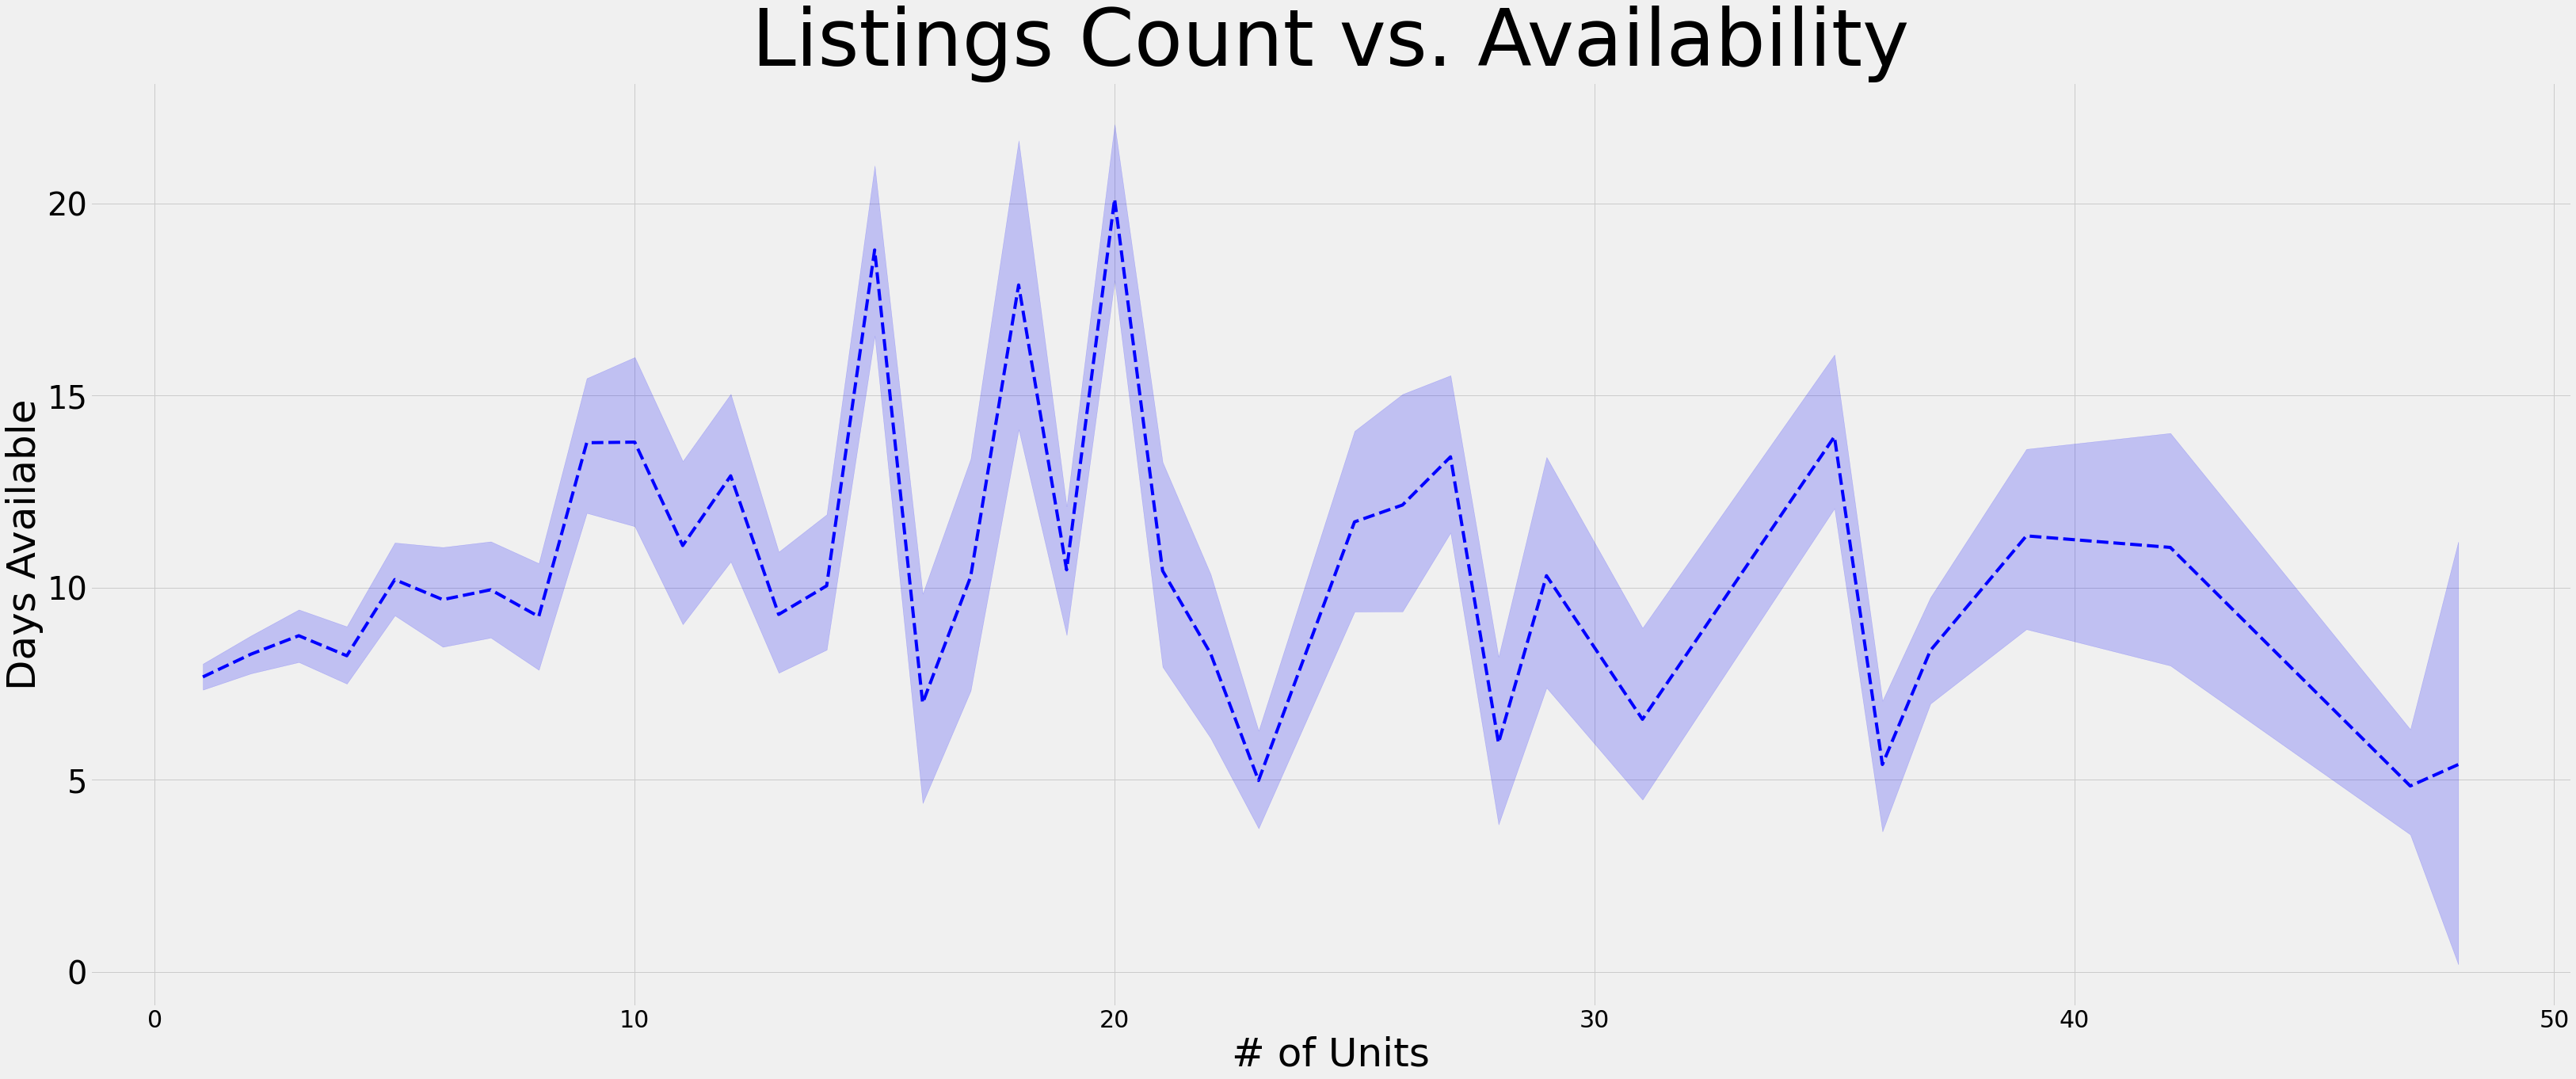

In [255]:
fig, ax = plt.subplots(figsize=(50,20))

#ax.axhline(4.8, ls='--', color='black', linewidth=(2), label='4.8 Score')


p = sns.lineplot(data=host_listings, x='calculated_host_listings_count', y='availability_30',
                 ls = '--', color ='blue' );

#p = sns.lineplot(data=superhost_df, x='calculated_host_listings_count', y='review_scores_cleanliness',
#                 ls = '--', color ='green' );

#p = sns.lineplot(data=instant_bookable_df, x='calculated_host_listings_count', y='review_scores_cleanliness',
#                 ls = '--', color ='red' );


p.set_ylabel("Days Available", fontsize = 50)

p.set_xlabel("# of Units", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

p.set_title( "Listings Count vs. Availability", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

### <b> #2: Make 5 Star Reviews Your Priority, Get Superhost Status if Possible</b>
- superhosts show far more consistancy across the board. (ie, having a higher # of rentals does not impact them as much, even though there is an impact)

In [274]:
five_star_df = analysis_df[analysis_df['5_star']== True]

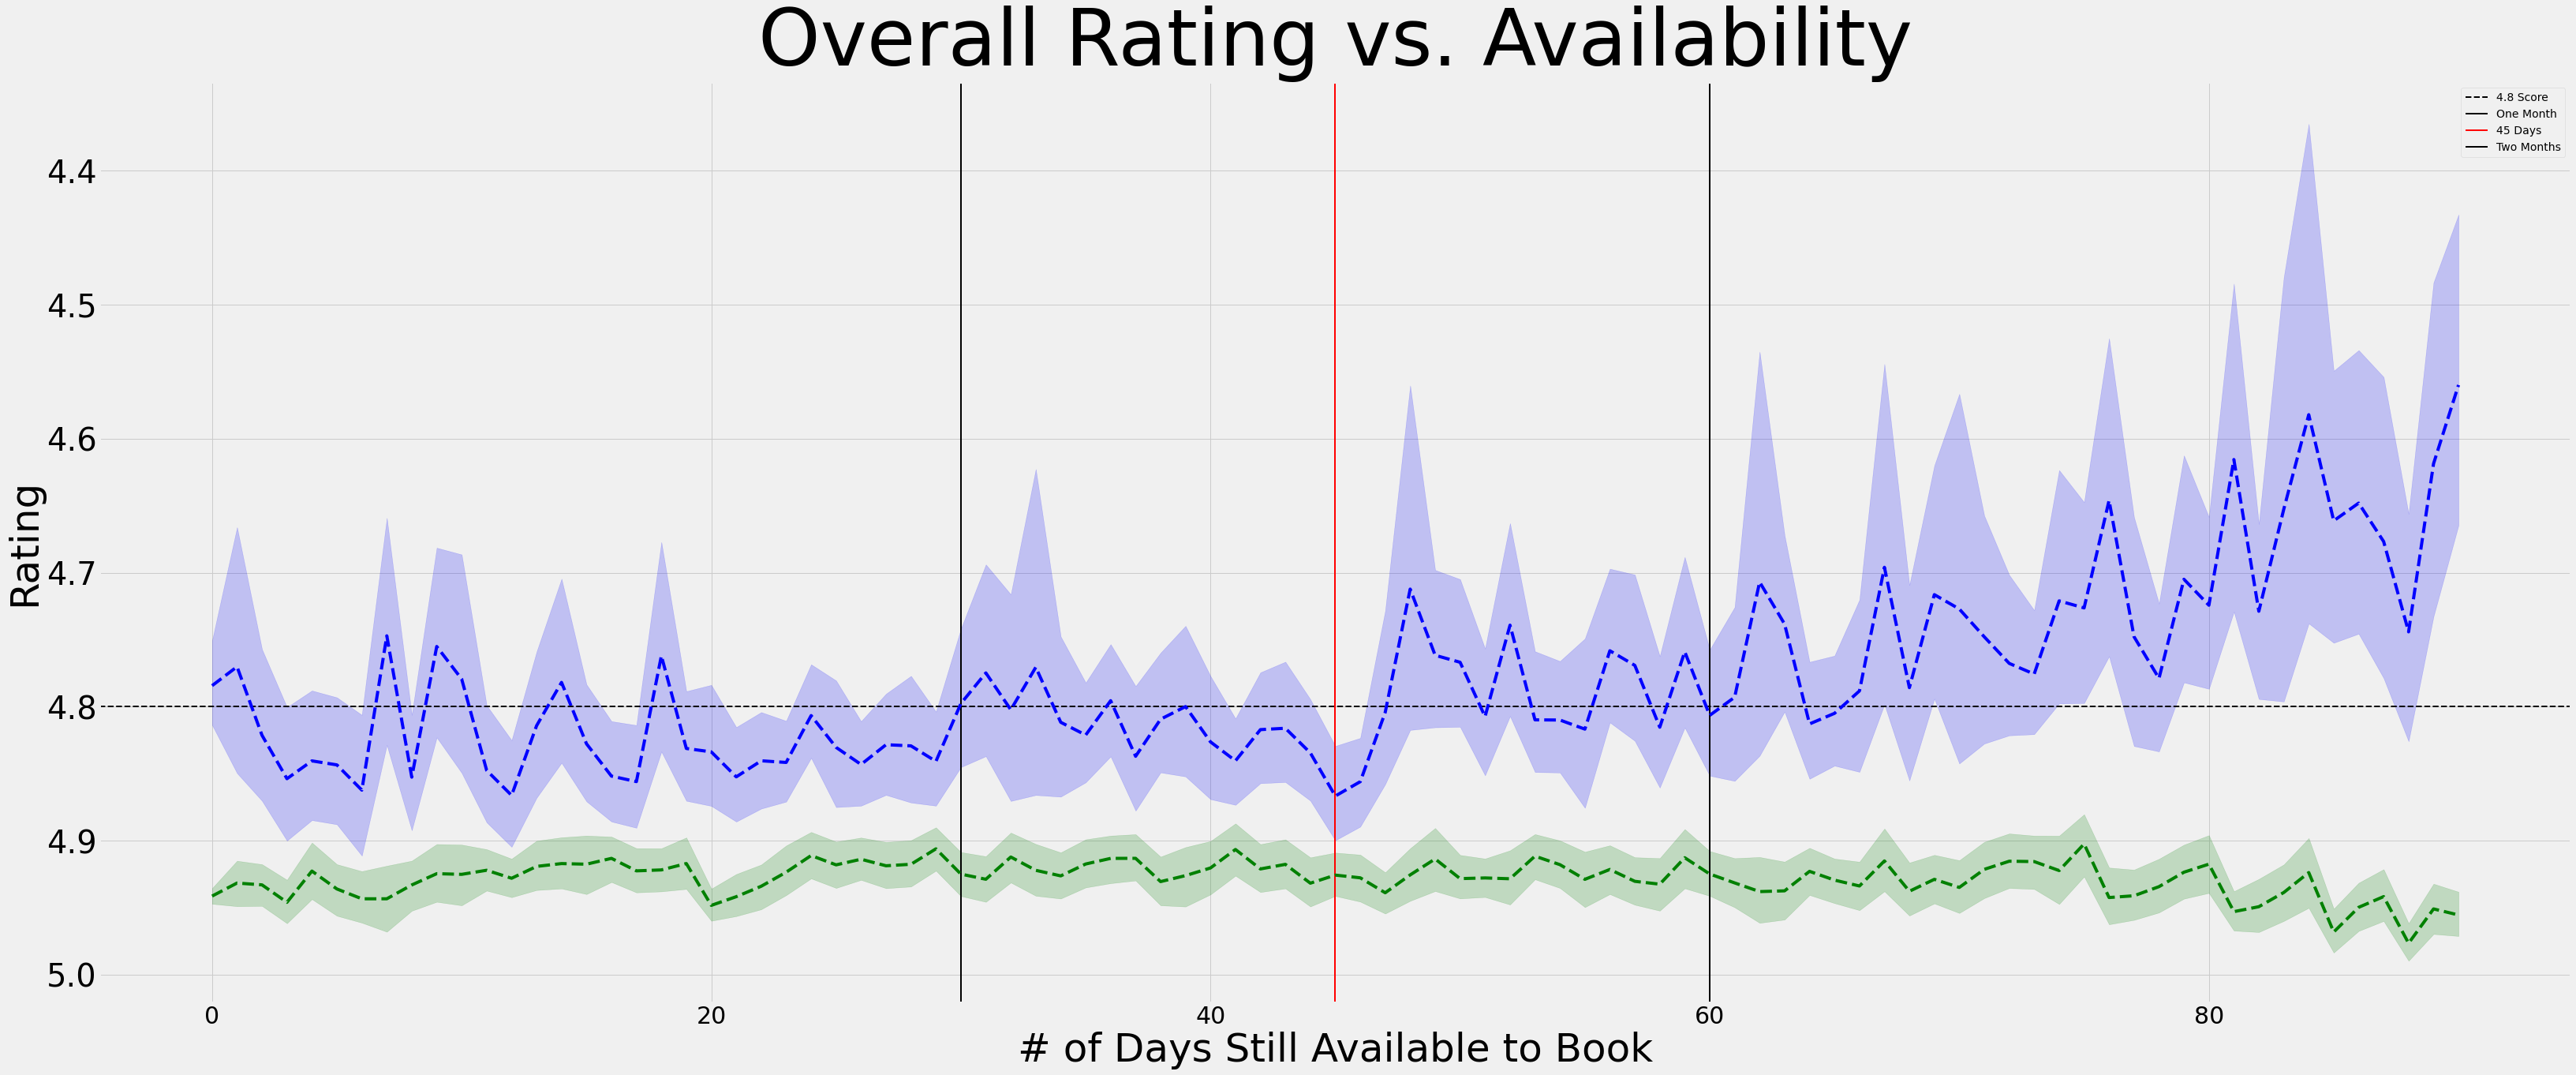

In [280]:
fig, ax = plt.subplots(figsize=(50,20))

ax.axhline(4.8, ls='--', color='black', linewidth=(2), label='4.8 Score')
ax.axvline(30 , color='black', linewidth=(2), label='One Month')
ax.axvline(45 , color='red', linewidth=(2), label='45 Days')
ax.axvline(60 , color='black', linewidth=(2), label='Two Months')

ax.invert_yaxis()


p = sns.lineplot(data=host_listings, x='availability_90', y='review_scores_rating',
                 ls = '--', color ='blue' );

p = sns.lineplot(data=five_star_df, x='availability_90', y='review_scores_rating',
                 ls = '--', color ='green' );

#p = sns.lineplot(data=superhost_df, x='calculated_host_listings_count', y='review_scores_cleanliness',
#                 ls = '--', color ='green' );

#p = sns.lineplot(data=instant_bookable_df, x='calculated_host_listings_count', y='review_scores_cleanliness',
#                 ls = '--', color ='red' );


p.set_ylabel("Rating", fontsize = 50)

p.set_xlabel("# of Days Still Available to Book", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

p.set_title( "Overall Rating vs. Availability", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

In [282]:
five_star_df['availability_90'].mean()

40.631964213094754

In [283]:
analysis_df['availability_90'].mean()

43.419846350832266

In [244]:
host_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7038 entries, 0 to 1493
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           7038 non-null   float64
 1   review_scores_rating            7038 non-null   float64
 2   review_scores_accuracy          7038 non-null   float64
 3   review_scores_cleanliness       7038 non-null   float64
 4   review_scores_checkin           7038 non-null   float64
 5   review_scores_communication     7038 non-null   float64
 6   review_scores_location          7038 non-null   float64
 7   review_scores_value             7038 non-null   float64
 8   accommodates                    7038 non-null   int64  
 9   bedrooms                        7038 non-null   float64
 10  beds                            7038 non-null   float64
 11  instant_bookable                7038 non-null   bool   
 12  property_type                   70

### <b> #3: Communication is Critical in Setting Guest Expectations!</b>
- accurate listing
- explanation of airbnb's skewed review system.
- do this without being deceptive or cooercive.

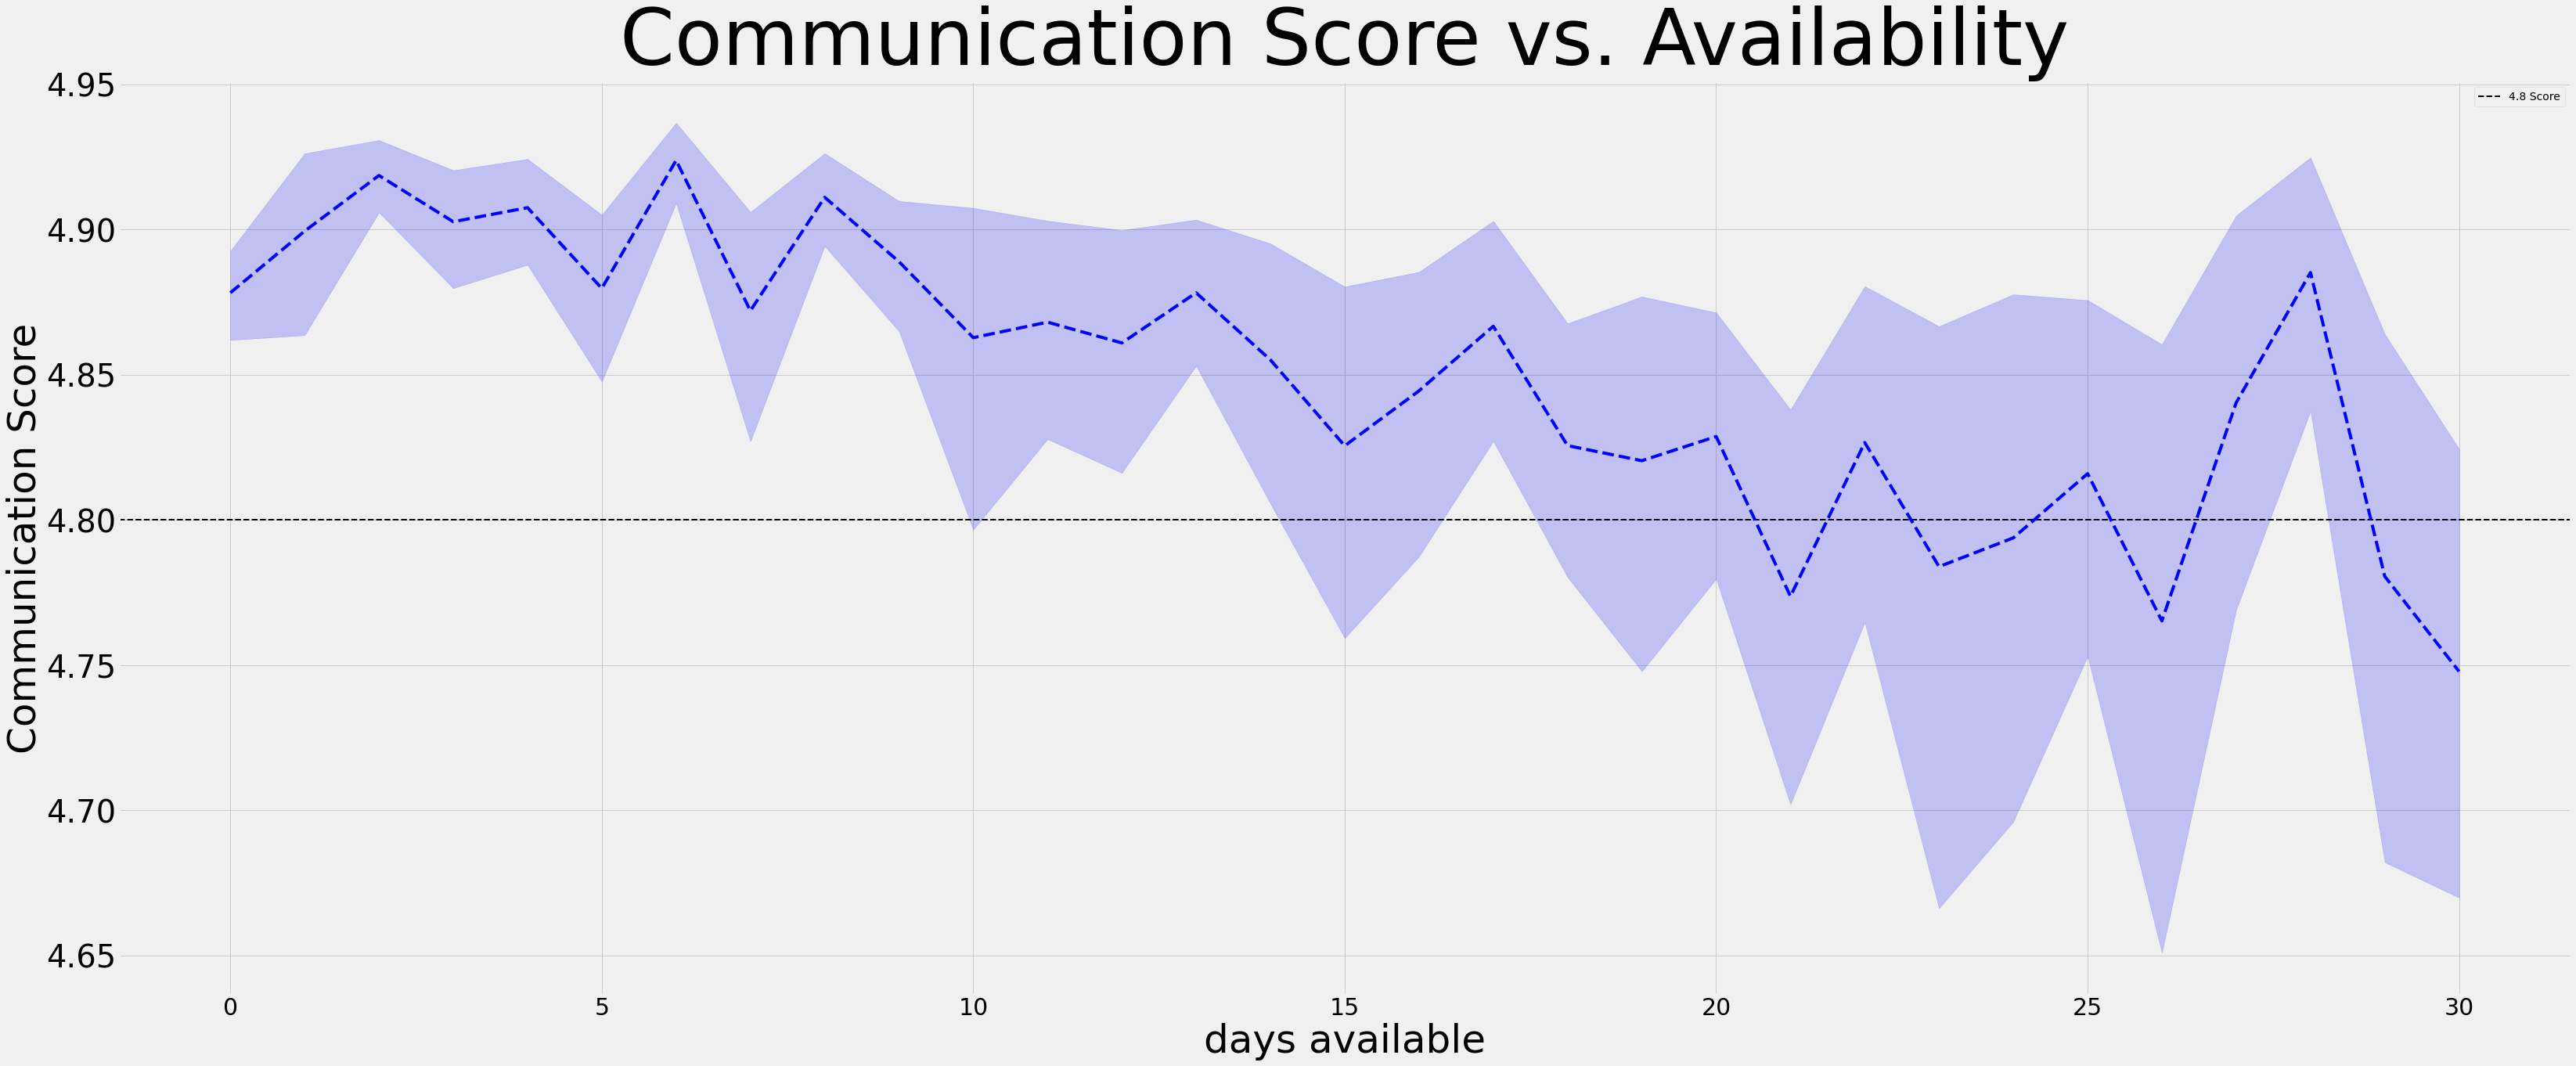

In [287]:
fig, ax = plt.subplots(figsize=(50,20))

ax.axhline(4.8, ls='--', color='black', linewidth=(2), label='4.8 Score')


p = sns.lineplot(data=host_listings, x='availability_30', y='review_scores_communication',
                 ls = '--', color ='blue' );

#p = sns.lineplot(data=superhost_df, x='calculated_host_listings_count', y='review_scores_cleanliness',
#                 ls = '--', color ='green' );

#p = sns.lineplot(data=instant_bookable_df, x='calculated_host_listings_count', y='review_scores_cleanliness',
#                 ls = '--', color ='red' );


p.set_ylabel("Communication Score", fontsize = 50)

p.set_xlabel("days available", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

p.set_title( "Communication Score vs. Availability", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

### <b> #4: Keep everything clean!</b>

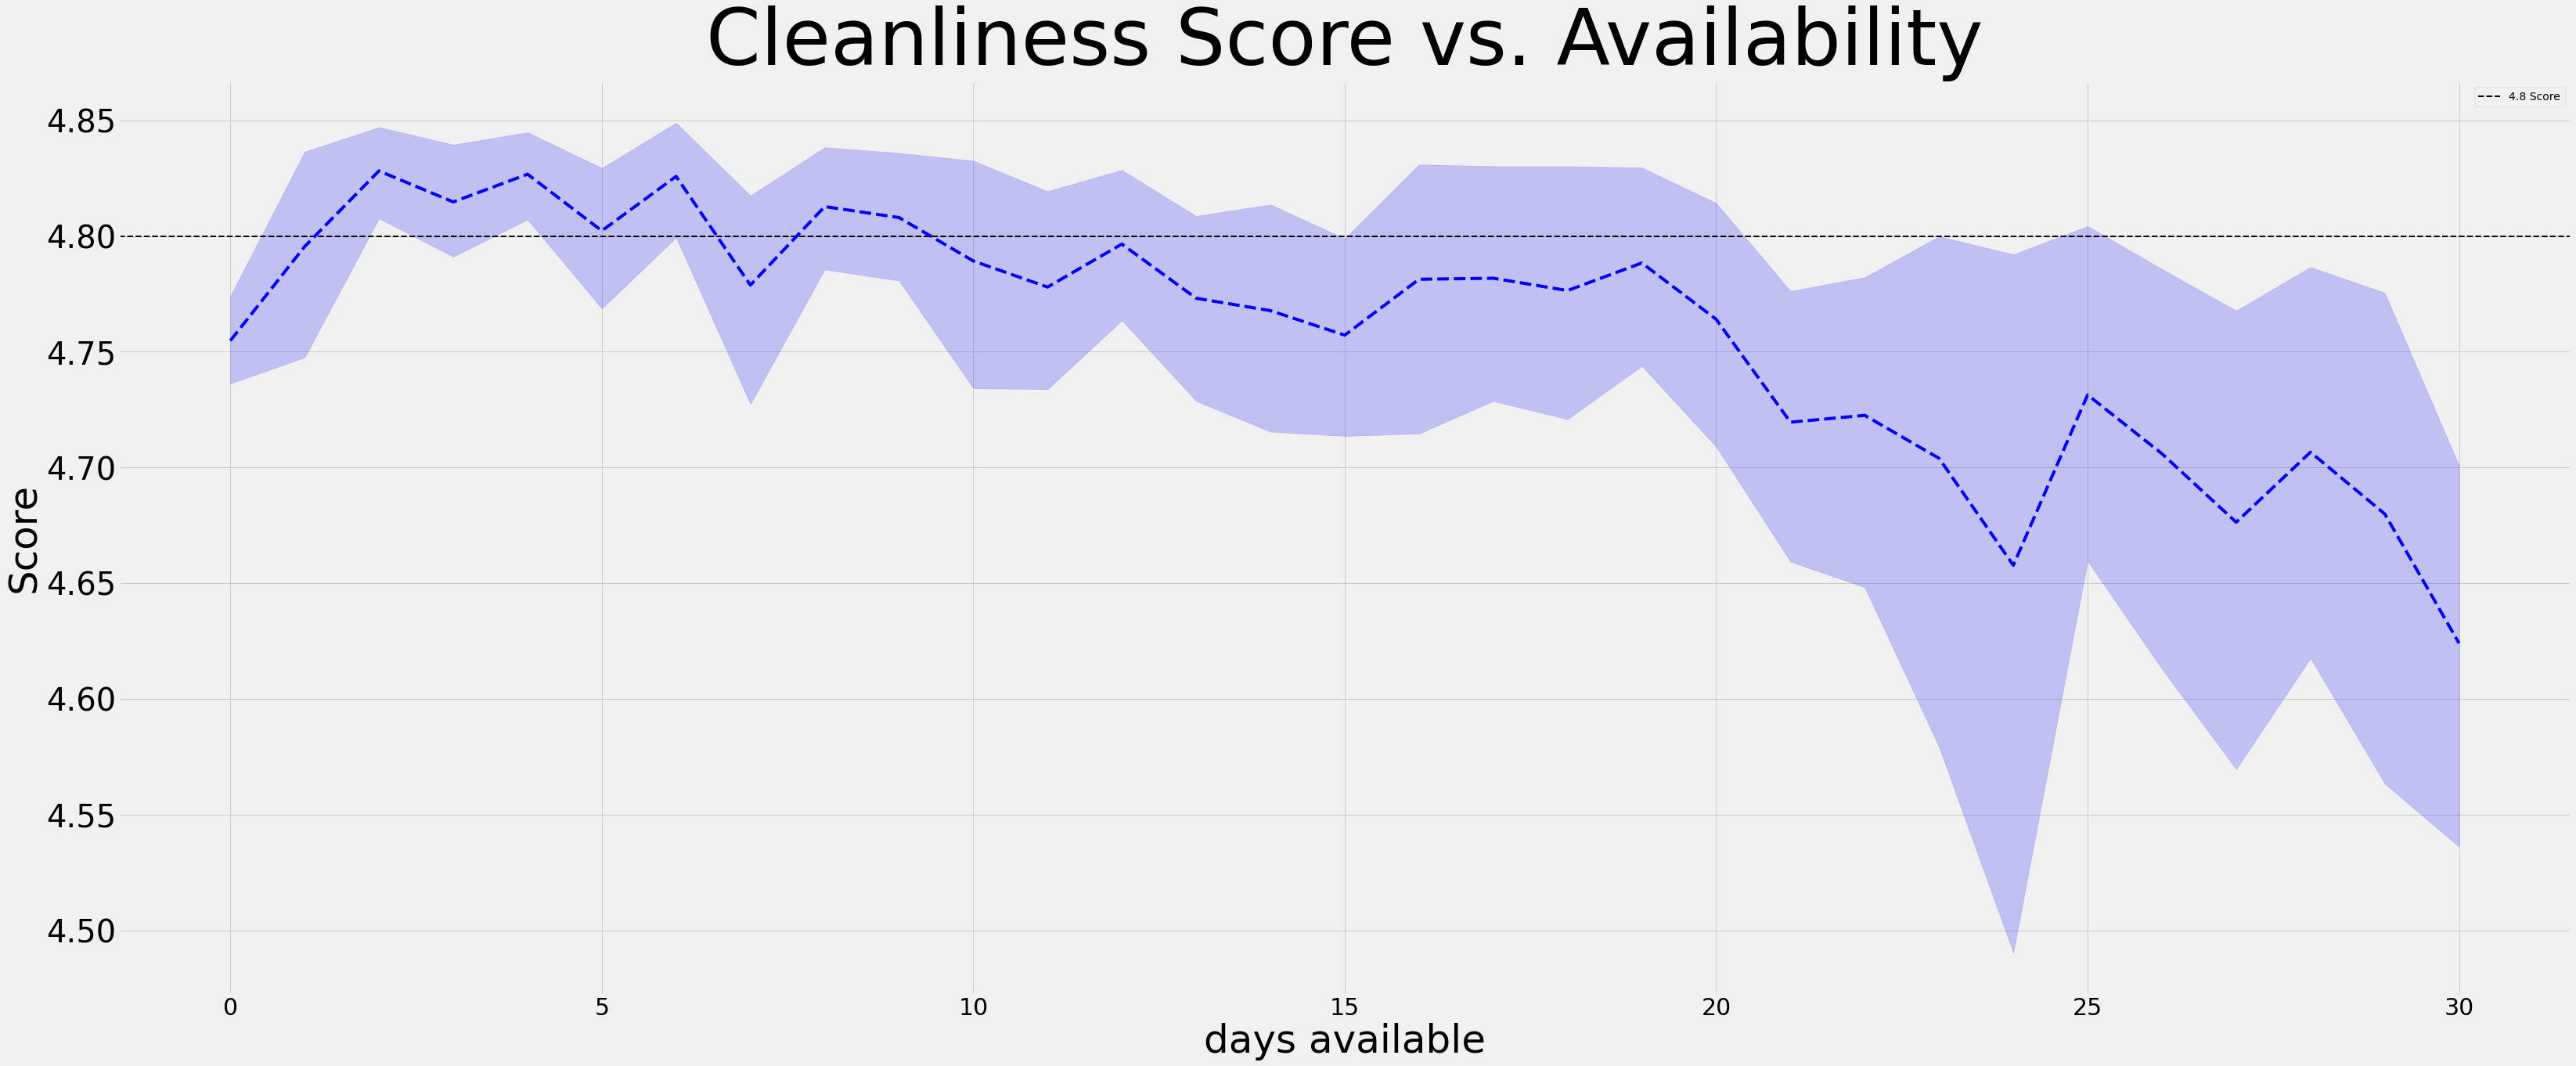

In [250]:
fig, ax = plt.subplots(figsize=(50,20))

ax.axhline(4.8, ls='--', color='black', linewidth=(2), label='4.8 Score')


p = sns.lineplot(data=host_listings, x='availability_30', y='review_scores_cleanliness',
                 ls = '--', color ='blue' );

#p = sns.lineplot(data=superhost_df, x='calculated_host_listings_count', y='review_scores_cleanliness',
#                 ls = '--', color ='green' );

#p = sns.lineplot(data=instant_bookable_df, x='calculated_host_listings_count', y='review_scores_cleanliness',
#                 ls = '--', color ='red' );


p.set_ylabel("Score", fontsize = 50)

p.set_xlabel("days available", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

p.set_title( "Cleanliness Score vs. Availability", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

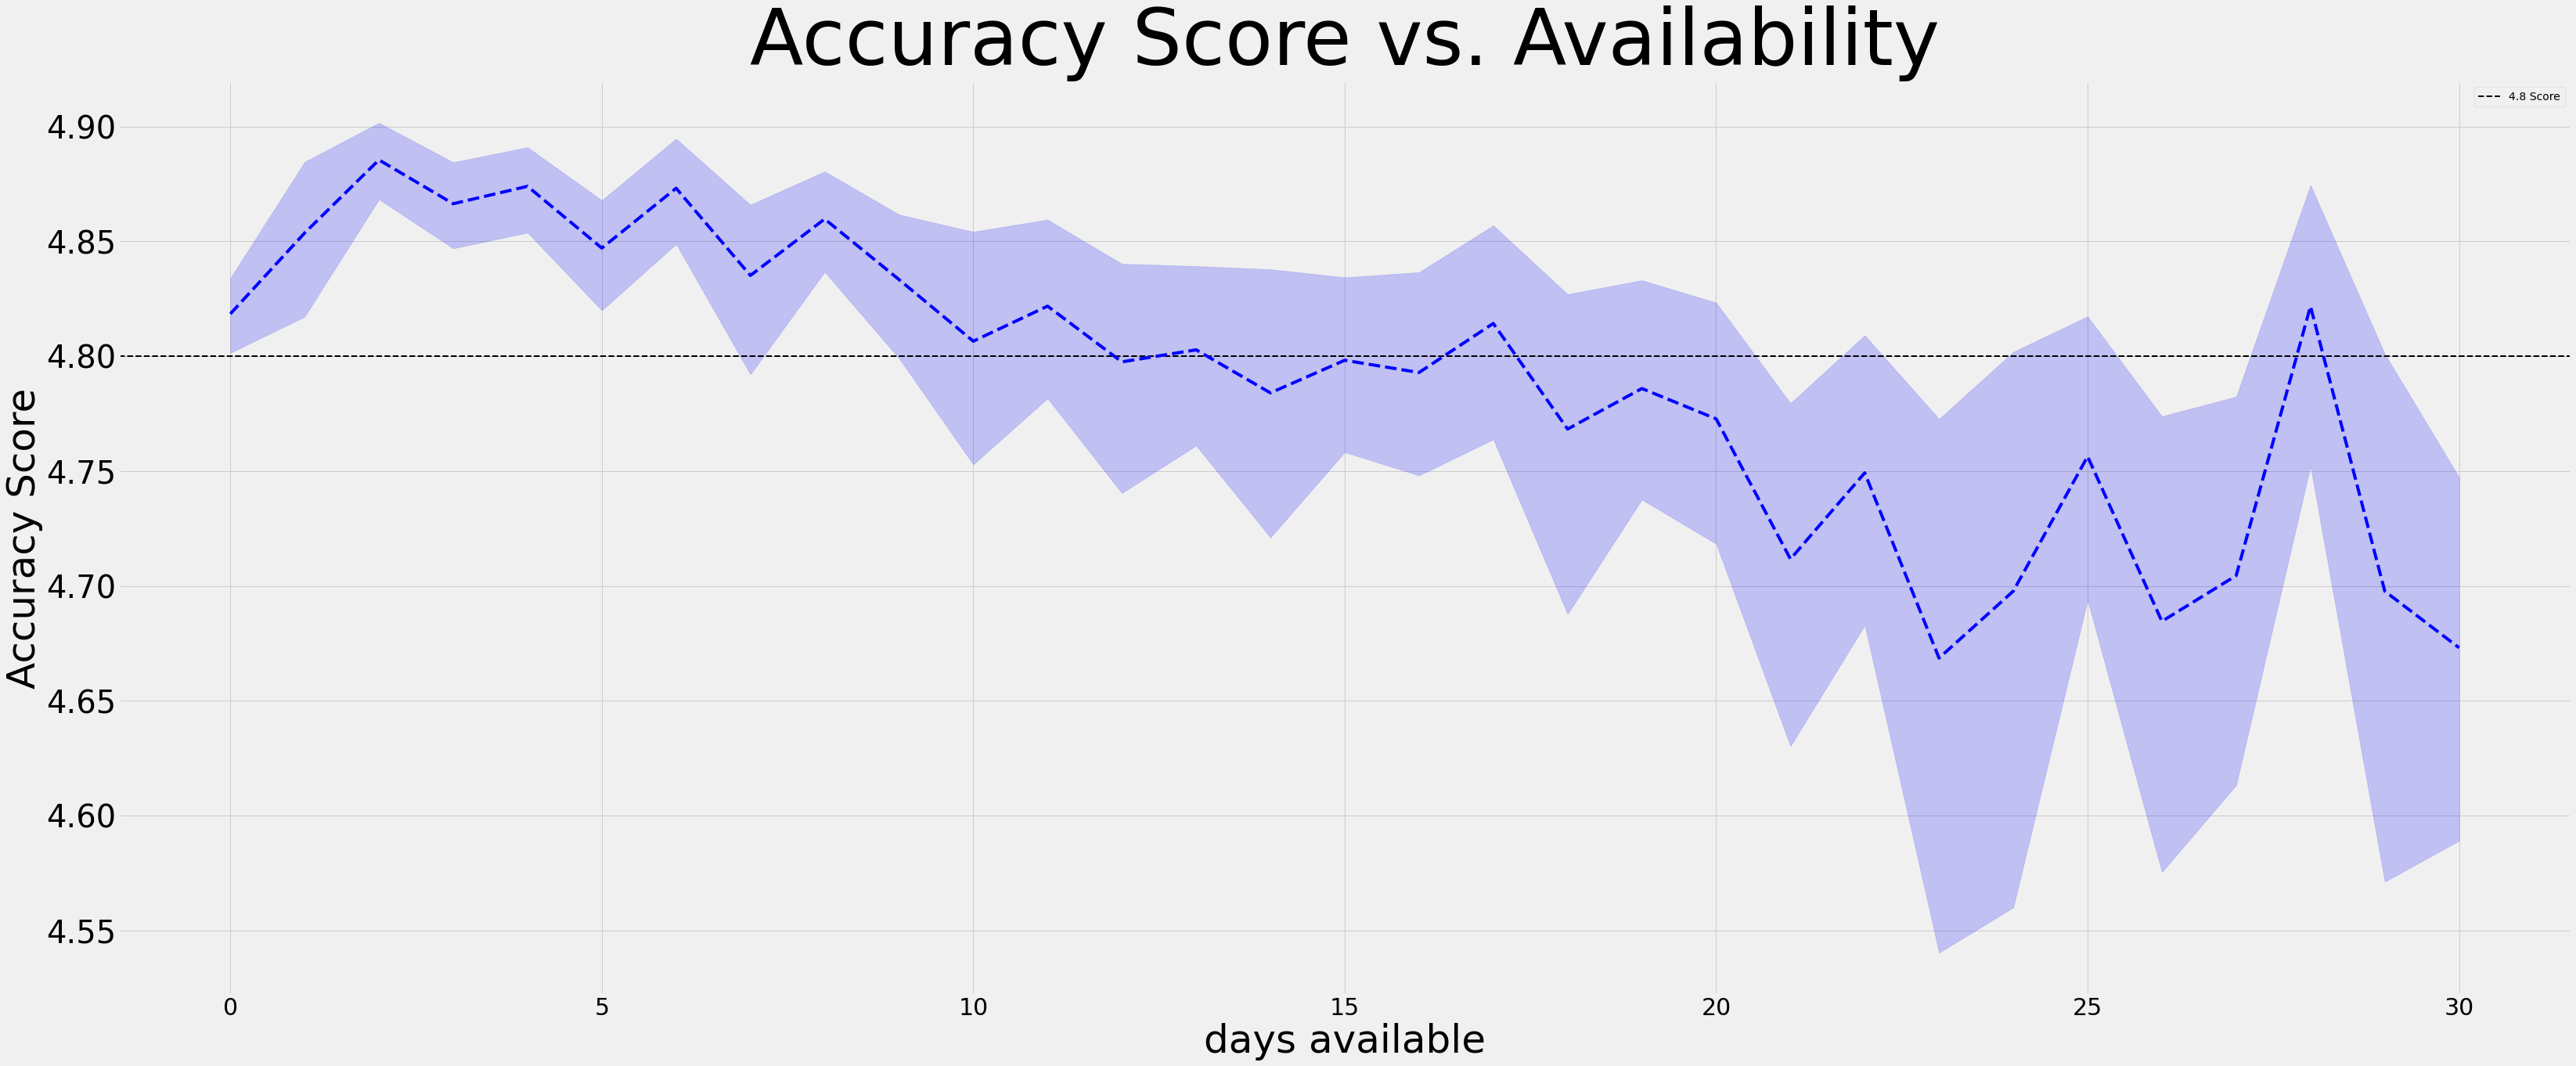

In [286]:
fig, ax = plt.subplots(figsize=(50,20))

ax.axhline(4.8, ls='--', color='black', linewidth=(2), label='4.8 Score')


p = sns.lineplot(data=host_listings, x='availability_30', y='review_scores_accuracy',
                 ls = '--', color ='blue' );

#p = sns.lineplot(data=superhost_df, x='calculated_host_listings_count', y='review_scores_cleanliness',
#                 ls = '--', color ='green' );

#p = sns.lineplot(data=instant_bookable_df, x='calculated_host_listings_count', y='review_scores_cleanliness',
#                 ls = '--', color ='red' );


p.set_ylabel("Accuracy Score", fontsize = 50)

p.set_xlabel("days available", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

p.set_title( "Accuracy Score vs. Availability", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

In [201]:
host_listings

price  review_scores_rating  review_scores_accuracy  \
0      60.0                  5.00                    5.00   
4971  141.0                  4.96                    4.98   
4976  109.0                  4.83                    4.90   
4978   75.0                  1.00                    1.00   
4981   80.0                  5.00                    5.00   
...     ...                   ...                     ...   
1410  272.0                  5.00                    4.67   
4018  272.0                  5.00                    5.00   
4015  272.0                  5.00                    5.00   
2677  314.0                  5.00                    5.00   
1493  286.0                  5.00                    5.00   

      review_scores_cleanliness  review_scores_checkin  \
0                          5.00                   5.00   
4971                       4.96                   5.00   
4976                       4.86                   4.96   
4978                       1.00                   1.00   
4981                       5.00                   5.00   
...                         ...                    ...   
1410                       5.00                   4.67   
4018                       5.00                   5.00   
4015                       5.00                   5.00   
2677                       5.00                   5.00   
1493                       5.00                   5.00   

      review_scores_communication  review_scores_location  \
0                            5.00                    4.00   
4971                         5.00                    5.00   
4976                         4.96                    4.84   
4978                         1.00                    1.00   
4981                         5.00                    5.00   
...                           ...                     ...   
1410                         5.00                    4.67   
4018                         5.00                    5.00   
4015                         5.00                    5.00   
2677                         5.00                    5.00   
1493                         5.00                    5.00   

      review_scores_value  accommodates  bedrooms  ...  host_response_90  \
0                    5.00             2       1.0  ...             False   
4971                 4.96             2       1.0  ...             False   
4976                 4.86             5       2.0  ...             False   
4978                 1.00             2       1.0  ...             False   
4981                 5.00             2       1.0  ...             False   
...                   ...           ...       ...  ...               ...   
1410                 4.67             6       2.0  ...             False   
4018                 4.00             6       2.0  ...             False   
4015                 4.00             6       2.0  ...             False   
2677                 5.00             6       2.0  ...             False   
1493                 5.00             6       2.0  ...             False   

      host_response_low superhost 5_star accuracy_5  cleanliness_5  checkin_5  \
0                 False     False   True       True           True       True   
4971              False      True   True      False          False       True   
4976              False      True   True      False          False      False   
4978               True     False  False      False          False      False   
4981              False     False   True       True           True       True   
...                 ...       ...    ...        ...            ...        ...   
1410              False     False   True      False           True      False   
4018              False     False   True       True           True       True   
4015              False     False   True       True           True       True   
2677              False     False   True       True           True       True   
1493              False     False   Tru

In [211]:
instant_bookable_df = host_listings[host_listings['instant_bookable'] == True]
not_instant_bookable_df = host_listings[host_listings['instant_bookable'] == False]

In [212]:
instant_bookable_df

price  review_scores_rating  review_scores_accuracy  \
0      60.0                  5.00                    5.00   
4990  140.0                  4.78                    4.89   
4999  130.0                  4.64                    4.77   
5019   40.0                  4.44                    4.51   
5032  128.0                  4.87                    4.90   
...     ...                   ...                     ...   
4531  173.0                  4.83                    4.83   
6626  298.0                  4.58                    4.76   
6624  206.0                  4.74                    4.76   
4472  244.0                  4.71                    4.75   
670   330.0                  4.71                    4.79   

      review_scores_cleanliness  review_scores_checkin  \
0                          5.00                   5.00   
4990                       4.89                   4.94   
4999                       4.40                   4.90   
5019                       4.31                   4.54   
5032                       4.85                   4.93   
...                         ...                    ...   
4531                       4.88                   4.93   
6626                       4.55                   4.91   
6624                       4.76                   5.00   
4472                       4.78                   4.88   
670                        4.66                   4.92   

      review_scores_communication  review_scores_location  \
0                            5.00                    4.00   
4990                         4.56                    4.78   
4999                         4.79                    4.86   
5019                         4.72                    4.69   
5032                         4.90                    4.93   
...                           ...                     ...   
4531                         4.93                    4.95   
6626                         4.94                    4.97   
6624                         4.95                    5.00   
4472                         4.98                    4.95   
670                          4.95                    4.84   

      review_scores_value  accommodates  bedrooms  ...  host_response_90  \
0                    5.00             2       1.0  ...             False   
4990                 4.67             2       1.0  ...             False   
4999                 4.65             4       1.0  ...              True   
5019                 4.59             4       1.0  ...              True   
5032                 4.86             2       1.0  ...             False   
...                   ...           ...       ...  ...               ...   
4531                 4.73             3       1.0  ...             False   
6626                 4.58             5       2.0  ...             False   
6624                 4.66             4       1.0  ...             False   
4472                 4.74             5       2.0  ...             False   
670                  4.74             6       3.0  ...             False   

      host_response_low superhost 5_star accuracy_5  cleanliness_5  checkin_5  \
0                 False     False   True       True           True       True   
4990               True      True  False      False          False      False   
4999              False     False  False      False          False      False   
5019              False     False  False      False          False      False   
5032              False      True   True      False          False      False   
...                 ...       ...    ...        ...            ...        ...   
4531              False      True   True      False          False      False   
6626              False      True  False      False          False      False   
6624              False      True  False      False          False       True   
4472              False      True  False      False          False      False   
670               False      True  Fals

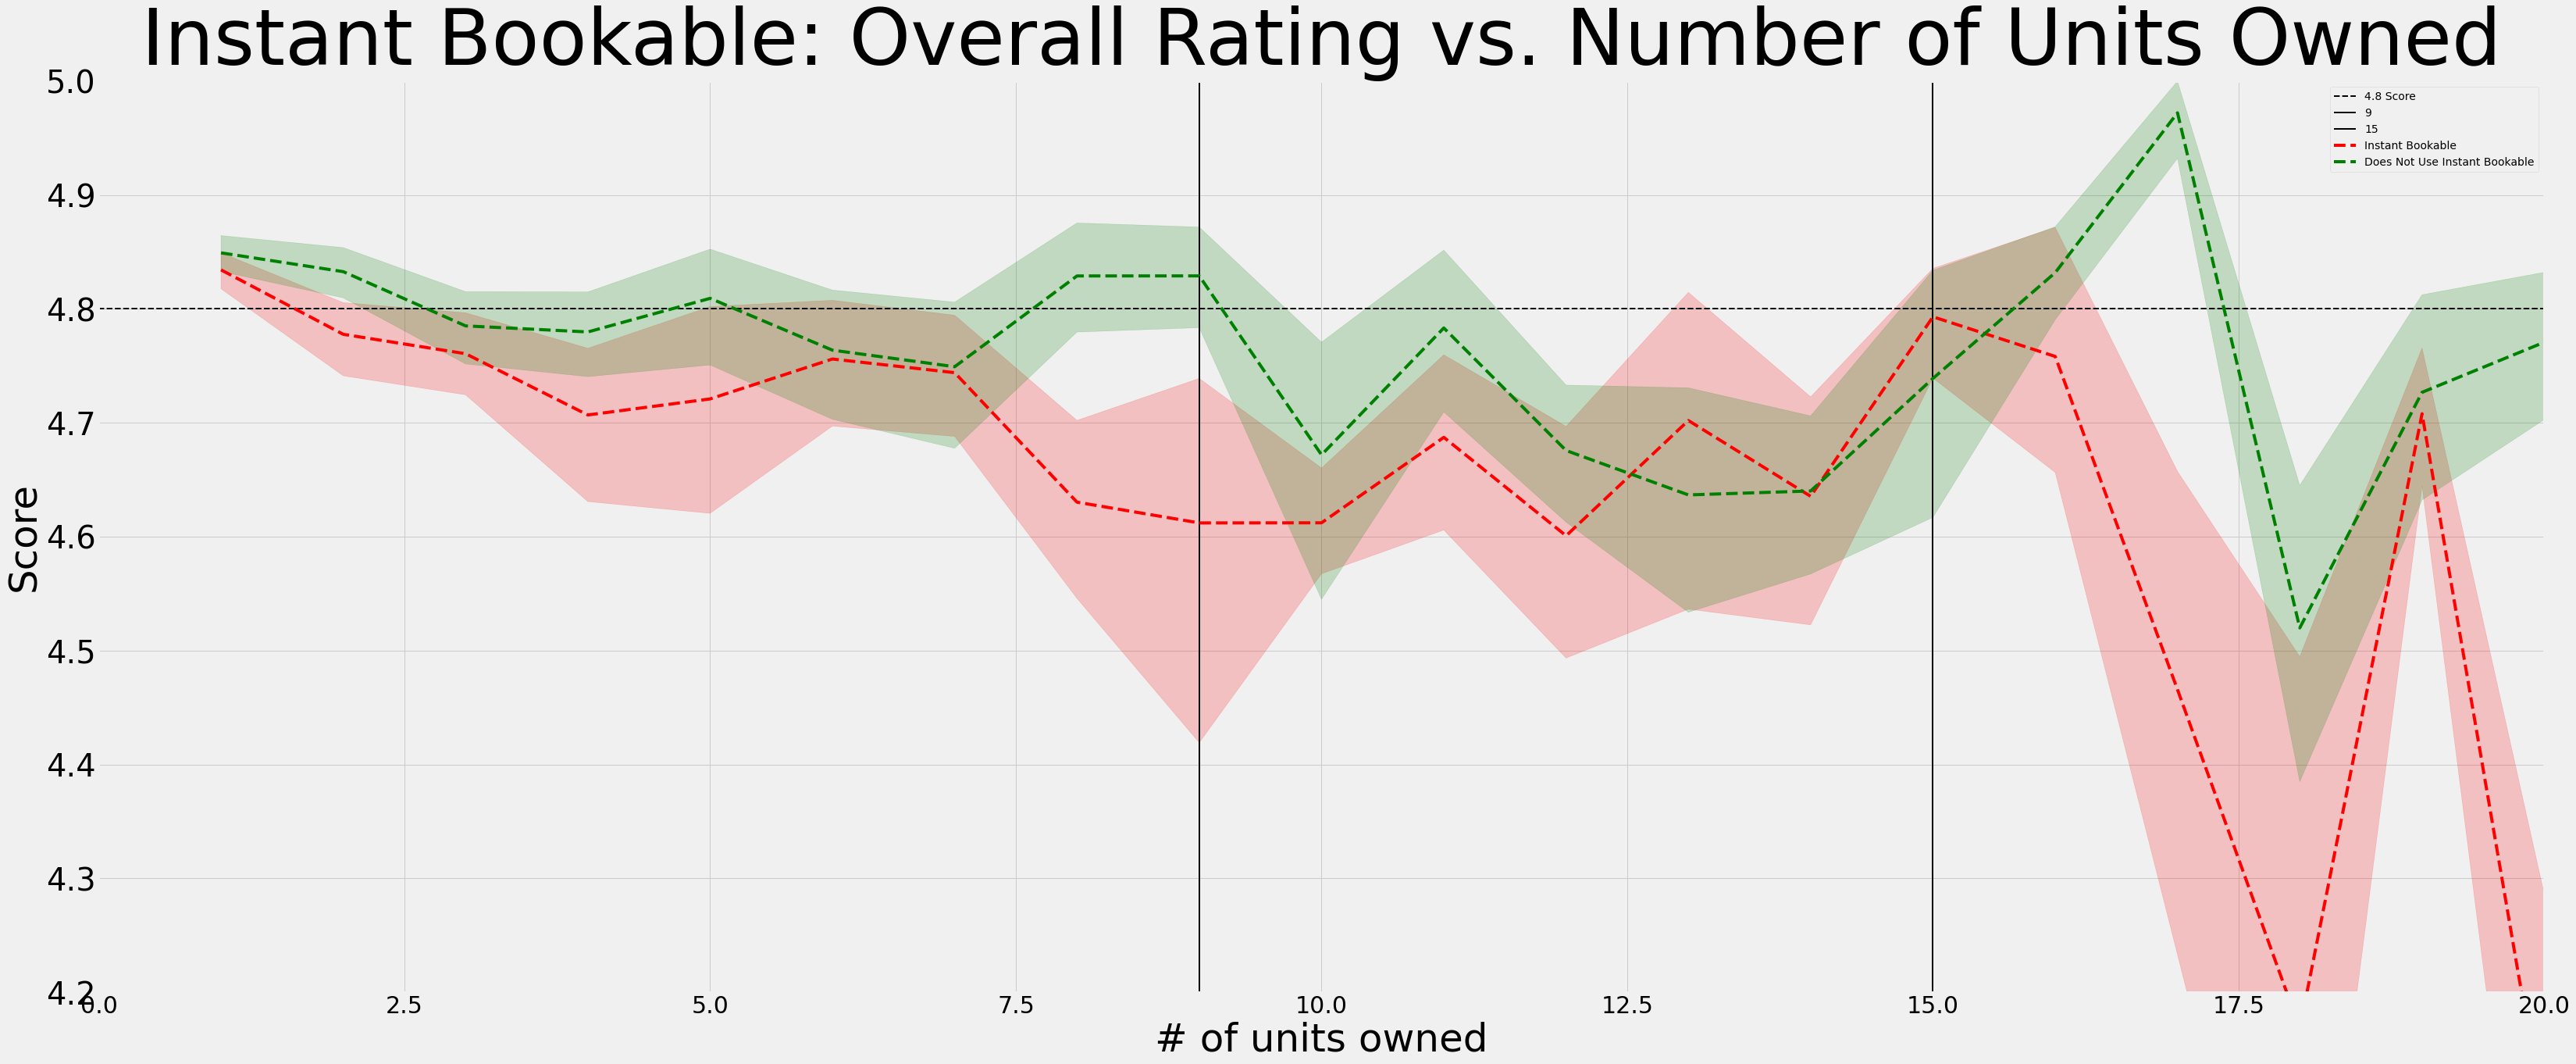

In [225]:
fig, ax = plt.subplots(figsize=(50,20))

ax.axhline(4.8, ls='--', color='black', linewidth=(2), label='4.8 Score')
ax.axvline(9, color='black', linewidth=(2), label='9')
ax.axvline(15, color='black', linewidth=(2), label='15')

plt.ylim([4.2, 5])
plt.xlim([0, 20])


p = sns.lineplot(data=instant_bookable_df, x='calculated_host_listings_count', y='review_scores_rating',
                 ls = '--', color ='red', label = "Instant Bookable" );
p = sns.lineplot(data=not_instant_bookable_df, x='calculated_host_listings_count', y='review_scores_rating',
                 ls = '--', color ='green', label= 'Does Not Use Instant Bookable' );


p.set_ylabel("Score", fontsize = 50)

p.set_xlabel("# of units owned", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

p.set_title( "Instant Bookable: Overall Rating vs. Number of Units Owned", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

In [226]:
superhost_df = host_listings[host_listings['superhost'] == True]
not_superhost_df = host_listings[host_listings['superhost'] == False]

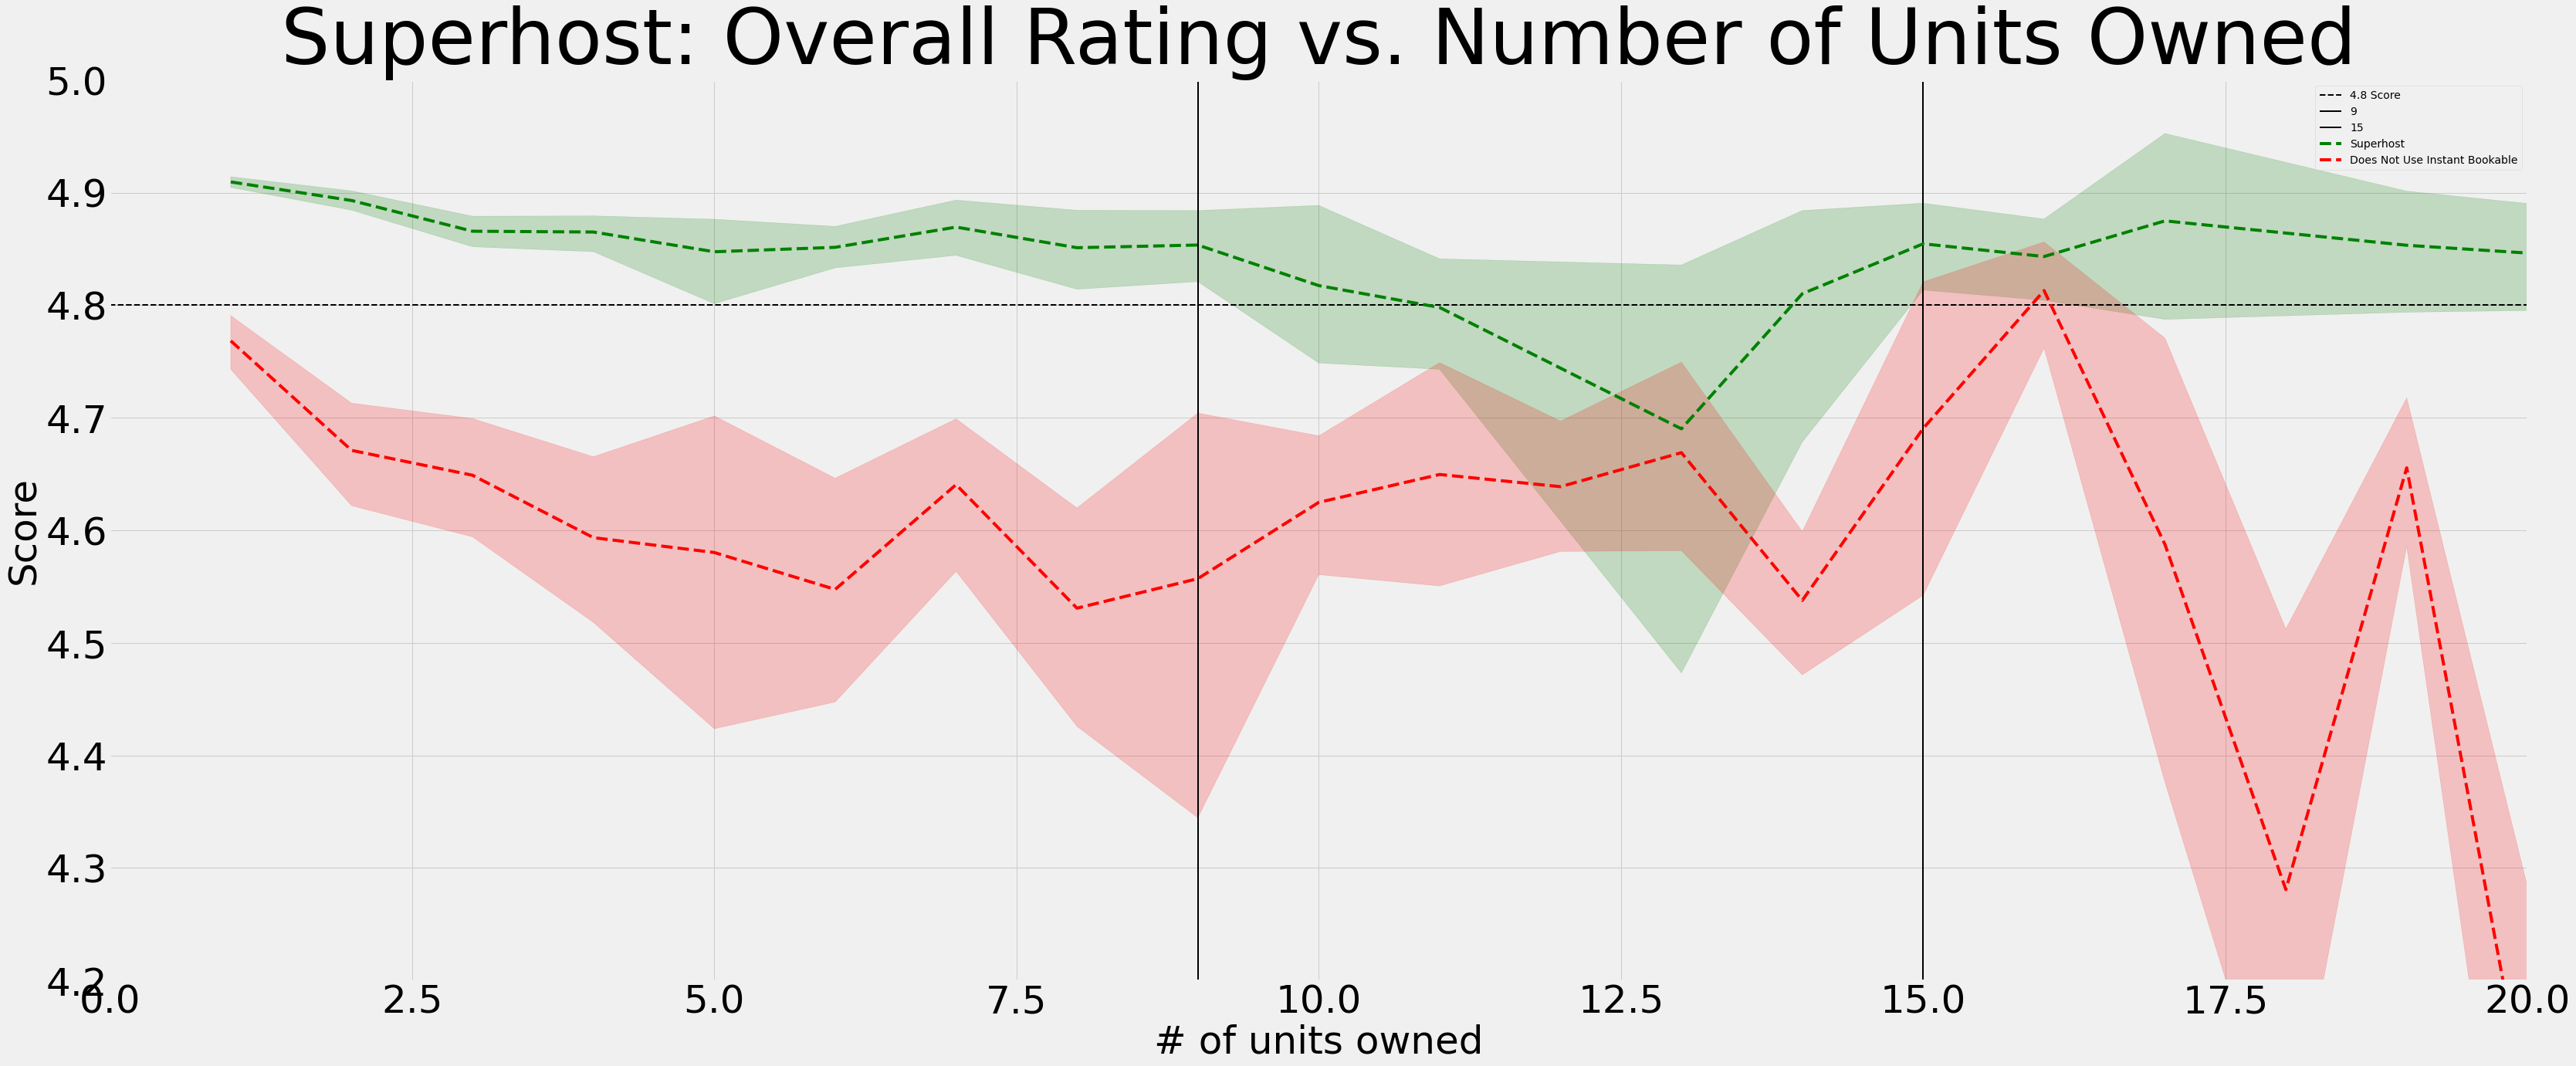

In [232]:
fig, ax = plt.subplots(figsize=(50,20))

ax.axhline(4.8, ls='--', color='black', linewidth=(2), label='4.8 Score')
ax.axvline(9, color='black', linewidth=(2), label='9')
ax.axvline(15, color='black', linewidth=(2), label='15')

plt.ylim([4.2, 5])
plt.xlim([0, 20])


p = sns.lineplot(data=superhost_df, x='calculated_host_listings_count', y='review_scores_rating',
                 ls = '--', color ='green', label = "Superhost" );
p = sns.lineplot(data=not_superhost_df, x='calculated_host_listings_count', y='review_scores_rating',
                 ls = '--', color ='red', label= 'Does Not Use Instant Bookable' );


p.set_ylabel("Score", fontsize = 50)

p.set_xlabel("# of units owned", fontsize = 50)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

p.set_title( "Superhost: Overall Rating vs. Number of Units Owned", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

In [194]:
review_metrics.head(1)

5_star_True  accuracy_5_True  cleanliness_5_True  checkin_5_True  \
0          1.0              1.0                 1.0             1.0   

   location_5_True  value_5_True  communication_5_True  \
0              0.0           1.0                   1.0   

   room_type_Entire home/apt  bedrooms_1_True  bedrooms_2_True  ...  \
0                        0.0              1.0              0.0  ...   

   host_listings_11-49_True  host_listings_50+_True  superhost_True  \
0                       0.0                     0.0             0.0   

   host_response_100_True  host_response_90_True  host_response_low_True  \
0                     1.0                    0.0                     0.0   

   host_response_time_within a few hours  host_response_time_within an hour  \
0                                    0.0                                1.0   

   room_type_room  host_response_24hrs+  
0             1.0                   0.0  

[1 rows x 29 columns]

In [195]:
review_metrics['host_listings_11-49_True'].value_counts()

0.0    6427
1.0    1383
Name: host_listings_11-49_True, dtype: int64

In [196]:
listing_metrics = review_metrics.groupby('host_listings_11-49_True').mean()
get_stats(listing_metrics)

host_listings_11-49_True                                 Metric       0.0  \
22                                        host_response_90_True  0.155905   
12                                        instant_bookable_True  0.449043   
7                                     room_type_Entire home/apt  0.811732   
25                            host_response_time_within an hour  0.788859   
9                                               bedrooms_2_True  0.270110   
24                        host_response_time_within a few hours  0.125097   
10                                             bedrooms_3+_True  0.263731   
14                                         capacity_family_True  0.057725   
4                                               location_5_True  0.310720   
8                                               bedrooms_1_True  0.466158   
5                                                  value_5_True  0.165863   
23                                       host_response_low_True  0.085888   
27                                         host_response_24hrs+  0.086043   
2                                            cleanliness_5_True  0.245371   
11                                      bookings_above_avg_True  0.536331   
1                                               accuracy_5_True  0.272756   
15                                          capacity_large_True  0.613972   
26                                               room_type_room  0.188268   
3                                                checkin_5_True  0.369535   
19                                       host_listings_50+_True  0.120118   
6                                          communication_5_True  0.377937   
21                                       host_response_100_True  0.758208   
13                                         capacity_couple_True  0.285670   
18                                      host_listings_5-10_True  0.163218   
20                                               superhost_True  0.543177   
0                                                   5_star_True  0.667496   
17                                       host_listings_2-4_True  0.336860   
16                                         host_listings_1_True  0.379804   

host_listings_11-49_True       1.0     delta  
22                        0.350687  0.194782  
12                        0.585683  0.136640  
7                         0.918294  0.106562  
25                        0.838033  0.049174  
9                         0.315257  0.045146  
24                        0.136659  0.011562  
10                        0.263196 -0.000535  
14                        0.053507 -0.004218  
4                         0.274042 -0.036678  
8                         0.421547 -0.044611  
5                         0.119306 -0.046557  
23                        0.036153 -0.049734  
27                        0.025307 -0.060736  
2                         0.182213 -0.063159  
11                        0.456255 -0.080077  
1                         0.181490 -0.091266  
15                        0.511208 -0.102765  
26                        0.081706 -0.106562  
3                         0.253796 -0.115739  
19                        0.000000 -0.120118  
6                         0.250181 -0.127756  
21                        0.613160 -0.145048  
13                        0.124367 -0.161303  
18                        0.000000 -0.163218  
20                        0.367317 -0.175860  
0                         0.454085 -0.213411  
17                        0.000000 -0.336860  
16                        0.000000 -0.379804

### Significant Advantage to being a Superhost?
- 

### Analysis:
    - Even a small drop in accuracy results in a drop in the review score rating.

### Analysis:
- Units with a perfect accuracy rating were 72% more likely to have a perfect overall rating.
- Units with a perfect cleanliness rating were 64% more likely to have a perfect overall rating.
- Units with a perfect checkin rating were 63% more likely to have a perfect overall rating.
- Units with a perfect location rating were 58% more likely to have a perfect overall rating.
- Units with a perfect value rating were 56% more likely to have a perfect overall rating.


## Conclusion

## Further Work